In [1]:
from dataclasses import dataclass

import torch
import wandb
from torch.utils.data import DataLoader

from dviforbml.architectures.dvi import DVI
from dviforbml.components.cdvi.cmcd import CMCD
from dviforbml.components.cdvi.dis import DIS
from dviforbml.components.control.aggr_control import AggrControl
from dviforbml.components.control.bca_control import BCAControl
from dviforbml.components.encoder.aggr_encoder import Aggr, AggrEncoder
from dviforbml.components.encoder.bca_encoder import BCAEncoder
from dviforbml.components.encoder.mhca_encoder import MHCAEncoder
from dviforbml.components.schedule.annealing_schedule import (
    AggrAnnealingSchedule,
    AnnealingSchedule,
    BCAAnnealingSchedule,
)
from dviforbml.components.schedule.constr_noise_schedule import (
    AggrConstrNoiseSchedule,
    BCAConstrNoiseSchedule,
    ConstrNoiseSchedule,
)
from dviforbml.components.schedule.free_noise_schedule import (
    AggrFreeNoiseSchedule,
    BCAFreeNoiseSchedule,
    FreeNoiseSchedule,
)
from dviforbml.components.schedule.step_size_schedule import StepSizeSchedule
from dviforbml.training.dvi_trainer import DVITrainerContext
from dviforbml.utils.datasets import ContextSetDataset
from dviforbml.utils.distros import TaskPosteriorGMM
from dviforbml.evaluation.visualization.visualize_dvi import visualize_dvi_2d
from dviforbml.components.cdvi.ula import ULA

In [2]:
try:
    import torch_directml

    device = torch_directml.device()
except ImportError:
    device = torch.device("cpu")

device = torch.device("cpu")

In [3]:
@dataclass
class Config:
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 16
    num_layers = 3
    non_linearity = "GELU"
    num_heads_sa = None  # 8
    num_heads_ca = 4
    use_score = False
    learning_rate = 1e-3
    size = 64
    batch_size = 64
    max_context_size = None  # 10  # None
    num_blocks = 1
    aggr = Aggr.MEAN


cfg = Config()

In [4]:
dataset = ContextSetDataset(
    size=cfg.size,
    c_dim=cfg.c_dim,
    max_context_size=10,
    sampling_factor=4,
    generator=torch.Generator(device=device),
)

dataloader = DataLoader(dataset=dataset, batch_size=cfg.batch_size, shuffle=True)

In [5]:
contextual_target = TaskPosteriorGMM

aggr_encoder = AggrEncoder(
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
    aggregation=cfg.aggr,
)

bca_encoder = BCAEncoder(
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
    bca_dim=cfg.h_dim,
)

mhca_encoder = MHCAEncoder(
    z_dim=cfg.z_dim,
    c_dim=cfg.c_dim,
    h_dim=cfg.h_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    num_heads=cfg.num_heads_sa,
    num_blocks=cfg.num_blocks,
    max_context_size=cfg.max_context_size,
)

aggr_control = AggrControl(
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    max_context_size=cfg.max_context_size,
    num_steps=cfg.num_steps,
    use_score=cfg.use_score,
)

bca_control = BCAControl(
    h_dim=cfg.h_dim,
    z_dim=cfg.z_dim,
    num_layers=cfg.num_layers,
    non_linearity=cfg.non_linearity,
    max_context_size=cfg.max_context_size,
    num_steps=cfg.num_steps,
    use_score=cfg.use_score,
)

step_size_schedule = StepSizeSchedule(num_steps=cfg.num_steps, device=device)

free_noise_sched = FreeNoiseSchedule(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    device=device,
)

aggr_free_noise_sched = AggrFreeNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
    device=device,
)

bca_free_noise_sched = BCAFreeNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
    device=device,
)

constr_noise_sched = ConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    device=device,
)

aggr_constr_noise_sched = AggrConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
)

bca_constr_noise_schede = BCAConstrNoiseSchedule(
    z_dim=cfg.z_dim,
    h_dim=cfg.h_dim,
    non_linearity=cfg.non_linearity,
    num_layers=cfg.num_layers,
    num_steps=cfg.num_steps,
    max_context_size=cfg.max_context_size,
)

# anneal_sched = AnnealingSchedule(num_steps=cfg.num_steps, device=device)

# aggr_anneal_schedule = AggrAnnealingSchedule(
#     z_dim=cfg.z_dim,
#     h_dim=cfg.h_dim,
#     num_steps=cfg.num_steps,
#     num_layers=cfg.num_layers,
#     non_linearity=cfg.non_linearity,
#     max_context_size=cfg.max_context_size,
#     device=device,
# )

# bca_anneal_schedule = BCAAnnealingSchedule(
#     z_dim=cfg.z_dim,
#     h_dim=cfg.h_dim,
#     num_steps=cfg.num_steps,
#     num_layers=cfg.num_layers,
#     non_linearity=cfg.non_linearity,
#     max_context_size=cfg.max_context_size,
#     device=device,
# )


comps = (
    aggr_encoder,
    aggr_control,
    constr_noise_sched,
    None,
)

# comps = (
#     bca_encoder,
#     bca_control,
#     bca_cos_noise_schedule,
#     bca_annealing_schedule,
# )

cdvi = DIS(
    z_dim=cfg.z_dim,
    num_steps=cfg.num_steps,
    control=comps[1],
    step_size_schedule=step_size_schedule,
    noise_schedule=comps[2],
    annealing_schedule=comps[3],
    use_score=cfg.use_score,
    device=device,
)

# cdvi = CMCD(
#     z_dim=cfg.z_dim,
#     num_steps=cfg.num_steps,
#     control=comps[1],
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[2],
#     annealing_schedule=comps[3],
#     device=device,
# )

# cdvi = ULA(
#     z_dim=cfg.z_dim,
#     num_steps=cfg.num_steps,
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[2],
#     annealing_schedule=comps[3],
#     device=device,
# )

model = DVI(encoder=comps[0], cdvi=cdvi, contextual_target=contextual_target).to(device)

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(device=device),
    wandb_logging=False,
    num_subtasks=32,
    num_samples=32,
    val_grad_off=True,
)

print(model)

DVI(
  (encoder): AggrEncoder(
    (proj_in): Linear(in_features=2, out_features=16, bias=True)
    (blocks): ModuleList(
      (0): EncoderBlock(
        (mlp): Sequential(
          (0): Linear(in_features=16, out_features=16, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=16, out_features=16, bias=True)
          (3): GELU(approximate='none')
          (4): Linear(in_features=16, out_features=16, bias=True)
          (5): GELU(approximate='none')
          (6): Linear(in_features=16, out_features=16, bias=True)
        )
      )
    )
  )
  (cdvi): DIS(
    (control): AggrControl(
      (proj_n): Embedding(17, 2)
      (mlp): Sequential(
        (0): Linear(in_features=20, out_features=16, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=16, out_features=16, bias=True)
        (5): GELU(approximate='none')
       

In [7]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="local-toytaskposterior", name="mhca")

In [8]:
# trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.learning_rate
train = True
if train:
    num_epochs = 500
    losses = trainer.train(num_epochs=num_epochs, max_clip_norm=None, alpha=None)

100%|██████████| 1/1 [00:00<00:00, 14.50it/s, epoch=0, loss=16.6]


tensor([1.7398, 1.7398], grad_fn=<PowBackward0>)
tensor([1.7106, 1.7106], grad_fn=<PowBackward0>)
tensor([1.6254, 1.6254], grad_fn=<PowBackward0>)
tensor([1.4914, 1.4914], grad_fn=<PowBackward0>)
tensor([1.3193, 1.3193], grad_fn=<PowBackward0>)
tensor([1.1226, 1.1226], grad_fn=<PowBackward0>)
tensor([0.9160, 0.9160], grad_fn=<PowBackward0>)
tensor([0.7136, 0.7136], grad_fn=<PowBackward0>)
tensor([0.5275, 0.5275], grad_fn=<PowBackward0>)
tensor([0.3670, 0.3670], grad_fn=<PowBackward0>)
tensor([0.2375, 0.2375], grad_fn=<PowBackward0>)
tensor([0.1406, 0.1406], grad_fn=<PowBackward0>)
tensor([0.0743, 0.0743], grad_fn=<PowBackward0>)
tensor([0.0337, 0.0337], grad_fn=<PowBackward0>)
tensor([0.0123, 0.0123], grad_fn=<PowBackward0>)
tensor([0.0033, 0.0033], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.14it/s, epoch=1, loss=17.1]


tensor([1.7379, 1.7379], grad_fn=<PowBackward0>)
tensor([1.7087, 1.7087], grad_fn=<PowBackward0>)
tensor([1.6236, 1.6236], grad_fn=<PowBackward0>)
tensor([1.4897, 1.4897], grad_fn=<PowBackward0>)
tensor([1.3178, 1.3178], grad_fn=<PowBackward0>)
tensor([1.1214, 1.1214], grad_fn=<PowBackward0>)
tensor([0.9150, 0.9150], grad_fn=<PowBackward0>)
tensor([0.7128, 0.7128], grad_fn=<PowBackward0>)
tensor([0.5269, 0.5269], grad_fn=<PowBackward0>)
tensor([0.3666, 0.3666], grad_fn=<PowBackward0>)
tensor([0.2372, 0.2372], grad_fn=<PowBackward0>)
tensor([0.1405, 0.1405], grad_fn=<PowBackward0>)
tensor([0.0742, 0.0742], grad_fn=<PowBackward0>)
tensor([0.0336, 0.0336], grad_fn=<PowBackward0>)
tensor([0.0123, 0.0123], grad_fn=<PowBackward0>)
tensor([0.0033, 0.0033], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7359, 1.7359], grad_fn=<PowBackward0>)
tensor([1.7068, 1.7068], grad_fn=<PowBackward0>)
tensor([1.6218, 1.6218], grad_fn=<PowBackward0>)
tensor([1.4880, 1.4880], grad_fn=<PowBackward0>)
tensor([1.3163, 1.3163], grad_fn=<PowBackward0>)
tensor([1.1201, 1.1201], grad_fn=<PowBackward0>)
tensor([0.9140, 0.9140], grad_fn=<PowBackward0>)
tensor([0.7120, 0.7120], grad_fn=<PowBackward0>)
tensor([0.5263, 0.5263], grad_fn=<PowBackward0>)
tensor([0.3662, 0.3662], grad_fn=<PowBackward0>)
tensor([0.2370, 0.2370], grad_fn=<PowBackward0>)
tensor([0.1403, 0.1403], grad_fn=<PowBackward0>)
tensor([0.0741, 0.0741], grad_fn=<PowBackward0>)
tensor([0.0336, 0.0336], grad_fn=<PowBackward0>)
tensor([0.0123, 0.0123], grad_fn=<PowBackward0>)
tensor([0.0033, 0.0033], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7340, 1.7340], grad_fn=<PowBackward0>)
tensor([1.7048, 1.7048], grad_fn=<PowBackward0>)
tensor([1.6200, 1.6200], grad_fn=<PowBackward0>)
tensor([1.4863, 1.4863], grad_fn=<PowBackward0>)
tensor([1.3148, 1.3148], grad_fn=<PowBackward0>)
tensor([1.1189, 1.1189], grad_fn=<PowBackward0>)
tensor([0.9129, 0.9130], grad_fn=<PowBackward0>)
tensor([0.7112, 0.7112], grad_fn=<PowBackward0>)
tensor([0.5257, 0.5257], grad_fn=<PowBackward0>)
tensor([0.3657, 0.3657], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.83it/s, epoch=3, loss=16.3]


tensor([0.2367, 0.2367], grad_fn=<PowBackward0>)
tensor([0.1401, 0.1401], grad_fn=<PowBackward0>)
tensor([0.0740, 0.0740], grad_fn=<PowBackward0>)
tensor([0.0336, 0.0336], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0033, 0.0033], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7320, 1.7320], grad_fn=<PowBackward0>)
tensor([1.7029, 1.7029], grad_fn=<PowBackward0>)
tensor([1.6181, 1.6181], grad_fn=<PowBackward0>)
tensor([1.4847, 1.4847], grad_fn=<PowBackward0>)
tensor([1.3134, 1.3134], grad_fn=<PowBackward0>)
tensor([1.1176, 1.1176], grad_fn=<PowBackward0>)
tensor([0.9119, 0.9119], grad_fn=<PowBackward0>)
tensor([0.7104, 0.7104], grad_fn=<PowBackward0>)
tensor([0.5251, 0.5251], grad_fn=<PowBackward0>)
tensor([0.3653, 0.3653], grad_fn=<PowBackward0>)
tensor([0.2364, 0.2364], grad_fn=<PowBackward0>)
tensor([0.1400, 0.1400], grad_fn=<PowBackward0>)
tensor([0.0739, 0.0739], grad_fn=<PowBackward0>)
tensor([0.0335, 0.0335], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.50it/s, epoch=4, loss=16.9]


tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0033, 0.0033], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7301, 1.7301], grad_fn=<PowBackward0>)
tensor([1.7010, 1.7010], grad_fn=<PowBackward0>)
tensor([1.6163, 1.6163], grad_fn=<PowBackward0>)
tensor([1.4830, 1.4830], grad_fn=<PowBackward0>)
tensor([1.3119, 1.3119], grad_fn=<PowBackward0>)
tensor([1.1163, 1.1163], grad_fn=<PowBackward0>)
tensor([0.9109, 0.9109], grad_fn=<PowBackward0>)
tensor([0.7096, 0.7096], grad_fn=<PowBackward0>)
tensor([0.5245, 0.5245], grad_fn=<PowBackward0>)
tensor([0.3649, 0.3649], grad_fn=<PowBackward0>)
tensor([0.2362, 0.2362], grad_fn=<PowBackward0>)
tensor([0.1398, 0.1398], grad_fn=<PowBackward0>)
tensor([0.0739, 0.0739], grad_fn=<PowBackward0>)
tensor([0.0335, 0.0335], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7281, 1.7281], grad_fn=<PowBackward0>)
tensor([1.6991, 1.6991], grad_fn=<PowBackward0>)
tensor([1.6145, 1.6145], grad_fn=<PowBackward0>)
tensor([1.4813, 1.4813], grad_fn=<PowBackward0>)
tensor([1.3104, 1.3104], grad_fn=<PowBackward0>)
tensor([1.1151, 1.1151], grad_fn=<PowBackward0>)
tensor([0.9099, 0.9099], grad_fn=<PowBackward0>)
tensor([0.7088, 0.7088], grad_fn=<PowBackward0>)
tensor([0.5239, 0.5239], grad_fn=<PowBackward0>)
tensor([0.3645, 0.3645], grad_fn=<PowBackward0>)
tensor([0.2359, 0.2359], grad_fn=<PowBackward0>)
tensor([0.1397, 0.1397], grad_fn=<PowBackward0>)
tensor([0.0738, 0.0738], grad_fn=<PowBackward0>)
tensor([0.0334, 0.0334], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7262, 1.7261], grad_fn=<PowBackward0>)
tensor([1.6972, 1.6972], grad_fn=<PowBackward0>)
tensor([1.6127, 1.6127], grad_fn=<PowBackward0>)
tensor([1.4797, 1.4796], grad_fn=<PowBackward0>)
tensor([1.3089, 1.3089], grad_fn=<PowBackward0>)
tensor([1.1138, 1.1138], grad_fn=<PowBackward0>)
tensor([0.9089, 0.9088], grad_fn=<PowBackward0>)
tensor([0.7080, 0.7080], grad_fn=<PowBackward0>)
tensor([0.5234, 0.5234], grad_fn=<PowBackward0>)
tensor([0.3641, 0.3641], grad_fn=<PowBackward0>)
tensor([0.2356, 0.2356], grad_fn=<PowBackward0>)
tensor([0.1395, 0.1395], grad_fn=<PowBackward0>)
tensor([0.0737, 0.0737], grad_fn=<PowBackward0>)
tensor([0.0334, 0.0334], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7242, 1.7242], grad_fn=<PowBackward0>)
tensor([1.6953, 1.6952], grad_fn=<PowBackward0>)
tensor([1.6109, 1.6108], grad_fn=<PowBackward0>)
tensor([1.4780, 1.4780], grad_fn=<PowBackward0>)
tensor([1.3075, 1.3074], grad_fn=<PowBackward0>)
tensor([1.1126, 1.1126], grad_fn=<PowBackward0>)
tensor([0.9078, 0.9078], grad_fn=<PowBackward0>)
tensor([0.7072, 0.7072], grad_fn=<PowBackward0>)
tensor([0.5228, 0.5228], grad_fn=<PowBackward0>)
tensor([0.3637, 0.3637], grad_fn=<PowBackward0>)
tensor([0.2354, 0.2354], grad_fn=<PowBackward0>)
tensor([0.1394, 0.1393], grad_fn=<PowBackward0>)
tensor([0.0736, 0.0736], grad_fn=<PowBackward0>)
tensor([0.0334, 0.0334], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7223, 1.7222], grad_fn=<PowBackward0>)
tensor([1.6934, 1.6933], grad_fn=<PowBackward0>)
tensor([1.6091, 1.6090], grad_fn=<PowBackward0>)
tensor([1.4764, 1.4763], grad_fn=<PowBackward0>)
tensor([1.3060, 1.3060], grad_fn=<PowBackward0>)
tensor([1.1113, 1.1113], grad_fn=<PowBackward0>)
tensor([0.9068, 0.9068], grad_fn=<PowBackward0>)
tensor([0.7064, 0.7064], grad_fn=<PowBackward0>)
tensor([0.5222, 0.5222], grad_fn=<PowBackward0>)
tensor([0.3633, 0.3633], grad_fn=<PowBackward0>)
tensor([0.2351, 0.2351], grad_fn=<PowBackward0>)
tensor([0.1392, 0.1392], grad_fn=<PowBackward0>)
tensor([0.0735, 0.0735], grad_fn=<PowBackward0>)
tensor([0.0333, 0.0333], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7204, 1.7203], grad_fn=<PowBackward0>)
tensor([1.6915, 1.6914], grad_fn=<PowBackward0>)
tensor([1.6073, 1.6072], grad_fn=<PowBackward0>)
tensor([1.4747, 1.4746], grad_fn=<PowBackward0>)
tensor([1.3045, 1.3045], grad_fn=<PowBackward0>)
tensor([1.1101, 1.1100], grad_fn=<PowBackward0>)
tensor([0.9058, 0.9058], grad_fn=<PowBackward0>)
tensor([0.7056, 0.7056], grad_fn=<PowBackward0>)
tensor([0.5216, 0.5216], grad_fn=<PowBackward0>)
tensor([0.3629, 0.3629], grad_fn=<PowBackward0>)
tensor([0.2349, 0.2348], grad_fn=<PowBackward0>)
tensor([0.1390, 0.1390], grad_fn=<PowBackward0>)
tensor([0.0734, 0.0734], grad_fn=<PowBackward0>)
tensor([0.0333, 0.0333], grad_fn=<PowBackward0>)
tensor([0.0122, 0.0122], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7185, 1.7184], grad_fn=<PowBackward0>)
tensor([1.6896, 1.6895], grad_fn=<PowBackward0>)
tensor([1.6055, 1.6054], grad_fn=<PowBackward0>)
tensor([1.4731, 1.4730], grad_fn=<PowBackward0>)
tensor([1.3031, 1.3030], grad_fn=<PowBackward0>)
tensor([1.1089, 1.1088], grad_fn=<PowBackward0>)
tensor([0.9048, 0.9047], grad_fn=<PowBackward0>)
tensor([0.7048, 0.7048], grad_fn=<PowBackward0>)
tensor([0.5210, 0.5210], grad_fn=<PowBackward0>)
tensor([0.3625, 0.3625], grad_fn=<PowBackward0>)
tensor([0.2346, 0.2346], grad_fn=<PowBackward0>)
tensor([0.1389, 0.1389], grad_fn=<PowBackward0>)
tensor([0.0734, 0.0734], grad_fn=<PowBackward0>)
tensor([0.0333, 0.0333], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7165, 1.7164], grad_fn=<PowBackward0>)
tensor([1.6877, 1.6876], grad_fn=<PowBackward0>)
tensor([1.6037, 1.6036], grad_fn=<PowBackward0>)
tensor([1.4714, 1.4713], grad_fn=<PowBackward0>)
tensor([1.3016, 1.3015], grad_fn=<PowBackward0>)
tensor([1.1076, 1.1075], grad_fn=<PowBackward0>)
tensor([0.9038, 0.9037], grad_fn=<PowBackward0>)
tensor([0.7040, 0.7040], grad_fn=<PowBackward0>)
tensor([0.5204, 0.5204], grad_fn=<PowBackward0>)
tensor([0.3621, 0.3620], grad_fn=<PowBackward0>)
tensor([0.2343, 0.2343], grad_fn=<PowBackward0>)
tensor([0.1387, 0.1387], grad_fn=<PowBackward0>)
tensor([0.0733, 0.0733], grad_fn=<PowBackward0>)
tensor([0.0332, 0.0332], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7146, 1.7145], grad_fn=<PowBackward0>)
tensor([1.6858, 1.6857], grad_fn=<PowBackward0>)
tensor([1.6019, 1.6018], grad_fn=<PowBackward0>)
tensor([1.4698, 1.4696], grad_fn=<PowBackward0>)
tensor([1.3002, 1.3001], grad_fn=<PowBackward0>)
tensor([1.1064, 1.1063], grad_fn=<PowBackward0>)
tensor([0.9028, 0.9027], grad_fn=<PowBackward0>)
tensor([0.7033, 0.7032], grad_fn=<PowBackward0>)
tensor([0.5199, 0.5198], grad_fn=<PowBackward0>)
tensor([0.3617, 0.3616], grad_fn=<PowBackward0>)
tensor([0.2341, 0.2340], grad_fn=<PowBackward0>)
tensor([0.1386, 0.1386], grad_fn=<PowBackward0>)
tensor([0.0732, 0.0732], grad_fn=<PowBackward0>)
tensor([0.0332, 0.0332], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7127, 1.7125], grad_fn=<PowBackward0>)
tensor([1.6840, 1.6838], grad_fn=<PowBackward0>)
tensor([1.6001, 1.5999], grad_fn=<PowBackward0>)
tensor([1.4681, 1.4680], grad_fn=<PowBackward0>)
tensor([1.2987, 1.2986], grad_fn=<PowBackward0>)
tensor([1.1052, 1.1050], grad_fn=<PowBackward0>)
tensor([0.9018, 0.9017], grad_fn=<PowBackward0>)
tensor([0.7025, 0.7024], grad_fn=<PowBackward0>)
tensor([0.5193, 0.5192], grad_fn=<PowBackward0>)
tensor([0.3613, 0.3612], grad_fn=<PowBackward0>)
tensor([0.2338, 0.2338], grad_fn=<PowBackward0>)
tensor([0.1384, 0.1384], grad_fn=<PowBackward0>)
tensor([0.0731, 0.0731], grad_fn=<PowBackward0>)
tensor([0.0331, 0.0331], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7108, 1.7106], grad_fn=<PowBackward0>)
tensor([1.6821, 1.6819], grad_fn=<PowBackward0>)
tensor([1.5984, 1.5981], grad_fn=<PowBackward0>)
tensor([1.4665, 1.4663], grad_fn=<PowBackward0>)
tensor([1.2973, 1.2971], grad_fn=<PowBackward0>)
tensor([1.1039, 1.1038], grad_fn=<PowBackward0>)
tensor([0.9008, 0.9007], grad_fn=<PowBackward0>)
tensor([0.7017, 0.7016], grad_fn=<PowBackward0>)
tensor([0.5187, 0.5186], grad_fn=<PowBackward0>)
tensor([0.3609, 0.3608], grad_fn=<PowBackward0>)
tensor([0.2335, 0.2335], grad_fn=<PowBackward0>)
tensor([0.1383, 0.1382], grad_fn=<PowBackward0>)
tensor([0.0730, 0.0730], grad_fn=<PowBackward0>)
tensor([0.0331, 0.0331], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7089, 1.7087], grad_fn=<PowBackward0>)
tensor([1.6802, 1.6800], grad_fn=<PowBackward0>)
tensor([1.5966, 1.5963], grad_fn=<PowBackward0>)
tensor([1.4649, 1.4647], grad_fn=<PowBackward0>)
tensor([1.2958, 1.2957], grad_fn=<PowBackward0>)
tensor([1.1027, 1.1025], grad_fn=<PowBackward0>)
tensor([0.8998, 0.8996], grad_fn=<PowBackward0>)
tensor([0.7009, 0.7008], grad_fn=<PowBackward0>)
tensor([0.5181, 0.5181], grad_fn=<PowBackward0>)
tensor([0.3605, 0.3604], grad_fn=<PowBackward0>)
tensor([0.2333, 0.2333], grad_fn=<PowBackward0>)
tensor([0.1381, 0.1381], grad_fn=<PowBackward0>)
tensor([0.0730, 0.0729], grad_fn=<PowBackward0>)
tensor([0.0331, 0.0331], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7070, 1.7067], grad_fn=<PowBackward0>)
tensor([1.6784, 1.6781], grad_fn=<PowBackward0>)
tensor([1.5948, 1.5945], grad_fn=<PowBackward0>)
tensor([1.4632, 1.4630], grad_fn=<PowBackward0>)
tensor([1.2944, 1.2942], grad_fn=<PowBackward0>)
tensor([1.1015, 1.1013], grad_fn=<PowBackward0>)
tensor([0.8988, 0.8986], grad_fn=<PowBackward0>)
tensor([0.7001, 0.7000], grad_fn=<PowBackward0>)
tensor([0.5176, 0.5175], grad_fn=<PowBackward0>)
tensor([0.3601, 0.3600], grad_fn=<PowBackward0>)
tensor([0.2330, 0.2330], grad_fn=<PowBackward0>)
tensor([0.1380, 0.1379], grad_fn=<PowBackward0>)
tensor([0.0729, 0.0729], grad_fn=<PowBackward0>)
tensor([0.0330, 0.0330], grad_fn=<PowBackward0>)
tensor([0.0121, 0.0121], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7051, 1.7048], grad_fn=<PowBackward0>)
tensor([1.6765, 1.6762], grad_fn=<PowBackward0>)
tensor([1.5930, 1.5928], grad_fn=<PowBackward0>)
tensor([1.4616, 1.4614], grad_fn=<PowBackward0>)
tensor([1.2930, 1.2928], grad_fn=<PowBackward0>)
tensor([1.1002, 1.1001], grad_fn=<PowBackward0>)
tensor([0.8978, 0.8976], grad_fn=<PowBackward0>)
tensor([0.6993, 0.6992], grad_fn=<PowBackward0>)
tensor([0.5170, 0.5169], grad_fn=<PowBackward0>)
tensor([0.3597, 0.3596], grad_fn=<PowBackward0>)
tensor([0.2328, 0.2327], grad_fn=<PowBackward0>)
tensor([0.1378, 0.1378], grad_fn=<PowBackward0>)
tensor([0.0728, 0.0728], grad_fn=<PowBackward0>)
tensor([0.0330, 0.0330], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7032, 1.7029], grad_fn=<PowBackward0>)
tensor([1.6746, 1.6744], grad_fn=<PowBackward0>)
tensor([1.5912, 1.5910], grad_fn=<PowBackward0>)
tensor([1.4600, 1.4598], grad_fn=<PowBackward0>)
tensor([1.2915, 1.2913], grad_fn=<PowBackward0>)
tensor([1.0990, 1.0988], grad_fn=<PowBackward0>)
tensor([0.8968, 0.8966], grad_fn=<PowBackward0>)
tensor([0.6986, 0.6985], grad_fn=<PowBackward0>)
tensor([0.5164, 0.5163], grad_fn=<PowBackward0>)
tensor([0.3593, 0.3592], grad_fn=<PowBackward0>)
tensor([0.2325, 0.2325], grad_fn=<PowBackward0>)
tensor([0.1377, 0.1376], grad_fn=<PowBackward0>)
tensor([0.0727, 0.0727], grad_fn=<PowBackward0>)
tensor([0.0330, 0.0330], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.7013, 1.7010], grad_fn=<PowBackward0>)
tensor([1.6727, 1.6725], grad_fn=<PowBackward0>)
tensor([1.5895, 1.5892], grad_fn=<PowBackward0>)
tensor([1.4584, 1.4581], grad_fn=<PowBackward0>)
tensor([1.2901, 1.2899], grad_fn=<PowBackward0>)
tensor([1.0978, 1.0976], grad_fn=<PowBackward0>)
tensor([0.8958, 0.8956], grad_fn=<PowBackward0>)
tensor([0.6978, 0.6977], grad_fn=<PowBackward0>)
tensor([0.5158, 0.5157], grad_fn=<PowBackward0>)
tensor([0.3589, 0.3588], grad_fn=<PowBackward0>)
tensor([0.2322, 0.2322], grad_fn=<PowBackward0>)
tensor([0.1375, 0.1375], grad_fn=<PowBackward0>)
tensor([0.0726, 0.0726], grad_fn=<PowBackward0>)
tensor([0.0329, 0.0329], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6994, 1.6991], grad_fn=<PowBackward0>)
tensor([1.6709, 1.6706], grad_fn=<PowBackward0>)
tensor([1.5877, 1.5874], grad_fn=<PowBackward0>)
tensor([1.4567, 1.4565], grad_fn=<PowBackward0>)
tensor([1.2886, 1.2884], grad_fn=<PowBackward0>)
tensor([1.0966, 1.0964], grad_fn=<PowBackward0>)
tensor([0.8948, 0.8946], grad_fn=<PowBackward0>)
tensor([0.6970, 0.6969], grad_fn=<PowBackward0>)
tensor([0.5152, 0.5152], grad_fn=<PowBackward0>)
tensor([0.3585, 0.3584], grad_fn=<PowBackward0>)
tensor([0.2320, 0.2320], grad_fn=<PowBackward0>)
tensor([0.1373, 0.1373], grad_fn=<PowBackward0>)
tensor([0.0725, 0.0725], grad_fn=<PowBackward0>)
tensor([0.0329, 0.0329], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6975, 1.6973], grad_fn=<PowBackward0>)
tensor([1.6690, 1.6688], grad_fn=<PowBackward0>)
tensor([1.5859, 1.5857], grad_fn=<PowBackward0>)
tensor([1.4551, 1.4549], grad_fn=<PowBackward0>)
tensor([1.2872, 1.2870], grad_fn=<PowBackward0>)
tensor([1.0954, 1.0952], grad_fn=<PowBackward0>)
tensor([0.8938, 0.8936], grad_fn=<PowBackward0>)
tensor([0.6962, 0.6961], grad_fn=<PowBackward0>)
tensor([0.5147, 0.5146], grad_fn=<PowBackward0>)
tensor([0.3581, 0.3580], grad_fn=<PowBackward0>)
tensor([0.2317, 0.2317], grad_fn=<PowBackward0>)
tensor([0.1372, 0.1372], grad_fn=<PowBackward0>)
tensor([0.0725, 0.0725], grad_fn=<PowBackward0>)
tensor([0.0328, 0.0328], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6957, 1.6954], grad_fn=<PowBackward0>)
tensor([1.6672, 1.6669], grad_fn=<PowBackward0>)
tensor([1.5842, 1.5839], grad_fn=<PowBackward0>)
tensor([1.4535, 1.4533], grad_fn=<PowBackward0>)
tensor([1.2858, 1.2856], grad_fn=<PowBackward0>)
tensor([1.0942, 1.0940], grad_fn=<PowBackward0>)
tensor([0.8928, 0.8926], grad_fn=<PowBackward0>)
tensor([0.6955, 0.6953], grad_fn=<PowBackward0>)
tensor([0.5141, 0.5140], grad_fn=<PowBackward0>)
tensor([0.3577, 0.3576], grad_fn=<PowBackward0>)
tensor([0.2315, 0.2314], grad_fn=<PowBackward0>)
tensor([0.1370, 0.1370], grad_fn=<PowBackward0>)
tensor([0.0724, 0.0724], grad_fn=<PowBackward0>)
tensor([0.0328, 0.0328], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6938, 1.6935], grad_fn=<PowBackward0>)
tensor([1.6654, 1.6651], grad_fn=<PowBackward0>)
tensor([1.5825, 1.5822], grad_fn=<PowBackward0>)
tensor([1.4519, 1.4517], grad_fn=<PowBackward0>)
tensor([1.2844, 1.2842], grad_fn=<PowBackward0>)
tensor([1.0930, 1.0928], grad_fn=<PowBackward0>)
tensor([0.8918, 0.8916], grad_fn=<PowBackward0>)
tensor([0.6947, 0.6946], grad_fn=<PowBackward0>)
tensor([0.5135, 0.5135], grad_fn=<PowBackward0>)
tensor([0.3573, 0.3572], grad_fn=<PowBackward0>)
tensor([0.2312, 0.2312], grad_fn=<PowBackward0>)
tensor([0.1369, 0.1369], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.27it/s, epoch=24, loss=16.2]


tensor([0.0723, 0.0723], grad_fn=<PowBackward0>)
tensor([0.0328, 0.0328], grad_fn=<PowBackward0>)
tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6920, 1.6916], grad_fn=<PowBackward0>)
tensor([1.6636, 1.6632], grad_fn=<PowBackward0>)
tensor([1.5807, 1.5804], grad_fn=<PowBackward0>)
tensor([1.4504, 1.4500], grad_fn=<PowBackward0>)
tensor([1.2830, 1.2827], grad_fn=<PowBackward0>)
tensor([1.0918, 1.0915], grad_fn=<PowBackward0>)
tensor([0.8908, 0.8907], grad_fn=<PowBackward0>)
tensor([0.6940, 0.6938], grad_fn=<PowBackward0>)
tensor([0.5130, 0.5129], grad_fn=<PowBackward0>)
tensor([0.3569, 0.3568], grad_fn=<PowBackward0>)
tensor([0.2310, 0.2309], grad_fn=<PowBackward0>)
tensor([0.1367, 0.1367], grad_fn=<PowBackward0>)
tensor([0.0722, 0.0722], grad_fn=<PowBackward0>)
tensor([0.0327, 0.0327], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.89it/s, epoch=25, loss=16]


tensor([0.0120, 0.0120], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6901, 1.6897], grad_fn=<PowBackward0>)
tensor([1.6618, 1.6614], grad_fn=<PowBackward0>)
tensor([1.5790, 1.5786], grad_fn=<PowBackward0>)
tensor([1.4488, 1.4484], grad_fn=<PowBackward0>)
tensor([1.2816, 1.2813], grad_fn=<PowBackward0>)
tensor([1.0906, 1.0903], grad_fn=<PowBackward0>)
tensor([0.8899, 0.8897], grad_fn=<PowBackward0>)
tensor([0.6932, 0.6930], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.27it/s, epoch=26, loss=16.2]


tensor([0.5124, 0.5123], grad_fn=<PowBackward0>)
tensor([0.3565, 0.3564], grad_fn=<PowBackward0>)
tensor([0.2307, 0.2307], grad_fn=<PowBackward0>)
tensor([0.1366, 0.1366], grad_fn=<PowBackward0>)
tensor([0.0722, 0.0721], grad_fn=<PowBackward0>)
tensor([0.0327, 0.0327], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6883, 1.6879], grad_fn=<PowBackward0>)
tensor([1.6600, 1.6596], grad_fn=<PowBackward0>)
tensor([1.5773, 1.5769], grad_fn=<PowBackward0>)
tensor([1.4472, 1.4469], grad_fn=<PowBackward0>)
tensor([1.2802, 1.2799], grad_fn=<PowBackward0>)
tensor([1.0894, 1.0891], grad_fn=<PowBackward0>)
tensor([0.8889, 0.8887], grad_fn=<PowBackward0>)
tensor([0.6924, 0.6923], grad_fn=<PowBackward0>)
tensor([0.5119, 0.5118], grad_fn=<PowBackward0>)
tensor([0.3561, 0.3560], grad_fn=<PowBackward0>)
tensor([0.2305, 0.2304], grad_fn=<PowBackward0>)
tensor([0.1364, 0.1364], grad_fn=<PowBackward0>)
tensor([0.0721, 0.0721], grad_fn=<PowBackward0>)
tensor([0.0327, 0.0327], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6865, 1.6860], grad_fn=<PowBackward0>)
tensor([1.6582, 1.6577], grad_fn=<PowBackward0>)
tensor([1.5756, 1.5752], grad_fn=<PowBackward0>)
tensor([1.4456, 1.4453], grad_fn=<PowBackward0>)
tensor([1.2788, 1.2785], grad_fn=<PowBackward0>)
tensor([1.0882, 1.0879], grad_fn=<PowBackward0>)
tensor([0.8880, 0.8877], grad_fn=<PowBackward0>)
tensor([0.6917, 0.6915], grad_fn=<PowBackward0>)
tensor([0.5113, 0.5112], grad_fn=<PowBackward0>)
tensor([0.3557, 0.3556], grad_fn=<PowBackward0>)
tensor([0.2302, 0.2302], grad_fn=<PowBackward0>)
tensor([0.1363, 0.1363], grad_fn=<PowBackward0>)
tensor([0.0720, 0.0720], grad_fn=<PowBackward0>)
tensor([0.0326, 0.0326], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6846, 1.6842], grad_fn=<PowBackward0>)
tensor([1.6564, 1.6559], grad_fn=<PowBackward0>)
tensor([1.5739, 1.5735], grad_fn=<PowBackward0>)
tensor([1.4441, 1.4437], grad_fn=<PowBackward0>)
tensor([1.2774, 1.2771], grad_fn=<PowBackward0>)
tensor([1.0870, 1.0867], grad_fn=<PowBackward0>)
tensor([0.8870, 0.8867], grad_fn=<PowBackward0>)
tensor([0.6909, 0.6908], grad_fn=<PowBackward0>)
tensor([0.5108, 0.5106], grad_fn=<PowBackward0>)
tensor([0.3553, 0.3552], grad_fn=<PowBackward0>)
tensor([0.2300, 0.2299], grad_fn=<PowBackward0>)
tensor([0.1362, 0.1361], grad_fn=<PowBackward0>)
tensor([0.0719, 0.0719], grad_fn=<PowBackward0>)
tensor([0.0326, 0.0326], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6828, 1.6823], grad_fn=<PowBackward0>)
tensor([1.6545, 1.6541], grad_fn=<PowBackward0>)
tensor([1.5722, 1.5717], grad_fn=<PowBackward0>)
tensor([1.4425, 1.4421], grad_fn=<PowBackward0>)
tensor([1.2760, 1.2757], grad_fn=<PowBackward0>)
tensor([1.0859, 1.0856], grad_fn=<PowBackward0>)
tensor([0.8860, 0.8858], grad_fn=<PowBackward0>)
tensor([0.6902, 0.6900], grad_fn=<PowBackward0>)
tensor([0.5102, 0.5101], grad_fn=<PowBackward0>)
tensor([0.3550, 0.3549], grad_fn=<PowBackward0>)
tensor([0.2297, 0.2297], grad_fn=<PowBackward0>)
tensor([0.1360, 0.1360], grad_fn=<PowBackward0>)
tensor([0.0718, 0.0718], grad_fn=<PowBackward0>)
tensor([0.0326, 0.0326], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6810, 1.6805], grad_fn=<PowBackward0>)
tensor([1.6527, 1.6523], grad_fn=<PowBackward0>)
tensor([1.5705, 1.5700], grad_fn=<PowBackward0>)
tensor([1.4409, 1.4405], grad_fn=<PowBackward0>)
tensor([1.2747, 1.2743], grad_fn=<PowBackward0>)
tensor([1.0847, 1.0844], grad_fn=<PowBackward0>)
tensor([0.8851, 0.8848], grad_fn=<PowBackward0>)
tensor([0.6894, 0.6893], grad_fn=<PowBackward0>)
tensor([0.5097, 0.5095], grad_fn=<PowBackward0>)
tensor([0.3546, 0.3545], grad_fn=<PowBackward0>)
tensor([0.2295, 0.2294], grad_fn=<PowBackward0>)
tensor([0.1359, 0.1358], grad_fn=<PowBackward0>)
tensor([0.0718, 0.0717], grad_fn=<PowBackward0>)
tensor([0.0325, 0.0325], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6791, 1.6787], grad_fn=<PowBackward0>)
tensor([1.6509, 1.6505], grad_fn=<PowBackward0>)
tensor([1.5687, 1.5684], grad_fn=<PowBackward0>)
tensor([1.4394, 1.4390], grad_fn=<PowBackward0>)
tensor([1.2733, 1.2729], grad_fn=<PowBackward0>)
tensor([1.0835, 1.0832], grad_fn=<PowBackward0>)
tensor([0.8841, 0.8839], grad_fn=<PowBackward0>)
tensor([0.6887, 0.6885], grad_fn=<PowBackward0>)
tensor([0.5091, 0.5090], grad_fn=<PowBackward0>)
tensor([0.3542, 0.3541], grad_fn=<PowBackward0>)
tensor([0.2292, 0.2292], grad_fn=<PowBackward0>)
tensor([0.1357, 0.1357], grad_fn=<PowBackward0>)
tensor([0.0717, 0.0717], grad_fn=<PowBackward0>)
tensor([0.0325, 0.0325], grad_fn=<PowBackward0>)
tensor([0.0119, 0.0119], grad_fn=<PowBackward0>)
tensor([0.0032, 0.0032], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6773, 1.6769], grad_fn=<PowBackward0>)
tensor([1.6492, 1.6488], grad_fn=<PowBackward0>)
tensor([1.5671, 1.5667], grad_fn=<PowBackward0>)
tensor([1.4378, 1.4375], grad_fn=<PowBackward0>)
tensor([1.2719, 1.2716], grad_fn=<PowBackward0>)
tensor([1.0823, 1.0821], grad_fn=<PowBackward0>)
tensor([0.8831, 0.8829], grad_fn=<PowBackward0>)
tensor([0.6880, 0.6878], grad_fn=<PowBackward0>)
tensor([0.5086, 0.5084], grad_fn=<PowBackward0>)
tensor([0.3538, 0.3537], grad_fn=<PowBackward0>)
tensor([0.2290, 0.2289], grad_fn=<PowBackward0>)
tensor([0.1356, 0.1355], grad_fn=<PowBackward0>)
tensor([0.0716, 0.0716], grad_fn=<PowBackward0>)
tensor([0.0325, 0.0324], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6755, 1.6751], grad_fn=<PowBackward0>)
tensor([1.6474, 1.6470], grad_fn=<PowBackward0>)
tensor([1.5654, 1.5650], grad_fn=<PowBackward0>)
tensor([1.4363, 1.4359], grad_fn=<PowBackward0>)
tensor([1.2705, 1.2702], grad_fn=<PowBackward0>)
tensor([1.0812, 1.0809], grad_fn=<PowBackward0>)
tensor([0.8822, 0.8820], grad_fn=<PowBackward0>)
tensor([0.6872, 0.6870], grad_fn=<PowBackward0>)
tensor([0.5080, 0.5079], grad_fn=<PowBackward0>)
tensor([0.3534, 0.3533], grad_fn=<PowBackward0>)
tensor([0.2287, 0.2287], grad_fn=<PowBackward0>)
tensor([0.1354, 0.1354], grad_fn=<PowBackward0>)
tensor([0.0715, 0.0715], grad_fn=<PowBackward0>)
tensor([0.0324, 0.0324], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6738, 1.6733], grad_fn=<PowBackward0>)
tensor([1.6457, 1.6453], grad_fn=<PowBackward0>)
tensor([1.5637, 1.5633], grad_fn=<PowBackward0>)
tensor([1.4348, 1.4344], grad_fn=<PowBackward0>)
tensor([1.2692, 1.2689], grad_fn=<PowBackward0>)
tensor([1.0800, 1.0798], grad_fn=<PowBackward0>)
tensor([0.8813, 0.8810], grad_fn=<PowBackward0>)
tensor([0.6865, 0.6863], grad_fn=<PowBackward0>)
tensor([0.5075, 0.5073], grad_fn=<PowBackward0>)
tensor([0.3531, 0.3530], grad_fn=<PowBackward0>)
tensor([0.2285, 0.2284], grad_fn=<PowBackward0>)
tensor([0.1353, 0.1352], grad_fn=<PowBackward0>)
tensor([0.0715, 0.0714], grad_fn=<PowBackward0>)
tensor([0.0324, 0.0324], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6720, 1.6716], grad_fn=<PowBackward0>)
tensor([1.6440, 1.6435], grad_fn=<PowBackward0>)
tensor([1.5621, 1.5617], grad_fn=<PowBackward0>)
tensor([1.4333, 1.4329], grad_fn=<PowBackward0>)
tensor([1.2679, 1.2675], grad_fn=<PowBackward0>)
tensor([1.0789, 1.0786], grad_fn=<PowBackward0>)
tensor([0.8803, 0.8801], grad_fn=<PowBackward0>)
tensor([0.6858, 0.6856], grad_fn=<PowBackward0>)
tensor([0.5069, 0.5068], grad_fn=<PowBackward0>)
tensor([0.3527, 0.3526], grad_fn=<PowBackward0>)
tensor([0.2282, 0.2282], grad_fn=<PowBackward0>)
tensor([0.1351, 0.1351], grad_fn=<PowBackward0>)
tensor([0.0714, 0.0714], grad_fn=<PowBackward0>)
tensor([0.0324, 0.0323], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6703, 1.6698], grad_fn=<PowBackward0>)
tensor([1.6422, 1.6418], grad_fn=<PowBackward0>)
tensor([1.5605, 1.5601], grad_fn=<PowBackward0>)
tensor([1.4318, 1.4314], grad_fn=<PowBackward0>)
tensor([1.2666, 1.2662], grad_fn=<PowBackward0>)
tensor([1.0778, 1.0775], grad_fn=<PowBackward0>)
tensor([0.8794, 0.8792], grad_fn=<PowBackward0>)
tensor([0.6851, 0.6849], grad_fn=<PowBackward0>)
tensor([0.5064, 0.5063], grad_fn=<PowBackward0>)
tensor([0.3523, 0.3522], grad_fn=<PowBackward0>)
tensor([0.2280, 0.2280], grad_fn=<PowBackward0>)
tensor([0.1350, 0.1350], grad_fn=<PowBackward0>)
tensor([0.0713, 0.0713], grad_fn=<PowBackward0>)
tensor([0.0323, 0.0323], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6686, 1.6681], grad_fn=<PowBackward0>)
tensor([1.6405, 1.6401], grad_fn=<PowBackward0>)
tensor([1.5589, 1.5584], grad_fn=<PowBackward0>)
tensor([1.4303, 1.4299], grad_fn=<PowBackward0>)
tensor([1.2652, 1.2649], grad_fn=<PowBackward0>)
tensor([1.0767, 1.0764], grad_fn=<PowBackward0>)
tensor([0.8785, 0.8783], grad_fn=<PowBackward0>)
tensor([0.6844, 0.6842], grad_fn=<PowBackward0>)
tensor([0.5059, 0.5057], grad_fn=<PowBackward0>)
tensor([0.3520, 0.3519], grad_fn=<PowBackward0>)
tensor([0.2278, 0.2277], grad_fn=<PowBackward0>)
tensor([0.1349, 0.1348], grad_fn=<PowBackward0>)
tensor([0.0712, 0.0712], grad_fn=<PowBackward0>)
tensor([0.0323, 0.0323], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6668, 1.6663], grad_fn=<PowBackward0>)
tensor([1.6389, 1.6384], grad_fn=<PowBackward0>)
tensor([1.5573, 1.5568], grad_fn=<PowBackward0>)
tensor([1.4288, 1.4284], grad_fn=<PowBackward0>)
tensor([1.2639, 1.2636], grad_fn=<PowBackward0>)
tensor([1.0756, 1.0752], grad_fn=<PowBackward0>)
tensor([0.8776, 0.8774], grad_fn=<PowBackward0>)
tensor([0.6836, 0.6834], grad_fn=<PowBackward0>)
tensor([0.5054, 0.5052], grad_fn=<PowBackward0>)
tensor([0.3516, 0.3515], grad_fn=<PowBackward0>)
tensor([0.2275, 0.2275], grad_fn=<PowBackward0>)
tensor([0.1347, 0.1347], grad_fn=<PowBackward0>)
tensor([0.0712, 0.0711], grad_fn=<PowBackward0>)
tensor([0.0323, 0.0322], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6651, 1.6646], grad_fn=<PowBackward0>)
tensor([1.6372, 1.6367], grad_fn=<PowBackward0>)
tensor([1.5557, 1.5552], grad_fn=<PowBackward0>)
tensor([1.4273, 1.4269], grad_fn=<PowBackward0>)
tensor([1.2626, 1.2623], grad_fn=<PowBackward0>)
tensor([1.0745, 1.0741], grad_fn=<PowBackward0>)
tensor([0.8767, 0.8764], grad_fn=<PowBackward0>)
tensor([0.6829, 0.6827], grad_fn=<PowBackward0>)
tensor([0.5049, 0.5047], grad_fn=<PowBackward0>)
tensor([0.3512, 0.3511], grad_fn=<PowBackward0>)
tensor([0.2273, 0.2272], grad_fn=<PowBackward0>)
tensor([0.1346, 0.1345], grad_fn=<PowBackward0>)
tensor([0.0711, 0.0711], grad_fn=<PowBackward0>)
tensor([0.0322, 0.0322], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0118], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6634, 1.6629], grad_fn=<PowBackward0>)
tensor([1.6355, 1.6350], grad_fn=<PowBackward0>)
tensor([1.5541, 1.5536], grad_fn=<PowBackward0>)
tensor([1.4259, 1.4254], grad_fn=<PowBackward0>)
tensor([1.2614, 1.2610], grad_fn=<PowBackward0>)
tensor([1.0734, 1.0730], grad_fn=<PowBackward0>)
tensor([0.8758, 0.8755], grad_fn=<PowBackward0>)
tensor([0.6822, 0.6820], grad_fn=<PowBackward0>)
tensor([0.5043, 0.5042], grad_fn=<PowBackward0>)
tensor([0.3509, 0.3508], grad_fn=<PowBackward0>)
tensor([0.2271, 0.2270], grad_fn=<PowBackward0>)
tensor([0.1344, 0.1344], grad_fn=<PowBackward0>)
tensor([0.0710, 0.0710], grad_fn=<PowBackward0>)
tensor([0.0322, 0.0322], grad_fn=<PowBackward0>)
tensor([0.0118, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6617, 1.6612], grad_fn=<PowBackward0>)
tensor([1.6338, 1.6333], grad_fn=<PowBackward0>)
tensor([1.5525, 1.5520], grad_fn=<PowBackward0>)
tensor([1.4244, 1.4240], grad_fn=<PowBackward0>)
tensor([1.2601, 1.2597], grad_fn=<PowBackward0>)
tensor([1.0723, 1.0719], grad_fn=<PowBackward0>)
tensor([0.8749, 0.8746], grad_fn=<PowBackward0>)
tensor([0.6816, 0.6813], grad_fn=<PowBackward0>)
tensor([0.5038, 0.5037], grad_fn=<PowBackward0>)
tensor([0.3505, 0.3504], grad_fn=<PowBackward0>)
tensor([0.2268, 0.2268], grad_fn=<PowBackward0>)
tensor([0.1343, 0.1343], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.37it/s, epoch=42, loss=15.6]


tensor([0.0709, 0.0709], grad_fn=<PowBackward0>)
tensor([0.0322, 0.0321], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6600, 1.6595], grad_fn=<PowBackward0>)
tensor([1.6321, 1.6316], grad_fn=<PowBackward0>)
tensor([1.5509, 1.5504], grad_fn=<PowBackward0>)
tensor([1.4230, 1.4225], grad_fn=<PowBackward0>)
tensor([1.2588, 1.2584], grad_fn=<PowBackward0>)
tensor([1.0711, 1.0708], grad_fn=<PowBackward0>)
tensor([0.8740, 0.8737], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.33it/s, epoch=43, loss=16.1]


tensor([0.6808, 0.6806], grad_fn=<PowBackward0>)
tensor([0.5033, 0.5031], grad_fn=<PowBackward0>)
tensor([0.3501, 0.3500], grad_fn=<PowBackward0>)
tensor([0.2266, 0.2265], grad_fn=<PowBackward0>)
tensor([0.1342, 0.1341], grad_fn=<PowBackward0>)
tensor([0.0709, 0.0708], grad_fn=<PowBackward0>)
tensor([0.0321, 0.0321], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6583, 1.6578], grad_fn=<PowBackward0>)
tensor([1.6305, 1.6299], grad_fn=<PowBackward0>)
tensor([1.5493, 1.5488], grad_fn=<PowBackward0>)
tensor([1.4215, 1.4210], grad_fn=<PowBackward0>)
tensor([1.2575, 1.2571], grad_fn=<PowBackward0>)
tensor([1.0700, 1.0697], grad_fn=<PowBackward0>)
tensor([0.8731, 0.8728], grad_fn=<PowBackward0>)
tensor([0.6801, 0.6799], grad_fn=<PowBackward0>)
tensor([0.5028, 0.5026], grad_fn=<PowBackward0>)
tensor([0.3498, 0.3497], grad_fn=<PowBackward0>)
tensor([0.2264, 0.2263], grad_fn=<PowBackward0>)
tensor([0.1340, 0.1340], grad_fn=<PowBackward0>)
tensor([0.0708, 0.0708], grad_fn=<PowBackward0>)
tensor([0.0321, 0.0321], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6566, 1.6560], grad_fn=<PowBackward0>)
tensor([1.6288, 1.6282], grad_fn=<PowBackward0>)
tensor([1.5477, 1.5472], grad_fn=<PowBackward0>)
tensor([1.4200, 1.4196], grad_fn=<PowBackward0>)
tensor([1.2562, 1.2557], grad_fn=<PowBackward0>)
tensor([1.0690, 1.0686], grad_fn=<PowBackward0>)
tensor([0.8722, 0.8719], grad_fn=<PowBackward0>)
tensor([0.6795, 0.6792], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.24it/s, epoch=45, loss=15.5]

tensor([0.5023, 0.5021], grad_fn=<PowBackward0>)
tensor([0.3494, 0.3493], grad_fn=<PowBackward0>)
tensor([0.2261, 0.2261], grad_fn=<PowBackward0>)
tensor([0.1339, 0.1338], grad_fn=<PowBackward0>)
tensor([0.0707, 0.0707], grad_fn=<PowBackward0>)
tensor([0.0321, 0.0320], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6549, 1.6543], grad_fn=<PowBackward0>)
tensor([1.6271, 1.6266], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.31it/s, epoch=46, loss=15.3]


tensor([1.5461, 1.5456], grad_fn=<PowBackward0>)
tensor([1.4186, 1.4181], grad_fn=<PowBackward0>)
tensor([1.2549, 1.2545], grad_fn=<PowBackward0>)
tensor([1.0679, 1.0675], grad_fn=<PowBackward0>)
tensor([0.8713, 0.8710], grad_fn=<PowBackward0>)
tensor([0.6788, 0.6785], grad_fn=<PowBackward0>)
tensor([0.5018, 0.5016], grad_fn=<PowBackward0>)
tensor([0.3491, 0.3490], grad_fn=<PowBackward0>)
tensor([0.2259, 0.2258], grad_fn=<PowBackward0>)
tensor([0.1337, 0.1337], grad_fn=<PowBackward0>)
tensor([0.0706, 0.0706], grad_fn=<PowBackward0>)
tensor([0.0320, 0.0320], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6533, 1.6527], grad_fn=<PowBackward0>)
tensor([1.6255, 1.6249], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.95it/s, epoch=47, loss=15.6]


tensor([1.5446, 1.5440], grad_fn=<PowBackward0>)
tensor([1.4172, 1.4167], grad_fn=<PowBackward0>)
tensor([1.2536, 1.2532], grad_fn=<PowBackward0>)
tensor([1.0668, 1.0664], grad_fn=<PowBackward0>)
tensor([0.8705, 0.8702], grad_fn=<PowBackward0>)
tensor([0.6781, 0.6778], grad_fn=<PowBackward0>)
tensor([0.5013, 0.5011], grad_fn=<PowBackward0>)
tensor([0.3487, 0.3486], grad_fn=<PowBackward0>)
tensor([0.2257, 0.2256], grad_fn=<PowBackward0>)
tensor([0.1336, 0.1336], grad_fn=<PowBackward0>)
tensor([0.0706, 0.0706], grad_fn=<PowBackward0>)
tensor([0.0320, 0.0320], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6516, 1.6510], grad_fn=<PowBackward0>)
tensor([1.6239, 1.6233], grad_fn=<PowBackward0>)
tensor([1.5430, 1.5425], grad_fn=<PowBackward0>)
tensor([1.4157, 1.4152], grad_fn=<PowBackward0>)
tensor([1.2524, 1.2519], grad_fn=<PowBackward0>)
tensor([1.0657, 1.0653], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.05it/s, epoch=48, loss=15.8]


tensor([0.8696, 0.8693], grad_fn=<PowBackward0>)
tensor([0.6774, 0.6772], grad_fn=<PowBackward0>)
tensor([0.5007, 0.5006], grad_fn=<PowBackward0>)
tensor([0.3484, 0.3482], grad_fn=<PowBackward0>)
tensor([0.2255, 0.2254], grad_fn=<PowBackward0>)
tensor([0.1335, 0.1334], grad_fn=<PowBackward0>)
tensor([0.0705, 0.0705], grad_fn=<PowBackward0>)
tensor([0.0320, 0.0319], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6499, 1.6493], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.03it/s, epoch=49, loss=15.5]


tensor([1.6222, 1.6216], grad_fn=<PowBackward0>)
tensor([1.5415, 1.5409], grad_fn=<PowBackward0>)
tensor([1.4143, 1.4138], grad_fn=<PowBackward0>)
tensor([1.2511, 1.2507], grad_fn=<PowBackward0>)
tensor([1.0646, 1.0643], grad_fn=<PowBackward0>)
tensor([0.8687, 0.8684], grad_fn=<PowBackward0>)
tensor([0.6767, 0.6765], grad_fn=<PowBackward0>)
tensor([0.5002, 0.5001], grad_fn=<PowBackward0>)
tensor([0.3480, 0.3479], grad_fn=<PowBackward0>)
tensor([0.2252, 0.2252], grad_fn=<PowBackward0>)
tensor([0.1333, 0.1333], grad_fn=<PowBackward0>)
tensor([0.0704, 0.0704], grad_fn=<PowBackward0>)
tensor([0.0319, 0.0319], grad_fn=<PowBackward0>)
tensor([0.0117, 0.0117], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.95it/s, epoch=50, loss=15.4]


tensor([1.6483, 1.6476], grad_fn=<PowBackward0>)
tensor([1.6206, 1.6200], grad_fn=<PowBackward0>)
tensor([1.5399, 1.5393], grad_fn=<PowBackward0>)
tensor([1.4129, 1.4124], grad_fn=<PowBackward0>)
tensor([1.2499, 1.2494], grad_fn=<PowBackward0>)
tensor([1.0636, 1.0632], grad_fn=<PowBackward0>)
tensor([0.8678, 0.8675], grad_fn=<PowBackward0>)
tensor([0.6760, 0.6758], grad_fn=<PowBackward0>)
tensor([0.4997, 0.4996], grad_fn=<PowBackward0>)
tensor([0.3477, 0.3475], grad_fn=<PowBackward0>)
tensor([0.2250, 0.2249], grad_fn=<PowBackward0>)
tensor([0.1332, 0.1332], grad_fn=<PowBackward0>)
tensor([0.0704, 0.0703], grad_fn=<PowBackward0>)
tensor([0.0319, 0.0319], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6466, 1.6460], grad_fn=<PowBackward0>)
tensor([1.6190, 1.6183], grad_fn=<PowBackward0>)
tensor([1.5384, 1.5378], grad_fn=<PowBackward0>)
tensor([1.4115, 1.4109], grad_fn=<PowBackward0>)
tensor([1.2486, 1.2481], grad_fn=<PowBackward0>)
tensor([1.0625, 1.0621], grad_fn=<PowBackward0>)
tensor([0.8670, 0.8666], grad_fn=<PowBackward0>)
tensor([0.6754, 0.6751], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.74it/s, epoch=51, loss=15.5]


tensor([0.4992, 0.4990], grad_fn=<PowBackward0>)
tensor([0.3473, 0.3472], grad_fn=<PowBackward0>)
tensor([0.2248, 0.2247], grad_fn=<PowBackward0>)
tensor([0.1331, 0.1330], grad_fn=<PowBackward0>)
tensor([0.0703, 0.0703], grad_fn=<PowBackward0>)
tensor([0.0319, 0.0318], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6450, 1.6443], grad_fn=<PowBackward0>)
tensor([1.6173, 1.6167], grad_fn=<PowBackward0>)
tensor([1.5368, 1.5362], grad_fn=<PowBackward0>)
tensor([1.4101, 1.4095], grad_fn=<PowBackward0>)
tensor([1.2473, 1.2469], grad_fn=<PowBackward0>)
tensor([1.0614, 1.0610], grad_fn=<PowBackward0>)
tensor([0.8661, 0.8658], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.40it/s, epoch=52, loss=15.2]


tensor([0.6747, 0.6744], grad_fn=<PowBackward0>)
tensor([0.4987, 0.4985], grad_fn=<PowBackward0>)
tensor([0.3470, 0.3468], grad_fn=<PowBackward0>)
tensor([0.2246, 0.2245], grad_fn=<PowBackward0>)
tensor([0.1329, 0.1329], grad_fn=<PowBackward0>)
tensor([0.0702, 0.0702], grad_fn=<PowBackward0>)
tensor([0.0318, 0.0318], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6433, 1.6426], grad_fn=<PowBackward0>)
tensor([1.6157, 1.6151], grad_fn=<PowBackward0>)
tensor([1.5353, 1.5347], grad_fn=<PowBackward0>)
tensor([1.4087, 1.4081], grad_fn=<PowBackward0>)
tensor([1.2461, 1.2456], grad_fn=<PowBackward0>)
tensor([1.0604, 1.0599], grad_fn=<PowBackward0>)
tensor([0.8652, 0.8649], grad_fn=<PowBackward0>)
tensor([0.6740, 0.6737], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.85it/s, epoch=53, loss=15.4]


tensor([0.4982, 0.4980], grad_fn=<PowBackward0>)
tensor([0.3466, 0.3465], grad_fn=<PowBackward0>)
tensor([0.2243, 0.2242], grad_fn=<PowBackward0>)
tensor([0.1328, 0.1328], grad_fn=<PowBackward0>)
tensor([0.0702, 0.0701], grad_fn=<PowBackward0>)
tensor([0.0318, 0.0318], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6417, 1.6410], grad_fn=<PowBackward0>)
tensor([1.6141, 1.6134], grad_fn=<PowBackward0>)
tensor([1.5338, 1.5331], grad_fn=<PowBackward0>)
tensor([1.4073, 1.4066], grad_fn=<PowBackward0>)
tensor([1.2449, 1.2443], grad_fn=<PowBackward0>)
tensor([1.0593, 1.0589], grad_fn=<PowBackward0>)
tensor([0.8644, 0.8640], grad_fn=<PowBackward0>)
tensor([0.6733, 0.6730], grad_fn=<PowBackward0>)
tensor([0.4978, 0.4975], grad_fn=<PowBackward0>)
tensor([0.3463, 0.3461], grad_fn=<PowBackward0>)
tensor([0.2241, 0.2240], grad_fn=<PowBackward0>)
tensor([0.1327, 0.1326], grad_fn=<PowBackward0>)
tensor([0.0701, 0.0701], grad_fn=<PowBackward0>)
tensor([0.0318, 0.0318], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6401, 1.6393], grad_fn=<PowBackward0>)
tensor([1.6126, 1.6118], grad_fn=<PowBackward0>)
tensor([1.5323, 1.5316], grad_fn=<PowBackward0>)
tensor([1.4059, 1.4052], grad_fn=<PowBackward0>)
tensor([1.2437, 1.2431], grad_fn=<PowBackward0>)
tensor([1.0583, 1.0578], grad_fn=<PowBackward0>)
tensor([0.8635, 0.8631], grad_fn=<PowBackward0>)
tensor([0.6727, 0.6724], grad_fn=<PowBackward0>)
tensor([0.4973, 0.4970], grad_fn=<PowBackward0>)
tensor([0.3460, 0.3458], grad_fn=<PowBackward0>)
tensor([0.2239, 0.2238], grad_fn=<PowBackward0>)
tensor([0.1326, 0.1325], grad_fn=<PowBackward0>)
tensor([0.0700, 0.0700], grad_fn=<PowBackward0>)
tensor([0.0317, 0.0317], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6385, 1.6377], grad_fn=<PowBackward0>)
tensor([1.6110, 1.6102], grad_fn=<PowBackward0>)
tensor([1.5308, 1.5300], grad_fn=<PowBackward0>)
tensor([1.4045, 1.4038], grad_fn=<PowBackward0>)
tensor([1.2425, 1.2418], grad_fn=<PowBackward0>)
tensor([1.0573, 1.0568], grad_fn=<PowBackward0>)
tensor([0.8627, 0.8623], grad_fn=<PowBackward0>)
tensor([0.6720, 0.6717], grad_fn=<PowBackward0>)
tensor([0.4968, 0.4965], grad_fn=<PowBackward0>)
tensor([0.3456, 0.3454], grad_fn=<PowBackward0>)
tensor([0.2237, 0.2236], grad_fn=<PowBackward0>)
tensor([0.1324, 0.1324], grad_fn=<PowBackward0>)
tensor([0.0699, 0.0699], grad_fn=<PowBackward0>)
tensor([0.0317, 0.0317], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.36it/s, epoch=57, loss=15.1]


tensor([1.6370, 1.6361], grad_fn=<PowBackward0>)
tensor([1.6095, 1.6086], grad_fn=<PowBackward0>)
tensor([1.5294, 1.5285], grad_fn=<PowBackward0>)
tensor([1.4032, 1.4024], grad_fn=<PowBackward0>)
tensor([1.2413, 1.2406], grad_fn=<PowBackward0>)
tensor([1.0563, 1.0557], grad_fn=<PowBackward0>)
tensor([0.8619, 0.8614], grad_fn=<PowBackward0>)
tensor([0.6714, 0.6710], grad_fn=<PowBackward0>)
tensor([0.4963, 0.4960], grad_fn=<PowBackward0>)
tensor([0.3453, 0.3451], grad_fn=<PowBackward0>)
tensor([0.2235, 0.2233], grad_fn=<PowBackward0>)
tensor([0.1323, 0.1322], grad_fn=<PowBackward0>)
tensor([0.0699, 0.0698], grad_fn=<PowBackward0>)
tensor([0.0317, 0.0317], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0116], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6354, 1.6344], grad_fn=<PowBackward0>)
tensor([1.6080, 1.6070], grad_fn=<PowBackward0>)
tensor([1.5279, 1.5270], grad_fn=<PowBackward0>)
tensor([1.4019, 1.4010], grad_fn=<PowBackward0>)
tensor([1.2401, 1.2394], grad_fn=<PowBackward0>)
tensor([1.0553, 1.0547], grad_fn=<PowBackward0>)
tensor([0.8611, 0.8606], grad_fn=<PowBackward0>)
tensor([0.6708, 0.6704], grad_fn=<PowBackward0>)
tensor([0.4958, 0.4955], grad_fn=<PowBackward0>)
tensor([0.3450, 0.3448], grad_fn=<PowBackward0>)
tensor([0.2233, 0.2231], grad_fn=<PowBackward0>)
tensor([0.1322, 0.1321], grad_fn=<PowBackward0>)
tensor([0.0698, 0.0698], grad_fn=<PowBackward0>)
tensor([0.0316, 0.0316], grad_fn=<PowBackward0>)
tensor([0.0116, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6339, 1.6328], grad_fn=<PowBackward0>)
tensor([1.6065, 1.6054], grad_fn=<PowBackward0>)
tensor([1.5265, 1.5255], grad_fn=<PowBackward0>)
tensor([1.4006, 1.3997], grad_fn=<PowBackward0>)
tensor([1.2390, 1.2382], grad_fn=<PowBackward0>)
tensor([1.0543, 1.0536], grad_fn=<PowBackward0>)
tensor([0.8603, 0.8597], grad_fn=<PowBackward0>)
tensor([0.6701, 0.6697], grad_fn=<PowBackward0>)
tensor([0.4954, 0.4951], grad_fn=<PowBackward0>)
tensor([0.3446, 0.3444], grad_fn=<PowBackward0>)
tensor([0.2230, 0.2229], grad_fn=<PowBackward0>)
tensor([0.1321, 0.1320], grad_fn=<PowBackward0>)
tensor([0.0698, 0.0697], grad_fn=<PowBackward0>)
tensor([0.0316, 0.0316], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.36it/s, epoch=59, loss=14.2]


tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6324, 1.6312], grad_fn=<PowBackward0>)
tensor([1.6050, 1.6039], grad_fn=<PowBackward0>)
tensor([1.5251, 1.5240], grad_fn=<PowBackward0>)
tensor([1.3993, 1.3983], grad_fn=<PowBackward0>)
tensor([1.2378, 1.2369], grad_fn=<PowBackward0>)
tensor([1.0534, 1.0526], grad_fn=<PowBackward0>)
tensor([0.8595, 0.8589], grad_fn=<PowBackward0>)
tensor([0.6695, 0.6690], grad_fn=<PowBackward0>)
tensor([0.4949, 0.4946], grad_fn=<PowBackward0>)
tensor([0.3443, 0.3441], grad_fn=<PowBackward0>)
tensor([0.2228, 0.2227], grad_fn=<PowBackward0>)
tensor([0.1319, 0.1318], grad_fn=<PowBackward0>)
tensor([0.0697, 0.0696], grad_fn=<PowBackward0>)
tensor([0.0316, 0.0316], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6309, 1.6297], grad_fn=<PowBackward0>)
tensor([1.6036, 1.6023], grad_fn=<PowBackward0>)
tensor([1.5237, 1.5225], grad_fn=<PowBackward0>)
tensor([1.3980, 1.3969], grad_fn=<PowBackward0>)
tensor([1.2367, 1.2358], grad_fn=<PowBackward0>)
tensor([1.0524, 1.0516], grad_fn=<PowBackward0>)
tensor([0.8587, 0.8580], grad_fn=<PowBackward0>)
tensor([0.6689, 0.6684], grad_fn=<PowBackward0>)
tensor([0.4945, 0.4941], grad_fn=<PowBackward0>)
tensor([0.3440, 0.3437], grad_fn=<PowBackward0>)
tensor([0.2226, 0.2225], grad_fn=<PowBackward0>)
tensor([0.1318, 0.1317], grad_fn=<PowBackward0>)
tensor([0.0696, 0.0696], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.30it/s, epoch=61, loss=14.6]


tensor([0.0316, 0.0315], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6295, 1.6281], grad_fn=<PowBackward0>)
tensor([1.6021, 1.6008], grad_fn=<PowBackward0>)
tensor([1.5224, 1.5211], grad_fn=<PowBackward0>)
tensor([1.3968, 1.3956], grad_fn=<PowBackward0>)
tensor([1.2356, 1.2346], grad_fn=<PowBackward0>)
tensor([1.0515, 1.0506], grad_fn=<PowBackward0>)
tensor([0.8579, 0.8572], grad_fn=<PowBackward0>)
tensor([0.6683, 0.6678], grad_fn=<PowBackward0>)
tensor([0.4940, 0.4936], grad_fn=<PowBackward0>)
tensor([0.3437, 0.3434], grad_fn=<PowBackward0>)
tensor([0.2224, 0.2223], grad_fn=<PowBackward0>)
tensor([0.1317, 0.1316], grad_fn=<PowBackward0>)
tensor([0.0696, 0.0695], grad_fn=<PowBackward0>)
tensor([0.0315, 0.0315], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6281, 1.6265], grad_fn=<PowBackward0>)
tensor([1.6007, 1.5992], grad_fn=<PowBackward0>)
tensor([1.5210, 1.5196], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.00it/s, epoch=63, loss=15.3]


tensor([1.3956, 1.3943], grad_fn=<PowBackward0>)
tensor([1.2345, 1.2334], grad_fn=<PowBackward0>)
tensor([1.0505, 1.0495], grad_fn=<PowBackward0>)
tensor([0.8572, 0.8564], grad_fn=<PowBackward0>)
tensor([0.6677, 0.6671], grad_fn=<PowBackward0>)
tensor([0.4936, 0.4932], grad_fn=<PowBackward0>)
tensor([0.3434, 0.3431], grad_fn=<PowBackward0>)
tensor([0.2222, 0.2220], grad_fn=<PowBackward0>)
tensor([0.1316, 0.1315], grad_fn=<PowBackward0>)
tensor([0.0695, 0.0694], grad_fn=<PowBackward0>)
tensor([0.0315, 0.0315], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6266, 1.6249], grad_fn=<PowBackward0>)
tensor([1.5993, 1.5977], grad_fn=<PowBackward0>)
tensor([1.5197, 1.5181], grad_fn=<PowBackward0>)
tensor([1.3944, 1.3929], grad_fn=<PowBackward0>)
tensor([1.2335, 1.2322], grad_fn=<PowBackward0>)
tensor([1.0496, 1.0485], grad_fn=<PowBackward0>)
tensor([0.8565, 0.8556], grad_fn=<PowBackward0>)
tensor([0.6672, 0.6665], grad_fn=<PowBackward0>)
tensor([0.4932, 0.4927], grad_fn=<PowBackward0>)
tensor([0.3431, 0.3428], grad_fn=<PowBackward0>)
tensor([0.2221, 0.2218], grad_fn=<PowBackward0>)
tensor([0.1315, 0.1313], grad_fn=<PowBackward0>)
tensor([0.0694, 0.0694], grad_fn=<PowBackward0>)
tensor([0.0315, 0.0314], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.36it/s, epoch=64, loss=14.8]


tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0031], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6253, 1.6233], grad_fn=<PowBackward0>)
tensor([1.5980, 1.5961], grad_fn=<PowBackward0>)
tensor([1.5184, 1.5166], grad_fn=<PowBackward0>)
tensor([1.3932, 1.3915], grad_fn=<PowBackward0>)
tensor([1.2324, 1.2310], grad_fn=<PowBackward0>)
tensor([1.0487, 1.0475], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.07it/s, epoch=65, loss=14.6]


tensor([0.8557, 0.8547], grad_fn=<PowBackward0>)
tensor([0.6666, 0.6658], grad_fn=<PowBackward0>)
tensor([0.4928, 0.4922], grad_fn=<PowBackward0>)
tensor([0.3428, 0.3424], grad_fn=<PowBackward0>)
tensor([0.2219, 0.2216], grad_fn=<PowBackward0>)
tensor([0.1314, 0.1312], grad_fn=<PowBackward0>)
tensor([0.0694, 0.0693], grad_fn=<PowBackward0>)
tensor([0.0314, 0.0314], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0031, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6239, 1.6218], grad_fn=<PowBackward0>)
tensor([1.5966, 1.5945], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.77it/s, epoch=66, loss=14]


tensor([1.5171, 1.5151], grad_fn=<PowBackward0>)
tensor([1.3920, 1.3902], grad_fn=<PowBackward0>)
tensor([1.2314, 1.2298], grad_fn=<PowBackward0>)
tensor([1.0478, 1.0465], grad_fn=<PowBackward0>)
tensor([0.8550, 0.8539], grad_fn=<PowBackward0>)
tensor([0.6660, 0.6652], grad_fn=<PowBackward0>)
tensor([0.4923, 0.4917], grad_fn=<PowBackward0>)
tensor([0.3425, 0.3421], grad_fn=<PowBackward0>)
tensor([0.2217, 0.2214], grad_fn=<PowBackward0>)
tensor([0.1312, 0.1311], grad_fn=<PowBackward0>)
tensor([0.0693, 0.0692], grad_fn=<PowBackward0>)
tensor([0.0314, 0.0314], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0115], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6226, 1.6202], grad_fn=<PowBackward0>)
tensor([1.5953, 1.5930], grad_fn=<PowBackward0>)
tensor([1.5159, 1.5137], grad_fn=<PowBackward0>)
tensor([1.3909, 1.3888], grad_fn=<PowBackward0>)
tensor([1.2304, 1.2286], grad_fn=<PowBackward0>)
tensor([1.0470, 1.0455], grad_fn=<PowBackward0>)
tensor([0.8543, 0.8531], grad_fn=<PowBackward0>)
tensor([0.6655, 0.6645], grad_fn=<PowBackward0>)
tensor([0.4919, 0.4912], grad_fn=<PowBackward0>)
tensor([0.3423, 0.3418], grad_fn=<PowBackward0>)
tensor([0.2215, 0.2212], grad_fn=<PowBackward0>)
tensor([0.1311, 0.1309], grad_fn=<PowBackward0>)
tensor([0.0693, 0.0692], grad_fn=<PowBackward0>)
tensor([0.0314, 0.0314], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0114], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.69it/s, epoch=67, loss=14.2]


tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6213, 1.6186], grad_fn=<PowBackward0>)
tensor([1.5941, 1.5915], grad_fn=<PowBackward0>)
tensor([1.5147, 1.5122], grad_fn=<PowBackward0>)
tensor([1.3898, 1.3875], grad_fn=<PowBackward0>)
tensor([1.2294, 1.2274], grad_fn=<PowBackward0>)
tensor([1.0462, 1.0444], grad_fn=<PowBackward0>)
tensor([0.8536, 0.8522], grad_fn=<PowBackward0>)
tensor([0.6650, 0.6639], grad_fn=<PowBackward0>)
tensor([0.4916, 0.4908], grad_fn=<PowBackward0>)
tensor([0.3420, 0.3414], grad_fn=<PowBackward0>)
tensor([0.2213, 0.2210], grad_fn=<PowBackward0>)
tensor([0.1310, 0.1308], grad_fn=<PowBackward0>)
tensor([0.0692, 0.0691], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s, epoch=68, loss=14.1]


tensor([0.0314, 0.0313], grad_fn=<PowBackward0>)
tensor([0.0115, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6201, 1.6171], grad_fn=<PowBackward0>)
tensor([1.5929, 1.5899], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.07it/s, epoch=69, loss=14.7]


tensor([1.5136, 1.5108], grad_fn=<PowBackward0>)
tensor([1.3887, 1.3862], grad_fn=<PowBackward0>)
tensor([1.2285, 1.2262], grad_fn=<PowBackward0>)
tensor([1.0454, 1.0435], grad_fn=<PowBackward0>)
tensor([0.8530, 0.8514], grad_fn=<PowBackward0>)
tensor([0.6645, 0.6632], grad_fn=<PowBackward0>)
tensor([0.4912, 0.4903], grad_fn=<PowBackward0>)
tensor([0.3417, 0.3411], grad_fn=<PowBackward0>)
tensor([0.2212, 0.2208], grad_fn=<PowBackward0>)
tensor([0.1309, 0.1307], grad_fn=<PowBackward0>)
tensor([0.0692, 0.0690], grad_fn=<PowBackward0>)
tensor([0.0313, 0.0313], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6189, 1.6155], grad_fn=<PowBackward0>)
tensor([1.5917, 1.5884], grad_fn=<PowBackward0>)
tensor([1.5124, 1.5093], grad_fn=<PowBackward0>)
tensor([1.3877, 1.3848], grad_fn=<PowBackward0>)
tensor([1.2276, 1.2250], grad_fn=<PowBackward0>)
tensor([1.0446, 1.0425], grad_fn=<PowBackward0>)
tensor([0.8524, 0.8506], grad_fn=<PowBackward0>)
tensor([0.6640, 0.6626], grad_fn=<PowBackward0>)
tensor([0.4908, 0.4898], grad_fn=<PowBackward0>)
tensor([0.3415, 0.3408], grad_fn=<PowBackward0>)
tensor([0.2210, 0.2205], grad_fn=<PowBackward0>)
tensor([0.1308, 0.1306], grad_fn=<PowBackward0>)
tensor([0.0691, 0.0690], grad_fn=<PowBackward0>)
tensor([0.0313, 0.0313], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6177, 1.6140], grad_fn=<PowBackward0>)
tensor([1.5905, 1.5869], grad_fn=<PowBackward0>)
tensor([1.5113, 1.5079], grad_fn=<PowBackward0>)
tensor([1.3867, 1.3836], grad_fn=<PowBackward0>)
tensor([1.2267, 1.2239], grad_fn=<PowBackward0>)
tensor([1.0438, 1.0415], grad_fn=<PowBackward0>)
tensor([0.8517, 0.8498], grad_fn=<PowBackward0>)
tensor([0.6635, 0.6620], grad_fn=<PowBackward0>)
tensor([0.4905, 0.4894], grad_fn=<PowBackward0>)
tensor([0.3412, 0.3405], grad_fn=<PowBackward0>)
tensor([0.2208, 0.2203], grad_fn=<PowBackward0>)
tensor([0.1307, 0.1304], grad_fn=<PowBackward0>)
tensor([0.0691, 0.0689], grad_fn=<PowBackward0>)
tensor([0.0313, 0.0312], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6165, 1.6126], grad_fn=<PowBackward0>)
tensor([1.5894, 1.5855], grad_fn=<PowBackward0>)
tensor([1.5103, 1.5066], grad_fn=<PowBackward0>)
tensor([1.3857, 1.3823], grad_fn=<PowBackward0>)
tensor([1.2258, 1.2228], grad_fn=<PowBackward0>)
tensor([1.0431, 1.0405], grad_fn=<PowBackward0>)
tensor([0.8511, 0.8490], grad_fn=<PowBackward0>)
tensor([0.6630, 0.6614], grad_fn=<PowBackward0>)
tensor([0.4901, 0.4889], grad_fn=<PowBackward0>)
tensor([0.3410, 0.3401], grad_fn=<PowBackward0>)
tensor([0.2207, 0.2201], grad_fn=<PowBackward0>)
tensor([0.1306, 0.1303], grad_fn=<PowBackward0>)
tensor([0.0690, 0.0688], grad_fn=<PowBackward0>)
tensor([0.0313, 0.0312], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6154, 1.6111], grad_fn=<PowBackward0>)
tensor([1.5883, 1.5841], grad_fn=<PowBackward0>)
tensor([1.5092, 1.5052], grad_fn=<PowBackward0>)
tensor([1.3847, 1.3811], grad_fn=<PowBackward0>)
tensor([1.2250, 1.2217], grad_fn=<PowBackward0>)
tensor([1.0424, 1.0396], grad_fn=<PowBackward0>)
tensor([0.8505, 0.8483], grad_fn=<PowBackward0>)
tensor([0.6626, 0.6608], grad_fn=<PowBackward0>)
tensor([0.4898, 0.4885], grad_fn=<PowBackward0>)
tensor([0.3407, 0.3398], grad_fn=<PowBackward0>)
tensor([0.2205, 0.2199], grad_fn=<PowBackward0>)
tensor([0.1306, 0.1302], grad_fn=<PowBackward0>)
tensor([0.0690, 0.0688], grad_fn=<PowBackward0>)
tensor([0.0313, 0.0312], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6144, 1.6097], grad_fn=<PowBackward0>)
tensor([1.5873, 1.5827], grad_fn=<PowBackward0>)
tensor([1.5082, 1.5039], grad_fn=<PowBackward0>)
tensor([1.3838, 1.3798], grad_fn=<PowBackward0>)
tensor([1.2241, 1.2206], grad_fn=<PowBackward0>)
tensor([1.0417, 1.0387], grad_fn=<PowBackward0>)
tensor([0.8500, 0.8475], grad_fn=<PowBackward0>)
tensor([0.6621, 0.6602], grad_fn=<PowBackward0>)
tensor([0.4895, 0.4880], grad_fn=<PowBackward0>)
tensor([0.3405, 0.3395], grad_fn=<PowBackward0>)
tensor([0.2204, 0.2197], grad_fn=<PowBackward0>)
tensor([0.1305, 0.1301], grad_fn=<PowBackward0>)
tensor([0.0689, 0.0687], grad_fn=<PowBackward0>)
tensor([0.0312, 0.0311], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.62it/s, epoch=75, loss=14.3]


tensor([1.6133, 1.6083], grad_fn=<PowBackward0>)
tensor([1.5863, 1.5813], grad_fn=<PowBackward0>)
tensor([1.5073, 1.5026], grad_fn=<PowBackward0>)
tensor([1.3830, 1.3786], grad_fn=<PowBackward0>)
tensor([1.2234, 1.2195], grad_fn=<PowBackward0>)
tensor([1.0410, 1.0378], grad_fn=<PowBackward0>)
tensor([0.8494, 0.8468], grad_fn=<PowBackward0>)
tensor([0.6617, 0.6596], grad_fn=<PowBackward0>)
tensor([0.4892, 0.4876], grad_fn=<PowBackward0>)
tensor([0.3403, 0.3392], grad_fn=<PowBackward0>)
tensor([0.2202, 0.2195], grad_fn=<PowBackward0>)
tensor([0.1304, 0.1300], grad_fn=<PowBackward0>)
tensor([0.0689, 0.0687], grad_fn=<PowBackward0>)
tensor([0.0312, 0.0311], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6124, 1.6069], grad_fn=<PowBackward0>)
tensor([1.5853, 1.5799], grad_fn=<PowBackward0>)
tensor([1.5064, 1.5013], grad_fn=<PowBackward0>)
tensor([1.3821, 1.3774], grad_fn=<PowBackward0>)
tensor([1.2226, 1.2185], grad_fn=<PowBackward0>)
tensor([1.0404, 1.0369], grad_fn=<PowBackward0>)
tensor([0.8489, 0.8461], grad_fn=<PowBackward0>)
tensor([0.6613, 0.6591], grad_fn=<PowBackward0>)
tensor([0.4889, 0.4872], grad_fn=<PowBackward0>)
tensor([0.3401, 0.3389], grad_fn=<PowBackward0>)
tensor([0.2201, 0.2194], grad_fn=<PowBackward0>)
tensor([0.1303, 0.1299], grad_fn=<PowBackward0>)
tensor([0.0688, 0.0686], grad_fn=<PowBackward0>)
tensor([0.0312, 0.0311], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.61it/s, epoch=76, loss=13.7]


tensor([0.0114, 0.0114], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6115, 1.6056], grad_fn=<PowBackward0>)
tensor([1.5844, 1.5786], grad_fn=<PowBackward0>)
tensor([1.5055, 1.5000], grad_fn=<PowBackward0>)
tensor([1.3813, 1.3763], grad_fn=<PowBackward0>)
tensor([1.2219, 1.2175], grad_fn=<PowBackward0>)
tensor([1.0398, 1.0360], grad_fn=<PowBackward0>)
tensor([0.8485, 0.8453], grad_fn=<PowBackward0>)
tensor([0.6609, 0.6585], grad_fn=<PowBackward0>)
tensor([0.4886, 0.4868], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.37it/s, epoch=77, loss=14.1]


tensor([0.3399, 0.3387], grad_fn=<PowBackward0>)
tensor([0.2200, 0.2192], grad_fn=<PowBackward0>)
tensor([0.1302, 0.1298], grad_fn=<PowBackward0>)
tensor([0.0688, 0.0685], grad_fn=<PowBackward0>)
tensor([0.0312, 0.0311], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6106, 1.6042], grad_fn=<PowBackward0>)
tensor([1.5836, 1.5773], grad_fn=<PowBackward0>)
tensor([1.5047, 1.4988], grad_fn=<PowBackward0>)
tensor([1.3806, 1.3751], grad_fn=<PowBackward0>)
tensor([1.2213, 1.2165], grad_fn=<PowBackward0>)
tensor([1.0393, 1.0352], grad_fn=<PowBackward0>)
tensor([0.8480, 0.8446], grad_fn=<PowBackward0>)
tensor([0.6606, 0.6580], grad_fn=<PowBackward0>)
tensor([0.4883, 0.4864], grad_fn=<PowBackward0>)
tensor([0.3397, 0.3384], grad_fn=<PowBackward0>)
tensor([0.2199, 0.2190], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.26it/s, epoch=78, loss=13.4]


tensor([0.1302, 0.1297], grad_fn=<PowBackward0>)
tensor([0.0688, 0.0685], grad_fn=<PowBackward0>)
tensor([0.0312, 0.0310], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6098, 1.6029], grad_fn=<PowBackward0>)
tensor([1.5827, 1.5760], grad_fn=<PowBackward0>)
tensor([1.5039, 1.4975], grad_fn=<PowBackward0>)
tensor([1.3799, 1.3740], grad_fn=<PowBackward0>)
tensor([1.2207, 1.2155], grad_fn=<PowBackward0>)
tensor([1.0387, 1.0343], grad_fn=<PowBackward0>)
tensor([0.8476, 0.8440], grad_fn=<PowBackward0>)
tensor([0.6602, 0.6574], grad_fn=<PowBackward0>)
tensor([0.4881, 0.4860], grad_fn=<PowBackward0>)
tensor([0.3396, 0.3381], grad_fn=<PowBackward0>)
tensor([0.2198, 0.2188], grad_fn=<PowBackward0>)
tensor([0.1301, 0.1295], grad_fn=<PowBackward0>)
tensor([0.0687, 0.0684], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0310], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6090, 1.6016], grad_fn=<PowBackward0>)
tensor([1.5820, 1.5747], grad_fn=<PowBackward0>)
tensor([1.5032, 1.4963], grad_fn=<PowBackward0>)
tensor([1.3792, 1.3729], grad_fn=<PowBackward0>)
tensor([1.2201, 1.2145], grad_fn=<PowBackward0>)
tensor([1.0382, 1.0335], grad_fn=<PowBackward0>)
tensor([0.8472, 0.8433], grad_fn=<PowBackward0>)
tensor([0.6599, 0.6569], grad_fn=<PowBackward0>)
tensor([0.4878, 0.4856], grad_fn=<PowBackward0>)
tensor([0.3394, 0.3378], grad_fn=<PowBackward0>)
tensor([0.2196, 0.2186], grad_fn=<PowBackward0>)
tensor([0.1300, 0.1294], grad_fn=<PowBackward0>)
tensor([0.0687, 0.0684], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0310], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6082, 1.6004], grad_fn=<PowBackward0>)
tensor([1.5812, 1.5735], grad_fn=<PowBackward0>)
tensor([1.5025, 1.4952], grad_fn=<PowBackward0>)
tensor([1.3786, 1.3719], grad_fn=<PowBackward0>)
tensor([1.2195, 1.2136], grad_fn=<PowBackward0>)
tensor([1.0377, 1.0327], grad_fn=<PowBackward0>)
tensor([0.8468, 0.8426], grad_fn=<PowBackward0>)
tensor([0.6596, 0.6564], grad_fn=<PowBackward0>)
tensor([0.4876, 0.4852], grad_fn=<PowBackward0>)
tensor([0.3392, 0.3376], grad_fn=<PowBackward0>)
tensor([0.2195, 0.2185], grad_fn=<PowBackward0>)
tensor([0.1300, 0.1293], grad_fn=<PowBackward0>)
tensor([0.0687, 0.0683], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0310], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6075, 1.5992], grad_fn=<PowBackward0>)
tensor([1.5805, 1.5723], grad_fn=<PowBackward0>)
tensor([1.5019, 1.4941], grad_fn=<PowBackward0>)
tensor([1.3780, 1.3708], grad_fn=<PowBackward0>)
tensor([1.2190, 1.2126], grad_fn=<PowBackward0>)
tensor([1.0373, 1.0319], grad_fn=<PowBackward0>)
tensor([0.8464, 0.8420], grad_fn=<PowBackward0>)
tensor([0.6593, 0.6559], grad_fn=<PowBackward0>)
tensor([0.4874, 0.4849], grad_fn=<PowBackward0>)
tensor([0.3391, 0.3373], grad_fn=<PowBackward0>)
tensor([0.2194, 0.2183], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.29it/s, epoch=82, loss=13.4]


tensor([0.1299, 0.1292], grad_fn=<PowBackward0>)
tensor([0.0686, 0.0683], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0309], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6069, 1.5980], grad_fn=<PowBackward0>)
tensor([1.5799, 1.5712], grad_fn=<PowBackward0>)
tensor([1.5012, 1.4930], grad_fn=<PowBackward0>)
tensor([1.3774, 1.3698], grad_fn=<PowBackward0>)
tensor([1.2185, 1.2118], grad_fn=<PowBackward0>)
tensor([1.0369, 1.0311], grad_fn=<PowBackward0>)
tensor([0.8460, 0.8414], grad_fn=<PowBackward0>)
tensor([0.6591, 0.6554], grad_fn=<PowBackward0>)
tensor([0.4872, 0.4845], grad_fn=<PowBackward0>)
tensor([0.3389, 0.3371], grad_fn=<PowBackward0>)
tensor([0.2194, 0.2181], grad_fn=<PowBackward0>)
tensor([0.1299, 0.1292], grad_fn=<PowBackward0>)
tensor([0.0686, 0.0682], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.88it/s, epoch=83, loss=13.1]

tensor([0.0311, 0.0309], grad_fn=<PowBackward0>)
tensor([0.0114, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6062, 1.5969], grad_fn=<PowBackward0>)
tensor([1.5793, 1.5701], grad_fn=<PowBackward0>)
tensor([1.5006, 1.4919], grad_fn=<PowBackward0>)
tensor([1.3769, 1.3689], grad_fn=<PowBackward0>)
tensor([1.2180, 1.2109], grad_fn=<PowBackward0>)
tensor([1.0364, 1.0304], grad_fn=<PowBackward0>)
tensor([0.8457, 0.8408], grad_fn=<PowBackward0>)
tensor([0.6588, 0.6550], grad_fn=<PowBackward0>)
tensor([0.4870, 0.4842], grad_fn=<PowBackward0>)
tensor([0.3388, 0.3368], grad_fn=<PowBackward0>)
tensor([0.2193, 0.2180], grad_fn=<PowBackward0>)
tensor([0.1298, 0.1291], grad_fn=<PowBackward0>)
tensor([0.0686, 0.0682], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0309], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6056, 1.5958], grad_fn=<PowBackward0>)
tensor([1.5787, 1.5690], grad_fn=<PowBackward0>)
tensor([1.5001, 1.4909], grad_fn=<PowBackward0>)
tensor([1.3763, 1.3679], grad_fn=<PowBackward0>)
tensor([1.2175, 1.2101], grad_fn=<PowBackward0>)
tensor([1.0360, 1.0297], grad_fn=<PowBackward0>)
tensor([0.8454, 0.8402], grad_fn=<PowBackward0>)
tensor([0.6585, 0.6545], grad_fn=<PowBackward0>)
tensor([0.4868, 0.4838], grad_fn=<PowBackward0>)
tensor([0.3387, 0.3366], grad_fn=<PowBackward0>)
tensor([0.2192, 0.2178], grad_fn=<PowBackward0>)
tensor([0.1298, 0.1290], grad_fn=<PowBackward0>)
tensor([0.0685, 0.0681], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0309], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6050, 1.5947], grad_fn=<PowBackward0>)
tensor([1.5781, 1.5680], grad_fn=<PowBackward0>)
tensor([1.4995, 1.4899], grad_fn=<PowBackward0>)
tensor([1.3758, 1.3670], grad_fn=<PowBackward0>)
tensor([1.2171, 1.2093], grad_fn=<PowBackward0>)
tensor([1.0357, 1.0290], grad_fn=<PowBackward0>)
tensor([0.8451, 0.8397], grad_fn=<PowBackward0>)
tensor([0.6583, 0.6541], grad_fn=<PowBackward0>)
tensor([0.4866, 0.4835], grad_fn=<PowBackward0>)
tensor([0.3385, 0.3364], grad_fn=<PowBackward0>)
tensor([0.2191, 0.2177], grad_fn=<PowBackward0>)
tensor([0.1297, 0.1289], grad_fn=<PowBackward0>)
tensor([0.0685, 0.0681], grad_fn=<PowBackward0>)
tensor([0.0311, 0.0309], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.78it/s, epoch=87, loss=13.6]


tensor([1.6044, 1.5937], grad_fn=<PowBackward0>)
tensor([1.5775, 1.5670], grad_fn=<PowBackward0>)
tensor([1.4990, 1.4889], grad_fn=<PowBackward0>)
tensor([1.3753, 1.3661], grad_fn=<PowBackward0>)
tensor([1.2166, 1.2085], grad_fn=<PowBackward0>)
tensor([1.0353, 1.0284], grad_fn=<PowBackward0>)
tensor([0.8448, 0.8391], grad_fn=<PowBackward0>)
tensor([0.6581, 0.6537], grad_fn=<PowBackward0>)
tensor([0.4865, 0.4832], grad_fn=<PowBackward0>)
tensor([0.3384, 0.3362], grad_fn=<PowBackward0>)
tensor([0.2190, 0.2176], grad_fn=<PowBackward0>)
tensor([0.1297, 0.1288], grad_fn=<PowBackward0>)
tensor([0.0685, 0.0680], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0308], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6039, 1.5927], grad_fn=<PowBackward0>)
tensor([1.5770, 1.5660], grad_fn=<PowBackward0>)
tensor([1.4984, 1.4880], grad_fn=<PowBackward0>)
tensor([1.3748, 1.3653], grad_fn=<PowBackward0>)
tensor([1.2162, 1.2078], grad_fn=<PowBackward0>)
tensor([1.0349, 1.0277], grad_fn=<PowBackward0>)
tensor([0.8445, 0.8386], grad_fn=<PowBackward0>)
tensor([0.6578, 0.6533], grad_fn=<PowBackward0>)
tensor([0.4863, 0.4829], grad_fn=<PowBackward0>)
tensor([0.3383, 0.3360], grad_fn=<PowBackward0>)
tensor([0.2189, 0.2174], grad_fn=<PowBackward0>)
tensor([0.1296, 0.1287], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.65it/s, epoch=88, loss=13.9]


tensor([0.0685, 0.0680], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0308], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0113], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6033, 1.5918], grad_fn=<PowBackward0>)
tensor([1.5764, 1.5650], grad_fn=<PowBackward0>)
tensor([1.4979, 1.4871], grad_fn=<PowBackward0>)
tensor([1.3744, 1.3645], grad_fn=<PowBackward0>)
tensor([1.2158, 1.2070], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.28it/s, epoch=89, loss=13.4]


tensor([1.0346, 1.0271], grad_fn=<PowBackward0>)
tensor([0.8442, 0.8381], grad_fn=<PowBackward0>)
tensor([0.6576, 0.6529], grad_fn=<PowBackward0>)
tensor([0.4861, 0.4826], grad_fn=<PowBackward0>)
tensor([0.3382, 0.3358], grad_fn=<PowBackward0>)
tensor([0.2189, 0.2173], grad_fn=<PowBackward0>)
tensor([0.1296, 0.1286], grad_fn=<PowBackward0>)
tensor([0.0684, 0.0680], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0308], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.72it/s, epoch=90, loss=13.4]


tensor([1.6028, 1.5908], grad_fn=<PowBackward0>)
tensor([1.5759, 1.5641], grad_fn=<PowBackward0>)
tensor([1.4974, 1.4862], grad_fn=<PowBackward0>)
tensor([1.3739, 1.3636], grad_fn=<PowBackward0>)
tensor([1.2154, 1.2063], grad_fn=<PowBackward0>)
tensor([1.0342, 1.0265], grad_fn=<PowBackward0>)
tensor([0.8439, 0.8376], grad_fn=<PowBackward0>)
tensor([0.6574, 0.6525], grad_fn=<PowBackward0>)
tensor([0.4860, 0.4823], grad_fn=<PowBackward0>)
tensor([0.3381, 0.3355], grad_fn=<PowBackward0>)
tensor([0.2188, 0.2172], grad_fn=<PowBackward0>)
tensor([0.1295, 0.1286], grad_fn=<PowBackward0>)
tensor([0.0684, 0.0679], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0308], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6023, 1.5898], grad_fn=<PowBackward0>)
tensor([1.5754, 1.5631], grad_fn=<PowBackward0>)
tensor([1.4970, 1.4853], grad_fn=<PowBackward0>)
tensor([1.3735, 1.3628], grad_fn=<PowBackward0>)
tensor([1.2150, 1.2055], grad_fn=<PowBackward0>)
tensor([1.0339, 1.0258], grad_fn=<PowBackward0>)
tensor([0.8436, 0.8370], grad_fn=<PowBackward0>)
tensor([0.6572, 0.6520], grad_fn=<PowBackward0>)
tensor([0.4858, 0.4820], grad_fn=<PowBackward0>)
tensor([0.3380, 0.3353], grad_fn=<PowBackward0>)
tensor([0.2187, 0.2170], grad_fn=<PowBackward0>)
tensor([0.1295, 0.1285], grad_fn=<PowBackward0>)
tensor([0.0684, 0.0679], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0308], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6018, 1.5888], grad_fn=<PowBackward0>)
tensor([1.5749, 1.5621], grad_fn=<PowBackward0>)
tensor([1.4965, 1.4844], grad_fn=<PowBackward0>)
tensor([1.3731, 1.3619], grad_fn=<PowBackward0>)
tensor([1.2146, 1.2048], grad_fn=<PowBackward0>)
tensor([1.0336, 1.0252], grad_fn=<PowBackward0>)
tensor([0.8434, 0.8365], grad_fn=<PowBackward0>)
tensor([0.6570, 0.6516], grad_fn=<PowBackward0>)
tensor([0.4857, 0.4817], grad_fn=<PowBackward0>)
tensor([0.3379, 0.3351], grad_fn=<PowBackward0>)
tensor([0.2187, 0.2169], grad_fn=<PowBackward0>)
tensor([0.1295, 0.1284], grad_fn=<PowBackward0>)
tensor([0.0684, 0.0678], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.56it/s, epoch=92, loss=13.8]


tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6013, 1.5879], grad_fn=<PowBackward0>)
tensor([1.5745, 1.5612], grad_fn=<PowBackward0>)
tensor([1.4961, 1.4835], grad_fn=<PowBackward0>)
tensor([1.3727, 1.3611], grad_fn=<PowBackward0>)
tensor([1.2143, 1.2040], grad_fn=<PowBackward0>)
tensor([1.0333, 1.0246], grad_fn=<PowBackward0>)
tensor([0.8431, 0.8360], grad_fn=<PowBackward0>)
tensor([0.6568, 0.6513], grad_fn=<PowBackward0>)
tensor([0.4855, 0.4814], grad_fn=<PowBackward0>)
tensor([0.3378, 0.3349], grad_fn=<PowBackward0>)
tensor([0.2186, 0.2168], grad_fn=<PowBackward0>)
tensor([0.1294, 0.1283], grad_fn=<PowBackward0>)
tensor([0.0684, 0.0678], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.44it/s, epoch=93, loss=13.4]


tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6009, 1.5869], grad_fn=<PowBackward0>)
tensor([1.5740, 1.5603], grad_fn=<PowBackward0>)
tensor([1.4956, 1.4826], grad_fn=<PowBackward0>)
tensor([1.3723, 1.3603], grad_fn=<PowBackward0>)
tensor([1.2139, 1.2033], grad_fn=<PowBackward0>)
tensor([1.0330, 1.0240], grad_fn=<PowBackward0>)
tensor([0.8429, 0.8355], grad_fn=<PowBackward0>)
tensor([0.6566, 0.6509], grad_fn=<PowBackward0>)
tensor([0.4854, 0.4811], grad_fn=<PowBackward0>)
tensor([0.3377, 0.3347], grad_fn=<PowBackward0>)
tensor([0.2185, 0.2166], grad_fn=<PowBackward0>)
tensor([0.1294, 0.1283], grad_fn=<PowBackward0>)
tensor([0.0683, 0.0677], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, epoch=94, loss=13.4]


tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6004, 1.5860], grad_fn=<PowBackward0>)
tensor([1.5735, 1.5594], grad_fn=<PowBackward0>)
tensor([1.4952, 1.4817], grad_fn=<PowBackward0>)
tensor([1.3719, 1.3595], grad_fn=<PowBackward0>)
tensor([1.2136, 1.2026], grad_fn=<PowBackward0>)
tensor([1.0327, 1.0234], grad_fn=<PowBackward0>)
tensor([0.8426, 0.8350], grad_fn=<PowBackward0>)
tensor([0.6564, 0.6505], grad_fn=<PowBackward0>)
tensor([0.4852, 0.4809], grad_fn=<PowBackward0>)
tensor([0.3376, 0.3345], grad_fn=<PowBackward0>)
tensor([0.2185, 0.2165], grad_fn=<PowBackward0>)
tensor([0.1293, 0.1282], grad_fn=<PowBackward0>)
tensor([0.0683, 0.0677], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.6000, 1.5851], grad_fn=<PowBackward0>)
tensor([1.5731, 1.5585], grad_fn=<PowBackward0>)
tensor([1.4948, 1.4809], grad_fn=<PowBackward0>)
tensor([1.3715, 1.3588], grad_fn=<PowBackward0>)
tensor([1.2132, 1.2020], grad_fn=<PowBackward0>)
tensor([1.0324, 1.0228], grad_fn=<PowBackward0>)
tensor([0.8424, 0.8346], grad_fn=<PowBackward0>)
tensor([0.6562, 0.6501], grad_fn=<PowBackward0>)
tensor([0.4851, 0.4806], grad_fn=<PowBackward0>)
tensor([0.3375, 0.3344], grad_fn=<PowBackward0>)
tensor([0.2184, 0.2164], grad_fn=<PowBackward0>)
tensor([0.1293, 0.1281], grad_fn=<PowBackward0>)
tensor([0.0683, 0.0677], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5995, 1.5843], grad_fn=<PowBackward0>)
tensor([1.5727, 1.5577], grad_fn=<PowBackward0>)
tensor([1.4944, 1.4801], grad_fn=<PowBackward0>)
tensor([1.3711, 1.3580], grad_fn=<PowBackward0>)
tensor([1.2129, 1.2013], grad_fn=<PowBackward0>)
tensor([1.0321, 1.0223], grad_fn=<PowBackward0>)
tensor([0.8422, 0.8341], grad_fn=<PowBackward0>)
tensor([0.6560, 0.6498], grad_fn=<PowBackward0>)
tensor([0.4850, 0.4803], grad_fn=<PowBackward0>)
tensor([0.3374, 0.3342], grad_fn=<PowBackward0>)
tensor([0.2184, 0.2163], grad_fn=<PowBackward0>)
tensor([0.1293, 0.1280], grad_fn=<PowBackward0>)
tensor([0.0683, 0.0676], grad_fn=<PowBackward0>)
tensor([0.0310, 0.0307], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5991, 1.5834], grad_fn=<PowBackward0>)
tensor([1.5723, 1.5569], grad_fn=<PowBackward0>)
tensor([1.4940, 1.4793], grad_fn=<PowBackward0>)
tensor([1.3707, 1.3573], grad_fn=<PowBackward0>)
tensor([1.2126, 1.2007], grad_fn=<PowBackward0>)
tensor([1.0318, 1.0217], grad_fn=<PowBackward0>)
tensor([0.8419, 0.8337], grad_fn=<PowBackward0>)
tensor([0.6559, 0.6494], grad_fn=<PowBackward0>)
tensor([0.4848, 0.4801], grad_fn=<PowBackward0>)
tensor([0.3373, 0.3340], grad_fn=<PowBackward0>)
tensor([0.2183, 0.2162], grad_fn=<PowBackward0>)
tensor([0.1292, 0.1280], grad_fn=<PowBackward0>)
tensor([0.0683, 0.0676], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5987, 1.5826], grad_fn=<PowBackward0>)
tensor([1.5718, 1.5561], grad_fn=<PowBackward0>)
tensor([1.4936, 1.4786], grad_fn=<PowBackward0>)
tensor([1.3704, 1.3566], grad_fn=<PowBackward0>)
tensor([1.2123, 1.2001], grad_fn=<PowBackward0>)
tensor([1.0316, 1.0212], grad_fn=<PowBackward0>)
tensor([0.8417, 0.8333], grad_fn=<PowBackward0>)
tensor([0.6557, 0.6491], grad_fn=<PowBackward0>)
tensor([0.4847, 0.4798], grad_fn=<PowBackward0>)
tensor([0.3372, 0.3338], grad_fn=<PowBackward0>)
tensor([0.2182, 0.2160], grad_fn=<PowBackward0>)
tensor([0.1292, 0.1279], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0676], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.61it/s, epoch=99, loss=13.6]


tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5983, 1.5818], grad_fn=<PowBackward0>)
tensor([1.5715, 1.5553], grad_fn=<PowBackward0>)
tensor([1.4932, 1.4779], grad_fn=<PowBackward0>)
tensor([1.3701, 1.3560], grad_fn=<PowBackward0>)
tensor([1.2120, 1.1995], grad_fn=<PowBackward0>)
tensor([1.0313, 1.0207], grad_fn=<PowBackward0>)
tensor([0.8415, 0.8329], grad_fn=<PowBackward0>)
tensor([0.6555, 0.6488], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.97it/s, epoch=100, loss=13]


tensor([0.4846, 0.4796], grad_fn=<PowBackward0>)
tensor([0.3371, 0.3337], grad_fn=<PowBackward0>)
tensor([0.2182, 0.2159], grad_fn=<PowBackward0>)
tensor([0.1292, 0.1278], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0675], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5979, 1.5811], grad_fn=<PowBackward0>)
tensor([1.5711, 1.5545], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.66it/s, epoch=101, loss=13.2]


tensor([1.4929, 1.4771], grad_fn=<PowBackward0>)
tensor([1.3697, 1.3553], grad_fn=<PowBackward0>)
tensor([1.2117, 1.1989], grad_fn=<PowBackward0>)
tensor([1.0311, 1.0202], grad_fn=<PowBackward0>)
tensor([0.8413, 0.8325], grad_fn=<PowBackward0>)
tensor([0.6554, 0.6485], grad_fn=<PowBackward0>)
tensor([0.4845, 0.4794], grad_fn=<PowBackward0>)
tensor([0.3370, 0.3335], grad_fn=<PowBackward0>)
tensor([0.2181, 0.2158], grad_fn=<PowBackward0>)
tensor([0.1291, 0.1278], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0675], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5975, 1.5803], grad_fn=<PowBackward0>)
tensor([1.5707, 1.5538], grad_fn=<PowBackward0>)
tensor([1.4925, 1.4764], grad_fn=<PowBackward0>)
tensor([1.3694, 1.3546], grad_fn=<PowBackward0>)
tensor([1.2114, 1.1983], grad_fn=<PowBackward0>)
tensor([1.0308, 1.0197], grad_fn=<PowBackward0>)
tensor([0.8411, 0.8320], grad_fn=<PowBackward0>)
tensor([0.6552, 0.6482], grad_fn=<PowBackward0>)
tensor([0.4844, 0.4791], grad_fn=<PowBackward0>)
tensor([0.3370, 0.3333], grad_fn=<PowBackward0>)
tensor([0.2181, 0.2157], grad_fn=<PowBackward0>)
tensor([0.1291, 0.1277], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0675], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5971, 1.5795], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.59it/s, epoch=103, loss=12.4]


tensor([1.5703, 1.5530], grad_fn=<PowBackward0>)
tensor([1.4921, 1.4757], grad_fn=<PowBackward0>)
tensor([1.3691, 1.3540], grad_fn=<PowBackward0>)
tensor([1.2111, 1.1977], grad_fn=<PowBackward0>)
tensor([1.0306, 1.0192], grad_fn=<PowBackward0>)
tensor([0.8409, 0.8316], grad_fn=<PowBackward0>)
tensor([0.6551, 0.6478], grad_fn=<PowBackward0>)
tensor([0.4842, 0.4789], grad_fn=<PowBackward0>)
tensor([0.3369, 0.3332], grad_fn=<PowBackward0>)
tensor([0.2180, 0.2156], grad_fn=<PowBackward0>)
tensor([0.1291, 0.1277], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0674], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0306], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5968, 1.5788], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.86it/s, epoch=104, loss=12.9]


tensor([1.5700, 1.5523], grad_fn=<PowBackward0>)
tensor([1.4918, 1.4750], grad_fn=<PowBackward0>)
tensor([1.3687, 1.3533], grad_fn=<PowBackward0>)
tensor([1.2108, 1.1972], grad_fn=<PowBackward0>)
tensor([1.0303, 1.0187], grad_fn=<PowBackward0>)
tensor([0.8407, 0.8313], grad_fn=<PowBackward0>)
tensor([0.6549, 0.6475], grad_fn=<PowBackward0>)
tensor([0.4841, 0.4787], grad_fn=<PowBackward0>)
tensor([0.3368, 0.3330], grad_fn=<PowBackward0>)
tensor([0.2180, 0.2155], grad_fn=<PowBackward0>)
tensor([0.1290, 0.1276], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0674], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0112], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5964, 1.5780], grad_fn=<PowBackward0>)
tensor([1.5696, 1.5516], grad_fn=<PowBackward0>)
tensor([1.4914, 1.4743], grad_fn=<PowBackward0>)
tensor([1.3684, 1.3527], grad_fn=<PowBackward0>)
tensor([1.2105, 1.1966], grad_fn=<PowBackward0>)
tensor([1.0301, 1.0183], grad_fn=<PowBackward0>)
tensor([0.8405, 0.8309], grad_fn=<PowBackward0>)
tensor([0.6548, 0.6472], grad_fn=<PowBackward0>)
tensor([0.4840, 0.4785], grad_fn=<PowBackward0>)
tensor([0.3367, 0.3329], grad_fn=<PowBackward0>)
tensor([0.2179, 0.2154], grad_fn=<PowBackward0>)
tensor([0.1290, 0.1275], grad_fn=<PowBackward0>)
tensor([0.0682, 0.0674], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5960, 1.5773], grad_fn=<PowBackward0>)
tensor([1.5692, 1.5508], grad_fn=<PowBackward0>)
tensor([1.4911, 1.4736], grad_fn=<PowBackward0>)
tensor([1.3681, 1.3521], grad_fn=<PowBackward0>)
tensor([1.2102, 1.1961], grad_fn=<PowBackward0>)
tensor([1.0298, 1.0178], grad_fn=<PowBackward0>)
tensor([0.8403, 0.8305], grad_fn=<PowBackward0>)
tensor([0.6546, 0.6469], grad_fn=<PowBackward0>)
tensor([0.4839, 0.4782], grad_fn=<PowBackward0>)
tensor([0.3366, 0.3327], grad_fn=<PowBackward0>)
tensor([0.2179, 0.2153], grad_fn=<PowBackward0>)
tensor([0.1290, 0.1275], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0673], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5956, 1.5766], grad_fn=<PowBackward0>)
tensor([1.5688, 1.5501], grad_fn=<PowBackward0>)
tensor([1.4907, 1.4729], grad_fn=<PowBackward0>)
tensor([1.3678, 1.3515], grad_fn=<PowBackward0>)
tensor([1.2099, 1.1955], grad_fn=<PowBackward0>)
tensor([1.0296, 1.0173], grad_fn=<PowBackward0>)
tensor([0.8401, 0.8301], grad_fn=<PowBackward0>)
tensor([0.6544, 0.6466], grad_fn=<PowBackward0>)
tensor([0.4838, 0.4780], grad_fn=<PowBackward0>)
tensor([0.3366, 0.3326], grad_fn=<PowBackward0>)
tensor([0.2178, 0.2152], grad_fn=<PowBackward0>)
tensor([0.1290, 0.1274], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0673], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.96it/s, epoch=108, loss=12.9]


tensor([1.5953, 1.5759], grad_fn=<PowBackward0>)
tensor([1.5685, 1.5494], grad_fn=<PowBackward0>)
tensor([1.4904, 1.4723], grad_fn=<PowBackward0>)
tensor([1.3674, 1.3508], grad_fn=<PowBackward0>)
tensor([1.2097, 1.1950], grad_fn=<PowBackward0>)
tensor([1.0294, 1.0169], grad_fn=<PowBackward0>)
tensor([0.8399, 0.8297], grad_fn=<PowBackward0>)
tensor([0.6543, 0.6463], grad_fn=<PowBackward0>)
tensor([0.4837, 0.4778], grad_fn=<PowBackward0>)
tensor([0.3365, 0.3324], grad_fn=<PowBackward0>)
tensor([0.2178, 0.2151], grad_fn=<PowBackward0>)
tensor([0.1289, 0.1274], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0673], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5949, 1.5752], grad_fn=<PowBackward0>)
tensor([1.5681, 1.5487], grad_fn=<PowBackward0>)
tensor([1.4900, 1.4716], grad_fn=<PowBackward0>)
tensor([1.3671, 1.3503], grad_fn=<PowBackward0>)
tensor([1.2094, 1.1944], grad_fn=<PowBackward0>)
tensor([1.0291, 1.0164], grad_fn=<PowBackward0>)
tensor([0.8397, 0.8294], grad_fn=<PowBackward0>)
tensor([0.6541, 0.6461], grad_fn=<PowBackward0>)
tensor([0.4836, 0.4776], grad_fn=<PowBackward0>)
tensor([0.3364, 0.3323], grad_fn=<PowBackward0>)
tensor([0.2177, 0.2150], grad_fn=<PowBackward0>)
tensor([0.1289, 0.1273], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0672], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, epoch=110, loss=13]


tensor([1.5946, 1.5745], grad_fn=<PowBackward0>)
tensor([1.5678, 1.5481], grad_fn=<PowBackward0>)
tensor([1.4897, 1.4710], grad_fn=<PowBackward0>)
tensor([1.3668, 1.3497], grad_fn=<PowBackward0>)
tensor([1.2091, 1.1939], grad_fn=<PowBackward0>)
tensor([1.0289, 1.0160], grad_fn=<PowBackward0>)
tensor([0.8396, 0.8290], grad_fn=<PowBackward0>)
tensor([0.6540, 0.6458], grad_fn=<PowBackward0>)
tensor([0.4835, 0.4774], grad_fn=<PowBackward0>)
tensor([0.3363, 0.3321], grad_fn=<PowBackward0>)
tensor([0.2177, 0.2149], grad_fn=<PowBackward0>)
tensor([0.1289, 0.1273], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0672], grad_fn=<PowBackward0>)
tensor([0.0309, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.87it/s, epoch=111, loss=12.6]


tensor([1.5942, 1.5739], grad_fn=<PowBackward0>)
tensor([1.5675, 1.5475], grad_fn=<PowBackward0>)
tensor([1.4894, 1.4704], grad_fn=<PowBackward0>)
tensor([1.3666, 1.3491], grad_fn=<PowBackward0>)
tensor([1.2089, 1.1934], grad_fn=<PowBackward0>)
tensor([1.0287, 1.0156], grad_fn=<PowBackward0>)
tensor([0.8394, 0.8287], grad_fn=<PowBackward0>)
tensor([0.6539, 0.6455], grad_fn=<PowBackward0>)
tensor([0.4834, 0.4772], grad_fn=<PowBackward0>)
tensor([0.3363, 0.3320], grad_fn=<PowBackward0>)
tensor([0.2176, 0.2149], grad_fn=<PowBackward0>)
tensor([0.1288, 0.1272], grad_fn=<PowBackward0>)
tensor([0.0681, 0.0672], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0305], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5939, 1.5733], grad_fn=<PowBackward0>)
tensor([1.5671, 1.5468], grad_fn=<PowBackward0>)
tensor([1.4891, 1.4698], grad_fn=<PowBackward0>)
tensor([1.3663, 1.3486], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s, epoch=112, loss=12.6]


tensor([1.2086, 1.1930], grad_fn=<PowBackward0>)
tensor([1.0285, 1.0152], grad_fn=<PowBackward0>)
tensor([0.8392, 0.8283], grad_fn=<PowBackward0>)
tensor([0.6537, 0.6453], grad_fn=<PowBackward0>)
tensor([0.4833, 0.4770], grad_fn=<PowBackward0>)
tensor([0.3362, 0.3318], grad_fn=<PowBackward0>)
tensor([0.2176, 0.2148], grad_fn=<PowBackward0>)
tensor([0.1288, 0.1271], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0672], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5935, 1.5726], grad_fn=<PowBackward0>)
tensor([1.5668, 1.5462], grad_fn=<PowBackward0>)
tensor([1.4888, 1.4692], grad_fn=<PowBackward0>)
tensor([1.3660, 1.3480], grad_fn=<PowBackward0>)
tensor([1.2084, 1.1925], grad_fn=<PowBackward0>)
tensor([1.0283, 1.0148], grad_fn=<PowBackward0>)
tensor([0.8390, 0.8280], grad_fn=<PowBackward0>)
tensor([0.6536, 0.6450], grad_fn=<PowBackward0>)
tensor([0.4831, 0.4768], grad_fn=<PowBackward0>)
tensor([0.3361, 0.3317], grad_fn=<PowBackward0>)
tensor([0.2175, 0.2147], grad_fn=<PowBackward0>)
tensor([0.1288, 0.1271], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.49it/s, epoch=113, loss=12.4]


tensor([0.0680, 0.0671], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5932, 1.5720], grad_fn=<PowBackward0>)
tensor([1.5665, 1.5456], grad_fn=<PowBackward0>)
tensor([1.4885, 1.4687], grad_fn=<PowBackward0>)
tensor([1.3657, 1.3475], grad_fn=<PowBackward0>)
tensor([1.2081, 1.1920], grad_fn=<PowBackward0>)
tensor([1.0280, 1.0144], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.55it/s, epoch=114, loss=12.4]


tensor([0.8389, 0.8277], grad_fn=<PowBackward0>)
tensor([0.6535, 0.6448], grad_fn=<PowBackward0>)
tensor([0.4830, 0.4766], grad_fn=<PowBackward0>)
tensor([0.3361, 0.3316], grad_fn=<PowBackward0>)
tensor([0.2175, 0.2146], grad_fn=<PowBackward0>)
tensor([0.1288, 0.1270], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0671], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5929, 1.5714], grad_fn=<PowBackward0>)
tensor([1.5662, 1.5450], grad_fn=<PowBackward0>)
tensor([1.4882, 1.4681], grad_fn=<PowBackward0>)
tensor([1.3654, 1.3470], grad_fn=<PowBackward0>)
tensor([1.2079, 1.1916], grad_fn=<PowBackward0>)
tensor([1.0278, 1.0140], grad_fn=<PowBackward0>)
tensor([0.8387, 0.8274], grad_fn=<PowBackward0>)
tensor([0.6533, 0.6445], grad_fn=<PowBackward0>)
tensor([0.4830, 0.4764], grad_fn=<PowBackward0>)
tensor([0.3360, 0.3315], grad_fn=<PowBackward0>)
tensor([0.2174, 0.2145], grad_fn=<PowBackward0>)
tensor([0.1287, 0.1270], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0671], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0030], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5926, 1.5708], grad_fn=<PowBackward0>)
tensor([1.5659, 1.5444], grad_fn=<PowBackward0>)
tensor([1.4879, 1.4675], grad_fn=<PowBackward0>)
tensor([1.3652, 1.3465], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=116, loss=12.4]

tensor([1.2076, 1.1911], grad_fn=<PowBackward0>)
tensor([1.0276, 1.0136], grad_fn=<PowBackward0>)
tensor([0.8385, 0.8271], grad_fn=<PowBackward0>)
tensor([0.6532, 0.6443], grad_fn=<PowBackward0>)
tensor([0.4829, 0.4763], grad_fn=<PowBackward0>)
tensor([0.3359, 0.3313], grad_fn=<PowBackward0>)
tensor([0.2174, 0.2144], grad_fn=<PowBackward0>)
tensor([0.1287, 0.1270], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0671], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0113, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5923, 1.5703], grad_fn=<PowBackward0>)
tensor([1.5656, 1.5439], grad_fn=<PowBackward0>)
tensor([1.4876, 1.4670], grad_fn=<PowBackward0>)
tensor([1.3649, 1.3460], grad_fn=<PowBackward0>)
tensor([1.2074, 1.1907], grad_fn=<PowBackward0>)
tensor([1.0275, 1.0132], grad_fn=<PowBackward0>)
tensor([0.8384, 0.8268], grad_fn=<PowBackward0>)
tensor([0.6531, 0.6440], grad_fn=<PowBackward0>)
tensor([0.4828, 0.4761], grad_fn=<PowBackward0>)
tensor([0.3359, 0.3312], grad_fn=<PowBackward0>)
tensor([0.2174, 0.2144], grad_fn=<PowBackward0>)
tensor([0.1287, 0.1269], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0670], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5920, 1.5697], grad_fn=<PowBackward0>)
tensor([1.5653, 1.5434], grad_fn=<PowBackward0>)
tensor([1.4874, 1.4665], grad_fn=<PowBackward0>)
tensor([1.3647, 1.3456], grad_fn=<PowBackward0>)
tensor([1.2072, 1.1903], grad_fn=<PowBackward0>)
tensor([1.0273, 1.0129], grad_fn=<PowBackward0>)
tensor([0.8382, 0.8265], grad_fn=<PowBackward0>)
tensor([0.6530, 0.6438], grad_fn=<PowBackward0>)
tensor([0.4827, 0.4759], grad_fn=<PowBackward0>)
tensor([0.3358, 0.3311], grad_fn=<PowBackward0>)
tensor([0.2173, 0.2143], grad_fn=<PowBackward0>)
tensor([0.1287, 0.1269], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0670], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5918, 1.5692], grad_fn=<PowBackward0>)
tensor([1.5650, 1.5428], grad_fn=<PowBackward0>)
tensor([1.4871, 1.4660], grad_fn=<PowBackward0>)
tensor([1.3644, 1.3451], grad_fn=<PowBackward0>)
tensor([1.2070, 1.1899], grad_fn=<PowBackward0>)
tensor([1.0271, 1.0125], grad_fn=<PowBackward0>)
tensor([0.8381, 0.8262], grad_fn=<PowBackward0>)
tensor([0.6529, 0.6436], grad_fn=<PowBackward0>)
tensor([0.4826, 0.4758], grad_fn=<PowBackward0>)
tensor([0.3358, 0.3310], grad_fn=<PowBackward0>)
tensor([0.2173, 0.2142], grad_fn=<PowBackward0>)
tensor([0.1286, 0.1268], grad_fn=<PowBackward0>)
tensor([0.0680, 0.0670], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5915, 1.5687], grad_fn=<PowBackward0>)
tensor([1.5648, 1.5423], grad_fn=<PowBackward0>)
tensor([1.4869, 1.4655], grad_fn=<PowBackward0>)
tensor([1.3642, 1.3447], grad_fn=<PowBackward0>)
tensor([1.2068, 1.1895], grad_fn=<PowBackward0>)
tensor([1.0269, 1.0122], grad_fn=<PowBackward0>)
tensor([0.8379, 0.8259], grad_fn=<PowBackward0>)
tensor([0.6527, 0.6434], grad_fn=<PowBackward0>)
tensor([0.4825, 0.4756], grad_fn=<PowBackward0>)
tensor([0.3357, 0.3309], grad_fn=<PowBackward0>)
tensor([0.2173, 0.2141], grad_fn=<PowBackward0>)
tensor([0.1286, 0.1268], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0670], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0304], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5912, 1.5682], grad_fn=<PowBackward0>)
tensor([1.5645, 1.5418], grad_fn=<PowBackward0>)
tensor([1.4866, 1.4651], grad_fn=<PowBackward0>)
tensor([1.3640, 1.3442], grad_fn=<PowBackward0>)
tensor([1.2066, 1.1891], grad_fn=<PowBackward0>)
tensor([1.0268, 1.0119], grad_fn=<PowBackward0>)
tensor([0.8378, 0.8257], grad_fn=<PowBackward0>)
tensor([0.6526, 0.6432], grad_fn=<PowBackward0>)
tensor([0.4825, 0.4754], grad_fn=<PowBackward0>)
tensor([0.3356, 0.3308], grad_fn=<PowBackward0>)
tensor([0.2172, 0.2141], grad_fn=<PowBackward0>)
tensor([0.1286, 0.1267], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0669], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.20it/s, epoch=122, loss=12.8]


tensor([1.5910, 1.5677], grad_fn=<PowBackward0>)
tensor([1.5643, 1.5413], grad_fn=<PowBackward0>)
tensor([1.4864, 1.4646], grad_fn=<PowBackward0>)
tensor([1.3638, 1.3438], grad_fn=<PowBackward0>)
tensor([1.2064, 1.1887], grad_fn=<PowBackward0>)
tensor([1.0266, 1.0116], grad_fn=<PowBackward0>)
tensor([0.8377, 0.8254], grad_fn=<PowBackward0>)
tensor([0.6525, 0.6430], grad_fn=<PowBackward0>)
tensor([0.4824, 0.4753], grad_fn=<PowBackward0>)
tensor([0.3356, 0.3307], grad_fn=<PowBackward0>)
tensor([0.2172, 0.2140], grad_fn=<PowBackward0>)
tensor([0.1286, 0.1267], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0669], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5908, 1.5672], grad_fn=<PowBackward0>)
tensor([1.5641, 1.5409], grad_fn=<PowBackward0>)
tensor([1.4862, 1.4641], grad_fn=<PowBackward0>)
tensor([1.3636, 1.3434], grad_fn=<PowBackward0>)
tensor([1.2063, 1.1884], grad_fn=<PowBackward0>)
tensor([1.0265, 1.0112], grad_fn=<PowBackward0>)
tensor([0.8376, 0.8251], grad_fn=<PowBackward0>)
tensor([0.6524, 0.6428], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.33it/s, epoch=123, loss=12.9]


tensor([0.4823, 0.4752], grad_fn=<PowBackward0>)
tensor([0.3355, 0.3306], grad_fn=<PowBackward0>)
tensor([0.2172, 0.2139], grad_fn=<PowBackward0>)
tensor([0.1286, 0.1267], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0669], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5905, 1.5667], grad_fn=<PowBackward0>)
tensor([1.5638, 1.5404], grad_fn=<PowBackward0>)
tensor([1.4859, 1.4637], grad_fn=<PowBackward0>)
tensor([1.3634, 1.3430], grad_fn=<PowBackward0>)
tensor([1.2061, 1.1880], grad_fn=<PowBackward0>)
tensor([1.0263, 1.0109], grad_fn=<PowBackward0>)
tensor([0.8374, 0.8249], grad_fn=<PowBackward0>)
tensor([0.6523, 0.6426], grad_fn=<PowBackward0>)
tensor([0.4822, 0.4750], grad_fn=<PowBackward0>)
tensor([0.3355, 0.3305], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.33it/s, epoch=124, loss=12.4]


tensor([0.2171, 0.2139], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1266], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0669], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5903, 1.5662], grad_fn=<PowBackward0>)
tensor([1.5636, 1.5399], grad_fn=<PowBackward0>)
tensor([1.4857, 1.4632], grad_fn=<PowBackward0>)
tensor([1.3632, 1.3426], grad_fn=<PowBackward0>)
tensor([1.2059, 1.1876], grad_fn=<PowBackward0>)
tensor([1.0261, 1.0106], grad_fn=<PowBackward0>)
tensor([0.8373, 0.8246], grad_fn=<PowBackward0>)
tensor([0.6522, 0.6424], grad_fn=<PowBackward0>)
tensor([0.4822, 0.4749], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.84it/s, epoch=125, loss=12.7]


tensor([0.3354, 0.3304], grad_fn=<PowBackward0>)
tensor([0.2171, 0.2138], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1266], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0669], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5900, 1.5657], grad_fn=<PowBackward0>)
tensor([1.5633, 1.5394], grad_fn=<PowBackward0>)
tensor([1.4855, 1.4628], grad_fn=<PowBackward0>)
tensor([1.3630, 1.3421], grad_fn=<PowBackward0>)
tensor([1.2057, 1.1873], grad_fn=<PowBackward0>)
tensor([1.0260, 1.0103], grad_fn=<PowBackward0>)
tensor([0.8372, 0.8244], grad_fn=<PowBackward0>)
tensor([0.6522, 0.6422], grad_fn=<PowBackward0>)
tensor([0.4821, 0.4747], grad_fn=<PowBackward0>)
tensor([0.3354, 0.3303], grad_fn=<PowBackward0>)
tensor([0.2171, 0.2137], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1265], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.57it/s, epoch=126, loss=12.3]


tensor([0.0679, 0.0668], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5898, 1.5653], grad_fn=<PowBackward0>)
tensor([1.5631, 1.5390], grad_fn=<PowBackward0>)
tensor([1.4853, 1.4624], grad_fn=<PowBackward0>)
tensor([1.3628, 1.3418], grad_fn=<PowBackward0>)
tensor([1.2055, 1.1869], grad_fn=<PowBackward0>)
tensor([1.0259, 1.0100], grad_fn=<PowBackward0>)
tensor([0.8371, 0.8241], grad_fn=<PowBackward0>)
tensor([0.6521, 0.6420], grad_fn=<PowBackward0>)
tensor([0.4820, 0.4746], grad_fn=<PowBackward0>)
tensor([0.3353, 0.3302], grad_fn=<PowBackward0>)
tensor([0.2170, 0.2137], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1265], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0668], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5896, 1.5648], grad_fn=<PowBackward0>)
tensor([1.5629, 1.5386], grad_fn=<PowBackward0>)
tensor([1.4851, 1.4620], grad_fn=<PowBackward0>)
tensor([1.3626, 1.3414], grad_fn=<PowBackward0>)
tensor([1.2054, 1.1866], grad_fn=<PowBackward0>)
tensor([1.0257, 1.0097], grad_fn=<PowBackward0>)
tensor([0.8370, 0.8239], grad_fn=<PowBackward0>)
tensor([0.6520, 0.6418], grad_fn=<PowBackward0>)
tensor([0.4820, 0.4744], grad_fn=<PowBackward0>)
tensor([0.3353, 0.3301], grad_fn=<PowBackward0>)
tensor([0.2170, 0.2136], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1265], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0668], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5894, 1.5644], grad_fn=<PowBackward0>)
tensor([1.5628, 1.5382], grad_fn=<PowBackward0>)
tensor([1.4850, 1.4616], grad_fn=<PowBackward0>)
tensor([1.3625, 1.3410], grad_fn=<PowBackward0>)
tensor([1.2053, 1.1863], grad_fn=<PowBackward0>)
tensor([1.0256, 1.0095], grad_fn=<PowBackward0>)
tensor([0.8369, 0.8237], grad_fn=<PowBackward0>)
tensor([0.6519, 0.6416], grad_fn=<PowBackward0>)
tensor([0.4819, 0.4743], grad_fn=<PowBackward0>)
tensor([0.3353, 0.3300], grad_fn=<PowBackward0>)
tensor([0.2170, 0.2136], grad_fn=<PowBackward0>)
tensor([0.1285, 0.1264], grad_fn=<PowBackward0>)
tensor([0.0679, 0.0668], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0111], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.73it/s, epoch=130, loss=12.7]


tensor([1.5893, 1.5640], grad_fn=<PowBackward0>)
tensor([1.5626, 1.5377], grad_fn=<PowBackward0>)
tensor([1.4848, 1.4612], grad_fn=<PowBackward0>)
tensor([1.3623, 1.3407], grad_fn=<PowBackward0>)
tensor([1.2051, 1.1860], grad_fn=<PowBackward0>)
tensor([1.0255, 1.0092], grad_fn=<PowBackward0>)
tensor([0.8368, 0.8235], grad_fn=<PowBackward0>)
tensor([0.6518, 0.6415], grad_fn=<PowBackward0>)
tensor([0.4819, 0.4742], grad_fn=<PowBackward0>)
tensor([0.3352, 0.3299], grad_fn=<PowBackward0>)
tensor([0.2170, 0.2135], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1264], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0668], grad_fn=<PowBackward0>)
tensor([0.0308, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5891, 1.5636], grad_fn=<PowBackward0>)
tensor([1.5624, 1.5374], grad_fn=<PowBackward0>)
tensor([1.4846, 1.4608], grad_fn=<PowBackward0>)
tensor([1.3622, 1.3403], grad_fn=<PowBackward0>)
tensor([1.2050, 1.1857], grad_fn=<PowBackward0>)
tensor([1.0254, 1.0089], grad_fn=<PowBackward0>)
tensor([0.8367, 0.8233], grad_fn=<PowBackward0>)
tensor([0.6518, 0.6413], grad_fn=<PowBackward0>)
tensor([0.4818, 0.4741], grad_fn=<PowBackward0>)
tensor([0.3352, 0.3298], grad_fn=<PowBackward0>)
tensor([0.2169, 0.2134], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1264], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0668], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.07it/s, epoch=131, loss=12.3]


tensor([0.0307, 0.0303], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5889, 1.5632], grad_fn=<PowBackward0>)
tensor([1.5623, 1.5370], grad_fn=<PowBackward0>)
tensor([1.4845, 1.4604], grad_fn=<PowBackward0>)
tensor([1.3620, 1.3400], grad_fn=<PowBackward0>)
tensor([1.2049, 1.1854], grad_fn=<PowBackward0>)
tensor([1.0253, 1.0087], grad_fn=<PowBackward0>)
tensor([0.8366, 0.8231], grad_fn=<PowBackward0>)
tensor([0.6517, 0.6411], grad_fn=<PowBackward0>)
tensor([0.4818, 0.4740], grad_fn=<PowBackward0>)
tensor([0.3352, 0.3297], grad_fn=<PowBackward0>)
tensor([0.2169, 0.2134], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1263], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5888, 1.5628], grad_fn=<PowBackward0>)
tensor([1.5621, 1.5366], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.64it/s, epoch=133, loss=12.3]


tensor([1.4843, 1.4601], grad_fn=<PowBackward0>)
tensor([1.3619, 1.3397], grad_fn=<PowBackward0>)
tensor([1.2047, 1.1851], grad_fn=<PowBackward0>)
tensor([1.0252, 1.0085], grad_fn=<PowBackward0>)
tensor([0.8365, 0.8229], grad_fn=<PowBackward0>)
tensor([0.6516, 0.6410], grad_fn=<PowBackward0>)
tensor([0.4817, 0.4738], grad_fn=<PowBackward0>)
tensor([0.3351, 0.3297], grad_fn=<PowBackward0>)
tensor([0.2169, 0.2133], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1263], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5886, 1.5625], grad_fn=<PowBackward0>)
tensor([1.5619, 1.5363], grad_fn=<PowBackward0>)
tensor([1.4841, 1.4598], grad_fn=<PowBackward0>)
tensor([1.3617, 1.3394], grad_fn=<PowBackward0>)
tensor([1.2046, 1.1848], grad_fn=<PowBackward0>)
tensor([1.0251, 1.0082], grad_fn=<PowBackward0>)
tensor([0.8364, 0.8227], grad_fn=<PowBackward0>)
tensor([0.6516, 0.6409], grad_fn=<PowBackward0>)
tensor([0.4816, 0.4737], grad_fn=<PowBackward0>)
tensor([0.3351, 0.3296], grad_fn=<PowBackward0>)
tensor([0.2169, 0.2133], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1263], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.66it/s, epoch=134, loss=12.8]

tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)



100%|██████████| 1/1 [00:00<00:00, 17.29it/s, epoch=135, loss=12.7]


tensor([1.5884, 1.5621], grad_fn=<PowBackward0>)
tensor([1.5617, 1.5359], grad_fn=<PowBackward0>)
tensor([1.4840, 1.4594], grad_fn=<PowBackward0>)
tensor([1.3616, 1.3391], grad_fn=<PowBackward0>)
tensor([1.2045, 1.1845], grad_fn=<PowBackward0>)
tensor([1.0249, 1.0080], grad_fn=<PowBackward0>)
tensor([0.8363, 0.8225], grad_fn=<PowBackward0>)
tensor([0.6515, 0.6407], grad_fn=<PowBackward0>)
tensor([0.4816, 0.4736], grad_fn=<PowBackward0>)
tensor([0.3350, 0.3295], grad_fn=<PowBackward0>)
tensor([0.2168, 0.2132], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1263], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5882, 1.5618], grad_fn=<PowBackward0>)
tensor([1.5616, 1.5355], grad_fn=<PowBackward0>)
tensor([1.4838, 1.4591], grad_fn=<PowBackward0>)
tensor([1.3614, 1.3387], grad_fn=<PowBackward0>)
tensor([1.2043, 1.1843], grad_fn=<PowBackward0>)
tensor([1.0248, 1.0078], grad_fn=<PowBackward0>)
tensor([0.8362, 0.8223], grad_fn=<PowBackward0>)
tensor([0.6514, 0.6406], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.20it/s, epoch=136, loss=12.3]


tensor([0.4815, 0.4735], grad_fn=<PowBackward0>)
tensor([0.3350, 0.3294], grad_fn=<PowBackward0>)
tensor([0.2168, 0.2132], grad_fn=<PowBackward0>)
tensor([0.1284, 0.1262], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5881, 1.5614], grad_fn=<PowBackward0>)
tensor([1.5614, 1.5352], grad_fn=<PowBackward0>)
tensor([1.4837, 1.4587], grad_fn=<PowBackward0>)
tensor([1.3613, 1.3384], grad_fn=<PowBackward0>)
tensor([1.2042, 1.1840], grad_fn=<PowBackward0>)
tensor([1.0247, 1.0075], grad_fn=<PowBackward0>)
tensor([0.8361, 0.8221], grad_fn=<PowBackward0>)
tensor([0.6513, 0.6404], grad_fn=<PowBackward0>)
tensor([0.4815, 0.4734], grad_fn=<PowBackward0>)
tensor([0.3350, 0.3293], grad_fn=<PowBackward0>)
tensor([0.2168, 0.2131], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1262], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0667], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5879, 1.5610], grad_fn=<PowBackward0>)
tensor([1.5613, 1.5348], grad_fn=<PowBackward0>)
tensor([1.4835, 1.4584], grad_fn=<PowBackward0>)
tensor([1.3612, 1.3381], grad_fn=<PowBackward0>)
tensor([1.2041, 1.1837], grad_fn=<PowBackward0>)
tensor([1.0246, 1.0073], grad_fn=<PowBackward0>)
tensor([0.8361, 0.8219], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.21it/s, epoch=138, loss=12.4]


tensor([0.6513, 0.6402], grad_fn=<PowBackward0>)
tensor([0.4814, 0.4733], grad_fn=<PowBackward0>)
tensor([0.3349, 0.3293], grad_fn=<PowBackward0>)
tensor([0.2168, 0.2131], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1262], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5878, 1.5606], grad_fn=<PowBackward0>)
tensor([1.5611, 1.5344], grad_fn=<PowBackward0>)
tensor([1.4834, 1.4580], grad_fn=<PowBackward0>)
tensor([1.3610, 1.3378], grad_fn=<PowBackward0>)
tensor([1.2040, 1.1834], grad_fn=<PowBackward0>)
tensor([1.0245, 1.0070], grad_fn=<PowBackward0>)
tensor([0.8360, 0.8217], grad_fn=<PowBackward0>)
tensor([0.6512, 0.6401], grad_fn=<PowBackward0>)
tensor([0.4814, 0.4732], grad_fn=<PowBackward0>)
tensor([0.3349, 0.3292], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2130], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.01it/s, epoch=139, loss=12.7]


tensor([0.1283, 0.1261], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5876, 1.5603], grad_fn=<PowBackward0>)
tensor([1.5610, 1.5341], grad_fn=<PowBackward0>)
tensor([1.4833, 1.4577], grad_fn=<PowBackward0>)
tensor([1.3609, 1.3375], grad_fn=<PowBackward0>)
tensor([1.2039, 1.1831], grad_fn=<PowBackward0>)
tensor([1.0244, 1.0068], grad_fn=<PowBackward0>)
tensor([0.8359, 0.8215], grad_fn=<PowBackward0>)
tensor([0.6512, 0.6399], grad_fn=<PowBackward0>)
tensor([0.4814, 0.4731], grad_fn=<PowBackward0>)
tensor([0.3349, 0.3291], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2130], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1261], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5875, 1.5599], grad_fn=<PowBackward0>)
tensor([1.5608, 1.5338], grad_fn=<PowBackward0>)
tensor([1.4831, 1.4574], grad_fn=<PowBackward0>)
tensor([1.3608, 1.3372], grad_fn=<PowBackward0>)
tensor([1.2038, 1.1829], grad_fn=<PowBackward0>)
tensor([1.0244, 1.0066], grad_fn=<PowBackward0>)
tensor([0.8358, 0.8213], grad_fn=<PowBackward0>)
tensor([0.6511, 0.6398], grad_fn=<PowBackward0>)
tensor([0.4813, 0.4730], grad_fn=<PowBackward0>)
tensor([0.3349, 0.3290], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1261], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5874, 1.5596], grad_fn=<PowBackward0>)
tensor([1.5607, 1.5334], grad_fn=<PowBackward0>)
tensor([1.4830, 1.4571], grad_fn=<PowBackward0>)
tensor([1.3607, 1.3369], grad_fn=<PowBackward0>)
tensor([1.2037, 1.1826], grad_fn=<PowBackward0>)
tensor([1.0243, 1.0064], grad_fn=<PowBackward0>)
tensor([0.8358, 0.8212], grad_fn=<PowBackward0>)
tensor([0.6511, 0.6397], grad_fn=<PowBackward0>)
tensor([0.4813, 0.4729], grad_fn=<PowBackward0>)
tensor([0.3348, 0.3290], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.60it/s, epoch=143, loss=12.8]


tensor([1.5872, 1.5593], grad_fn=<PowBackward0>)
tensor([1.5606, 1.5331], grad_fn=<PowBackward0>)
tensor([1.4829, 1.4568], grad_fn=<PowBackward0>)
tensor([1.3606, 1.3366], grad_fn=<PowBackward0>)
tensor([1.2036, 1.1824], grad_fn=<PowBackward0>)
tensor([1.0242, 1.0062], grad_fn=<PowBackward0>)
tensor([0.8357, 0.8210], grad_fn=<PowBackward0>)
tensor([0.6510, 0.6395], grad_fn=<PowBackward0>)
tensor([0.4812, 0.4728], grad_fn=<PowBackward0>)
tensor([0.3348, 0.3289], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5871, 1.5590], grad_fn=<PowBackward0>)
tensor([1.5605, 1.5328], grad_fn=<PowBackward0>)
tensor([1.4828, 1.4565], grad_fn=<PowBackward0>)
tensor([1.3605, 1.3363], grad_fn=<PowBackward0>)
tensor([1.2035, 1.1821], grad_fn=<PowBackward0>)
tensor([1.0241, 1.0059], grad_fn=<PowBackward0>)
tensor([0.8356, 0.8208], grad_fn=<PowBackward0>)
tensor([0.6509, 0.6394], grad_fn=<PowBackward0>)
tensor([0.4812, 0.4727], grad_fn=<PowBackward0>)
tensor([0.3348, 0.3288], grad_fn=<PowBackward0>)
tensor([0.2167, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0678, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.21it/s, epoch=144, loss=12.3]


tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5870, 1.5587], grad_fn=<PowBackward0>)
tensor([1.5604, 1.5325], grad_fn=<PowBackward0>)
tensor([1.4827, 1.4562], grad_fn=<PowBackward0>)
tensor([1.3604, 1.3361], grad_fn=<PowBackward0>)
tensor([1.2034, 1.1819], grad_fn=<PowBackward0>)
tensor([1.0240, 1.0057], grad_fn=<PowBackward0>)
tensor([0.8356, 0.8207], grad_fn=<PowBackward0>)
tensor([0.6509, 0.6393], grad_fn=<PowBackward0>)
tensor([0.4812, 0.4726], grad_fn=<PowBackward0>)
tensor([0.3347, 0.3288], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.93it/s, epoch=145, loss=13.2]


tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5869, 1.5584], grad_fn=<PowBackward0>)
tensor([1.5603, 1.5322], grad_fn=<PowBackward0>)
tensor([1.4826, 1.4559], grad_fn=<PowBackward0>)
tensor([1.3603, 1.3358], grad_fn=<PowBackward0>)
tensor([1.2033, 1.1817], grad_fn=<PowBackward0>)
tensor([1.0240, 1.0056], grad_fn=<PowBackward0>)
tensor([0.8355, 0.8205], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s, epoch=146, loss=12.3]


tensor([0.6509, 0.6392], grad_fn=<PowBackward0>)
tensor([0.4811, 0.4725], grad_fn=<PowBackward0>)
tensor([0.3347, 0.3287], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1283, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5868, 1.5581], grad_fn=<PowBackward0>)
tensor([1.5602, 1.5320], grad_fn=<PowBackward0>)
tensor([1.4825, 1.4557], grad_fn=<PowBackward0>)
tensor([1.3602, 1.3356], grad_fn=<PowBackward0>)
tensor([1.2033, 1.1815], grad_fn=<PowBackward0>)
tensor([1.0239, 1.0054], grad_fn=<PowBackward0>)
tensor([0.8355, 0.8204], grad_fn=<PowBackward0>)
tensor([0.6508, 0.6391], grad_fn=<PowBackward0>)
tensor([0.4811, 0.4724], grad_fn=<PowBackward0>)
tensor([0.3347, 0.3287], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.45it/s, epoch=147, loss=12.3]


tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5867, 1.5579], grad_fn=<PowBackward0>)
tensor([1.5601, 1.5317], grad_fn=<PowBackward0>)
tensor([1.4824, 1.4554], grad_fn=<PowBackward0>)
tensor([1.3601, 1.3354], grad_fn=<PowBackward0>)
tensor([1.2032, 1.1813], grad_fn=<PowBackward0>)
tensor([1.0238, 1.0052], grad_fn=<PowBackward0>)
tensor([0.8354, 0.8202], grad_fn=<PowBackward0>)
tensor([0.6508, 0.6389], grad_fn=<PowBackward0>)
tensor([0.4811, 0.4723], grad_fn=<PowBackward0>)
tensor([0.3347, 0.3286], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.64it/s, epoch=148, loss=12.4]


tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5866, 1.5576], grad_fn=<PowBackward0>)
tensor([1.5600, 1.5315], grad_fn=<PowBackward0>)
tensor([1.4823, 1.4552], grad_fn=<PowBackward0>)
tensor([1.3600, 1.3352], grad_fn=<PowBackward0>)
tensor([1.2031, 1.1811], grad_fn=<PowBackward0>)
tensor([1.0238, 1.0051], grad_fn=<PowBackward0>)
tensor([0.8354, 0.8201], grad_fn=<PowBackward0>)
tensor([0.6507, 0.6388], grad_fn=<PowBackward0>)
tensor([0.4810, 0.4723], grad_fn=<PowBackward0>)
tensor([0.3347, 0.3285], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5865, 1.5574], grad_fn=<PowBackward0>)
tensor([1.5599, 1.5312], grad_fn=<PowBackward0>)
tensor([1.4822, 1.4550], grad_fn=<PowBackward0>)
tensor([1.3599, 1.3350], grad_fn=<PowBackward0>)
tensor([1.2030, 1.1809], grad_fn=<PowBackward0>)
tensor([1.0237, 1.0049], grad_fn=<PowBackward0>)
tensor([0.8353, 0.8200], grad_fn=<PowBackward0>)
tensor([0.6507, 0.6387], grad_fn=<PowBackward0>)
tensor([0.4810, 0.4722], grad_fn=<PowBackward0>)
tensor([0.3346, 0.3285], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5864, 1.5571], grad_fn=<PowBackward0>)
tensor([1.5598, 1.5310], grad_fn=<PowBackward0>)
tensor([1.4821, 1.4547], grad_fn=<PowBackward0>)
tensor([1.3599, 1.3348], grad_fn=<PowBackward0>)
tensor([1.2029, 1.1807], grad_fn=<PowBackward0>)
tensor([1.0236, 1.0048], grad_fn=<PowBackward0>)
tensor([0.8353, 0.8198], grad_fn=<PowBackward0>)
tensor([0.6507, 0.6386], grad_fn=<PowBackward0>)
tensor([0.4810, 0.4721], grad_fn=<PowBackward0>)
tensor([0.3346, 0.3284], grad_fn=<PowBackward0>)
tensor([0.2166, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5863, 1.5569], grad_fn=<PowBackward0>)
tensor([1.5597, 1.5307], grad_fn=<PowBackward0>)
tensor([1.4820, 1.4545], grad_fn=<PowBackward0>)
tensor([1.3598, 1.3345], grad_fn=<PowBackward0>)
tensor([1.2029, 1.1805], grad_fn=<PowBackward0>)
tensor([1.0236, 1.0046], grad_fn=<PowBackward0>)
tensor([0.8352, 0.8197], grad_fn=<PowBackward0>)
tensor([0.6506, 0.6385], grad_fn=<PowBackward0>)
tensor([0.4810, 0.4720], grad_fn=<PowBackward0>)
tensor([0.3346, 0.3284], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5862, 1.5566], grad_fn=<PowBackward0>)
tensor([1.5596, 1.5305], grad_fn=<PowBackward0>)
tensor([1.4819, 1.4543], grad_fn=<PowBackward0>)
tensor([1.3597, 1.3343], grad_fn=<PowBackward0>)
tensor([1.2028, 1.1804], grad_fn=<PowBackward0>)
tensor([1.0235, 1.0044], grad_fn=<PowBackward0>)
tensor([0.8352, 0.8196], grad_fn=<PowBackward0>)
tensor([0.6506, 0.6384], grad_fn=<PowBackward0>)
tensor([0.4809, 0.4720], grad_fn=<PowBackward0>)
tensor([0.3346, 0.3283], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5861, 1.5564], grad_fn=<PowBackward0>)
tensor([1.5595, 1.5303], grad_fn=<PowBackward0>)
tensor([1.4818, 1.4541], grad_fn=<PowBackward0>)
tensor([1.3596, 1.3341], grad_fn=<PowBackward0>)
tensor([1.2027, 1.1802], grad_fn=<PowBackward0>)
tensor([1.0235, 1.0043], grad_fn=<PowBackward0>)
tensor([0.8351, 0.8195], grad_fn=<PowBackward0>)
tensor([0.6505, 0.6384], grad_fn=<PowBackward0>)
tensor([0.4809, 0.4719], grad_fn=<PowBackward0>)
tensor([0.3346, 0.3283], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.00it/s, epoch=155, loss=12.4]


tensor([1.5860, 1.5562], grad_fn=<PowBackward0>)
tensor([1.5594, 1.5301], grad_fn=<PowBackward0>)
tensor([1.4818, 1.4539], grad_fn=<PowBackward0>)
tensor([1.3595, 1.3340], grad_fn=<PowBackward0>)
tensor([1.2027, 1.1800], grad_fn=<PowBackward0>)
tensor([1.0234, 1.0041], grad_fn=<PowBackward0>)
tensor([0.8351, 0.8193], grad_fn=<PowBackward0>)
tensor([0.6505, 0.6383], grad_fn=<PowBackward0>)
tensor([0.4809, 0.4718], grad_fn=<PowBackward0>)
tensor([0.3345, 0.3282], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2124], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5859, 1.5560], grad_fn=<PowBackward0>)
tensor([1.5593, 1.5298], grad_fn=<PowBackward0>)
tensor([1.4817, 1.4537], grad_fn=<PowBackward0>)
tensor([1.3594, 1.3338], grad_fn=<PowBackward0>)
tensor([1.2026, 1.1799], grad_fn=<PowBackward0>)
tensor([1.0233, 1.0040], grad_fn=<PowBackward0>)
tensor([0.8350, 0.8192], grad_fn=<PowBackward0>)
tensor([0.6505, 0.6382], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.91it/s, epoch=156, loss=12.5]


tensor([0.4808, 0.4718], grad_fn=<PowBackward0>)
tensor([0.3345, 0.3282], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2124], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5858, 1.5557], grad_fn=<PowBackward0>)
tensor([1.5592, 1.5296], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.48it/s, epoch=157, loss=12.4]


tensor([1.4815, 1.4535], grad_fn=<PowBackward0>)
tensor([1.3593, 1.3336], grad_fn=<PowBackward0>)
tensor([1.2025, 1.1797], grad_fn=<PowBackward0>)
tensor([1.0233, 1.0039], grad_fn=<PowBackward0>)
tensor([0.8349, 0.8191], grad_fn=<PowBackward0>)
tensor([0.6504, 0.6381], grad_fn=<PowBackward0>)
tensor([0.4808, 0.4717], grad_fn=<PowBackward0>)
tensor([0.3345, 0.3282], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2124], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5857, 1.5555], grad_fn=<PowBackward0>)
tensor([1.5591, 1.5294], grad_fn=<PowBackward0>)
tensor([1.4814, 1.4533], grad_fn=<PowBackward0>)
tensor([1.3592, 1.3334], grad_fn=<PowBackward0>)
tensor([1.2024, 1.1795], grad_fn=<PowBackward0>)
tensor([1.0232, 1.0037], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.53it/s, epoch=158, loss=12.1]


tensor([0.8349, 0.8190], grad_fn=<PowBackward0>)
tensor([0.6504, 0.6380], grad_fn=<PowBackward0>)
tensor([0.4808, 0.4716], grad_fn=<PowBackward0>)
tensor([0.3345, 0.3281], grad_fn=<PowBackward0>)
tensor([0.2165, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1282, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5856, 1.5553], grad_fn=<PowBackward0>)
tensor([1.5589, 1.5292], grad_fn=<PowBackward0>)
tensor([1.4813, 1.4530], grad_fn=<PowBackward0>)
tensor([1.3591, 1.3332], grad_fn=<PowBackward0>)
tensor([1.2023, 1.1793], grad_fn=<PowBackward0>)
tensor([1.0231, 1.0036], grad_fn=<PowBackward0>)
tensor([0.8348, 0.8189], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.61it/s, epoch=159, loss=12.1]


tensor([0.6503, 0.6379], grad_fn=<PowBackward0>)
tensor([0.4807, 0.4715], grad_fn=<PowBackward0>)
tensor([0.3344, 0.3281], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.99it/s, epoch=160, loss=12.3]


tensor([1.5854, 1.5550], grad_fn=<PowBackward0>)
tensor([1.5588, 1.5289], grad_fn=<PowBackward0>)
tensor([1.4812, 1.4528], grad_fn=<PowBackward0>)
tensor([1.3590, 1.3330], grad_fn=<PowBackward0>)
tensor([1.2022, 1.1792], grad_fn=<PowBackward0>)
tensor([1.0230, 1.0034], grad_fn=<PowBackward0>)
tensor([0.8348, 0.8187], grad_fn=<PowBackward0>)
tensor([0.6503, 0.6378], grad_fn=<PowBackward0>)
tensor([0.4807, 0.4715], grad_fn=<PowBackward0>)
tensor([0.3344, 0.3280], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5853, 1.5548], grad_fn=<PowBackward0>)
tensor([1.5587, 1.5287], grad_fn=<PowBackward0>)
tensor([1.4811, 1.4526], grad_fn=<PowBackward0>)
tensor([1.3589, 1.3328], grad_fn=<PowBackward0>)
tensor([1.2021, 1.1790], grad_fn=<PowBackward0>)
tensor([1.0230, 1.0033], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.30it/s, epoch=161, loss=12.3]


tensor([0.8347, 0.8186], grad_fn=<PowBackward0>)
tensor([0.6502, 0.6377], grad_fn=<PowBackward0>)
tensor([0.4807, 0.4714], grad_fn=<PowBackward0>)
tensor([0.3344, 0.3280], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5852, 1.5546], grad_fn=<PowBackward0>)
tensor([1.5586, 1.5285], grad_fn=<PowBackward0>)
tensor([1.4810, 1.4524], grad_fn=<PowBackward0>)
tensor([1.3588, 1.3326], grad_fn=<PowBackward0>)
tensor([1.2020, 1.1788], grad_fn=<PowBackward0>)
tensor([1.0229, 1.0031], grad_fn=<PowBackward0>)
tensor([0.8346, 0.8185], grad_fn=<PowBackward0>)
tensor([0.6502, 0.6376], grad_fn=<PowBackward0>)
tensor([0.4806, 0.4713], grad_fn=<PowBackward0>)
tensor([0.3344, 0.3279], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2122], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.88it/s, epoch=162, loss=12.2]


tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5851, 1.5543], grad_fn=<PowBackward0>)
tensor([1.5585, 1.5282], grad_fn=<PowBackward0>)
tensor([1.4809, 1.4522], grad_fn=<PowBackward0>)
tensor([1.3587, 1.3324], grad_fn=<PowBackward0>)
tensor([1.2020, 1.1786], grad_fn=<PowBackward0>)
tensor([1.0228, 1.0030], grad_fn=<PowBackward0>)
tensor([0.8346, 0.8184], grad_fn=<PowBackward0>)
tensor([0.6501, 0.6375], grad_fn=<PowBackward0>)
tensor([0.4806, 0.4713], grad_fn=<PowBackward0>)
tensor([0.3343, 0.3279], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5850, 1.5541], grad_fn=<PowBackward0>)
tensor([1.5584, 1.5280], grad_fn=<PowBackward0>)
tensor([1.4808, 1.4520], grad_fn=<PowBackward0>)
tensor([1.3586, 1.3322], grad_fn=<PowBackward0>)
tensor([1.2019, 1.1785], grad_fn=<PowBackward0>)
tensor([1.0227, 1.0028], grad_fn=<PowBackward0>)
tensor([0.8345, 0.8183], grad_fn=<PowBackward0>)
tensor([0.6501, 0.6374], grad_fn=<PowBackward0>)
tensor([0.4805, 0.4712], grad_fn=<PowBackward0>)
tensor([0.3343, 0.3278], grad_fn=<PowBackward0>)
tensor([0.2164, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5849, 1.5539], grad_fn=<PowBackward0>)
tensor([1.5582, 1.5278], grad_fn=<PowBackward0>)
tensor([1.4807, 1.4518], grad_fn=<PowBackward0>)
tensor([1.3585, 1.3320], grad_fn=<PowBackward0>)
tensor([1.2018, 1.1783], grad_fn=<PowBackward0>)
tensor([1.0227, 1.0027], grad_fn=<PowBackward0>)
tensor([0.8344, 0.8182], grad_fn=<PowBackward0>)
tensor([0.6500, 0.6373], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.17it/s, epoch=165, loss=12.7]


tensor([0.4805, 0.4711], grad_fn=<PowBackward0>)
tensor([0.3343, 0.3278], grad_fn=<PowBackward0>)
tensor([0.2163, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5847, 1.5537], grad_fn=<PowBackward0>)
tensor([1.5581, 1.5276], grad_fn=<PowBackward0>)
tensor([1.4805, 1.4516], grad_fn=<PowBackward0>)
tensor([1.3584, 1.3318], grad_fn=<PowBackward0>)
tensor([1.2017, 1.1781], grad_fn=<PowBackward0>)
tensor([1.0226, 1.0025], grad_fn=<PowBackward0>)
tensor([0.8344, 0.8180], grad_fn=<PowBackward0>)
tensor([0.6500, 0.6372], grad_fn=<PowBackward0>)
tensor([0.4805, 0.4711], grad_fn=<PowBackward0>)
tensor([0.3343, 0.3277], grad_fn=<PowBackward0>)
tensor([0.2163, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0677, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5846, 1.5535], grad_fn=<PowBackward0>)
tensor([1.5580, 1.5274], grad_fn=<PowBackward0>)
tensor([1.4804, 1.4513], grad_fn=<PowBackward0>)
tensor([1.3583, 1.3316], grad_fn=<PowBackward0>)
tensor([1.2016, 1.1780], grad_fn=<PowBackward0>)
tensor([1.0225, 1.0024], grad_fn=<PowBackward0>)
tensor([0.8343, 0.8179], grad_fn=<PowBackward0>)
tensor([0.6499, 0.6372], grad_fn=<PowBackward0>)
tensor([0.4804, 0.4710], grad_fn=<PowBackward0>)
tensor([0.3342, 0.3277], grad_fn=<PowBackward0>)
tensor([0.2163, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5844, 1.5532], grad_fn=<PowBackward0>)
tensor([1.5578, 1.5272], grad_fn=<PowBackward0>)
tensor([1.4803, 1.4511], grad_fn=<PowBackward0>)
tensor([1.3582, 1.3314], grad_fn=<PowBackward0>)
tensor([1.2015, 1.1778], grad_fn=<PowBackward0>)
tensor([1.0224, 1.0022], grad_fn=<PowBackward0>)
tensor([0.8342, 0.8178], grad_fn=<PowBackward0>)
tensor([0.6498, 0.6371], grad_fn=<PowBackward0>)
tensor([0.4804, 0.4709], grad_fn=<PowBackward0>)
tensor([0.3342, 0.3276], grad_fn=<PowBackward0>)
tensor([0.2163, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1281, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5843, 1.5530], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.54it/s, epoch=169, loss=12.1]


tensor([1.5577, 1.5269], grad_fn=<PowBackward0>)
tensor([1.4801, 1.4509], grad_fn=<PowBackward0>)
tensor([1.3580, 1.3312], grad_fn=<PowBackward0>)
tensor([1.2013, 1.1776], grad_fn=<PowBackward0>)
tensor([1.0223, 1.0021], grad_fn=<PowBackward0>)
tensor([0.8341, 0.8177], grad_fn=<PowBackward0>)
tensor([0.6498, 0.6370], grad_fn=<PowBackward0>)
tensor([0.4803, 0.4709], grad_fn=<PowBackward0>)
tensor([0.3342, 0.3276], grad_fn=<PowBackward0>)
tensor([0.2163, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5841, 1.5528], grad_fn=<PowBackward0>)
tensor([1.5575, 1.5267], grad_fn=<PowBackward0>)
tensor([1.4800, 1.4507], grad_fn=<PowBackward0>)
tensor([1.3579, 1.3311], grad_fn=<PowBackward0>)
tensor([1.2012, 1.1775], grad_fn=<PowBackward0>)
tensor([1.0222, 1.0020], grad_fn=<PowBackward0>)
tensor([0.8341, 0.8176], grad_fn=<PowBackward0>)
tensor([0.6497, 0.6369], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.93it/s, epoch=170, loss=12.2]


tensor([0.4803, 0.4708], grad_fn=<PowBackward0>)
tensor([0.3341, 0.3275], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0307, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5840, 1.5526], grad_fn=<PowBackward0>)
tensor([1.5574, 1.5265], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.03it/s, epoch=171, loss=12.1]


tensor([1.4798, 1.4505], grad_fn=<PowBackward0>)
tensor([1.3578, 1.3309], grad_fn=<PowBackward0>)
tensor([1.2011, 1.1773], grad_fn=<PowBackward0>)
tensor([1.0221, 1.0018], grad_fn=<PowBackward0>)
tensor([0.8340, 0.8175], grad_fn=<PowBackward0>)
tensor([0.6497, 0.6368], grad_fn=<PowBackward0>)
tensor([0.4802, 0.4707], grad_fn=<PowBackward0>)
tensor([0.3341, 0.3275], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5838, 1.5524], grad_fn=<PowBackward0>)
tensor([1.5572, 1.5263], grad_fn=<PowBackward0>)
tensor([1.4797, 1.4503], grad_fn=<PowBackward0>)
tensor([1.3576, 1.3307], grad_fn=<PowBackward0>)
tensor([1.2010, 1.1771], grad_fn=<PowBackward0>)
tensor([1.0220, 1.0017], grad_fn=<PowBackward0>)
tensor([0.8339, 0.8174], grad_fn=<PowBackward0>)
tensor([0.6496, 0.6367], grad_fn=<PowBackward0>)
tensor([0.4802, 0.4707], grad_fn=<PowBackward0>)
tensor([0.3341, 0.3274], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5837, 1.5522], grad_fn=<PowBackward0>)
tensor([1.5571, 1.5261], grad_fn=<PowBackward0>)
tensor([1.4796, 1.4501], grad_fn=<PowBackward0>)
tensor([1.3575, 1.3305], grad_fn=<PowBackward0>)
tensor([1.2009, 1.1770], grad_fn=<PowBackward0>)
tensor([1.0219, 1.0016], grad_fn=<PowBackward0>)
tensor([0.8338, 0.8172], grad_fn=<PowBackward0>)
tensor([0.6495, 0.6366], grad_fn=<PowBackward0>)
tensor([0.4802, 0.4706], grad_fn=<PowBackward0>)
tensor([0.3340, 0.3274], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5836, 1.5520], grad_fn=<PowBackward0>)
tensor([1.5570, 1.5259], grad_fn=<PowBackward0>)
tensor([1.4794, 1.4499], grad_fn=<PowBackward0>)
tensor([1.3574, 1.3303], grad_fn=<PowBackward0>)
tensor([1.2008, 1.1768], grad_fn=<PowBackward0>)
tensor([1.0218, 1.0014], grad_fn=<PowBackward0>)
tensor([0.8338, 0.8171], grad_fn=<PowBackward0>)
tensor([0.6495, 0.6365], grad_fn=<PowBackward0>)
tensor([0.4801, 0.4705], grad_fn=<PowBackward0>)
tensor([0.3340, 0.3274], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.11it/s, epoch=175, loss=12.2]


tensor([1.5834, 1.5517], grad_fn=<PowBackward0>)
tensor([1.5568, 1.5257], grad_fn=<PowBackward0>)
tensor([1.4793, 1.4497], grad_fn=<PowBackward0>)
tensor([1.3573, 1.3302], grad_fn=<PowBackward0>)
tensor([1.2007, 1.1767], grad_fn=<PowBackward0>)
tensor([1.0217, 1.0013], grad_fn=<PowBackward0>)
tensor([0.8337, 0.8170], grad_fn=<PowBackward0>)
tensor([0.6494, 0.6364], grad_fn=<PowBackward0>)
tensor([0.4801, 0.4705], grad_fn=<PowBackward0>)
tensor([0.3340, 0.3273], grad_fn=<PowBackward0>)
tensor([0.2162, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5833, 1.5515], grad_fn=<PowBackward0>)
tensor([1.5567, 1.5255], grad_fn=<PowBackward0>)
tensor([1.4792, 1.4495], grad_fn=<PowBackward0>)
tensor([1.3572, 1.3300], grad_fn=<PowBackward0>)
tensor([1.2006, 1.1765], grad_fn=<PowBackward0>)
tensor([1.0216, 1.0012], grad_fn=<PowBackward0>)
tensor([0.8336, 0.8169], grad_fn=<PowBackward0>)
tensor([0.6494, 0.6364], grad_fn=<PowBackward0>)
tensor([0.4800, 0.4704], grad_fn=<PowBackward0>)
tensor([0.3340, 0.3273], grad_fn=<PowBackward0>)
tensor([0.2161, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1280, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5832, 1.5514], grad_fn=<PowBackward0>)
tensor([1.5566, 1.5253], grad_fn=<PowBackward0>)
tensor([1.4791, 1.4494], grad_fn=<PowBackward0>)
tensor([1.3571, 1.3298], grad_fn=<PowBackward0>)
tensor([1.2005, 1.1764], grad_fn=<PowBackward0>)
tensor([1.0216, 1.0010], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.94it/s, epoch=177, loss=12.7]


tensor([0.8336, 0.8168], grad_fn=<PowBackward0>)
tensor([0.6493, 0.6363], grad_fn=<PowBackward0>)
tensor([0.4800, 0.4704], grad_fn=<PowBackward0>)
tensor([0.3339, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2161, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5830, 1.5512], grad_fn=<PowBackward0>)
tensor([1.5564, 1.5251], grad_fn=<PowBackward0>)
tensor([1.4789, 1.4492], grad_fn=<PowBackward0>)
tensor([1.3569, 1.3297], grad_fn=<PowBackward0>)
tensor([1.2004, 1.1762], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.88it/s, epoch=178, loss=12.1]


tensor([1.0215, 1.0009], grad_fn=<PowBackward0>)
tensor([0.8335, 0.8167], grad_fn=<PowBackward0>)
tensor([0.6493, 0.6362], grad_fn=<PowBackward0>)
tensor([0.4800, 0.4703], grad_fn=<PowBackward0>)
tensor([0.3339, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2161, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5828, 1.5510], grad_fn=<PowBackward0>)
tensor([1.5563, 1.5250], grad_fn=<PowBackward0>)
tensor([1.4788, 1.4490], grad_fn=<PowBackward0>)
tensor([1.3568, 1.3295], grad_fn=<PowBackward0>)
tensor([1.2002, 1.1761], grad_fn=<PowBackward0>)
tensor([1.0214, 1.0008], grad_fn=<PowBackward0>)
tensor([0.8334, 0.8166], grad_fn=<PowBackward0>)
tensor([0.6492, 0.6361], grad_fn=<PowBackward0>)
tensor([0.4799, 0.4702], grad_fn=<PowBackward0>)
tensor([0.3339, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2161, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.17it/s, epoch=180, loss=12.5]


tensor([1.5827, 1.5508], grad_fn=<PowBackward0>)
tensor([1.5561, 1.5248], grad_fn=<PowBackward0>)
tensor([1.4786, 1.4489], grad_fn=<PowBackward0>)
tensor([1.3567, 1.3294], grad_fn=<PowBackward0>)
tensor([1.2001, 1.1760], grad_fn=<PowBackward0>)
tensor([1.0213, 1.0007], grad_fn=<PowBackward0>)
tensor([0.8333, 0.8165], grad_fn=<PowBackward0>)
tensor([0.6491, 0.6361], grad_fn=<PowBackward0>)
tensor([0.4799, 0.4702], grad_fn=<PowBackward0>)
tensor([0.3338, 0.3271], grad_fn=<PowBackward0>)
tensor([0.2161, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5825, 1.5506], grad_fn=<PowBackward0>)
tensor([1.5560, 1.5246], grad_fn=<PowBackward0>)
tensor([1.4785, 1.4487], grad_fn=<PowBackward0>)
tensor([1.3565, 1.3292], grad_fn=<PowBackward0>)
tensor([1.2000, 1.1758], grad_fn=<PowBackward0>)
tensor([1.0211, 1.0006], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.32it/s, epoch=181, loss=12.1]


tensor([0.8332, 0.8164], grad_fn=<PowBackward0>)
tensor([0.6491, 0.6360], grad_fn=<PowBackward0>)
tensor([0.4798, 0.4701], grad_fn=<PowBackward0>)
tensor([0.3338, 0.3271], grad_fn=<PowBackward0>)
tensor([0.2160, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5824, 1.5505], grad_fn=<PowBackward0>)
tensor([1.5558, 1.5244], grad_fn=<PowBackward0>)
tensor([1.4783, 1.4485], grad_fn=<PowBackward0>)
tensor([1.3564, 1.3291], grad_fn=<PowBackward0>)
tensor([1.1999, 1.1757], grad_fn=<PowBackward0>)
tensor([1.0210, 1.0005], grad_fn=<PowBackward0>)
tensor([0.8331, 0.8163], grad_fn=<PowBackward0>)
tensor([0.6490, 0.6359], grad_fn=<PowBackward0>)
tensor([0.4798, 0.4701], grad_fn=<PowBackward0>)
tensor([0.3338, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2160, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0676, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5822, 1.5503], grad_fn=<PowBackward0>)
tensor([1.5556, 1.5243], grad_fn=<PowBackward0>)
tensor([1.4782, 1.4484], grad_fn=<PowBackward0>)
tensor([1.3563, 1.3289], grad_fn=<PowBackward0>)
tensor([1.1998, 1.1756], grad_fn=<PowBackward0>)
tensor([1.0209, 1.0004], grad_fn=<PowBackward0>)
tensor([0.8330, 0.8163], grad_fn=<PowBackward0>)
tensor([0.6489, 0.6359], grad_fn=<PowBackward0>)
tensor([0.4797, 0.4700], grad_fn=<PowBackward0>)
tensor([0.3337, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2160, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5821, 1.5501], grad_fn=<PowBackward0>)
tensor([1.5555, 1.5241], grad_fn=<PowBackward0>)
tensor([1.4780, 1.4482], grad_fn=<PowBackward0>)
tensor([1.3561, 1.3288], grad_fn=<PowBackward0>)
tensor([1.1996, 1.1754], grad_fn=<PowBackward0>)
tensor([1.0208, 1.0002], grad_fn=<PowBackward0>)
tensor([0.8330, 0.8162], grad_fn=<PowBackward0>)
tensor([0.6489, 0.6358], grad_fn=<PowBackward0>)
tensor([0.4797, 0.4700], grad_fn=<PowBackward0>)
tensor([0.3337, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2160, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1279, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 10.94it/s, epoch=184, loss=12]


tensor([0.0112, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5819, 1.5499], grad_fn=<PowBackward0>)
tensor([1.5553, 1.5239], grad_fn=<PowBackward0>)
tensor([1.4779, 1.4480], grad_fn=<PowBackward0>)
tensor([1.3560, 1.3286], grad_fn=<PowBackward0>)
tensor([1.1995, 1.1753], grad_fn=<PowBackward0>)
tensor([1.0207, 1.0001], grad_fn=<PowBackward0>)
tensor([0.8329, 0.8161], grad_fn=<PowBackward0>)
tensor([0.6488, 0.6357], grad_fn=<PowBackward0>)
tensor([0.4796, 0.4699], grad_fn=<PowBackward0>)
tensor([0.3337, 0.3269], grad_fn=<PowBackward0>)
tensor([0.2159, 0.2116], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.53it/s, epoch=185, loss=11.8]


tensor([0.1278, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.08it/s, epoch=186, loss=11.8]

tensor([1.5817, 1.5497], grad_fn=<PowBackward0>)
tensor([1.5552, 1.5237], grad_fn=<PowBackward0>)
tensor([1.4778, 1.4479], grad_fn=<PowBackward0>)
tensor([1.3559, 1.3284], grad_fn=<PowBackward0>)
tensor([1.1994, 1.1751], grad_fn=<PowBackward0>)
tensor([1.0206, 1.0000], grad_fn=<PowBackward0>)
tensor([0.8328, 0.8160], grad_fn=<PowBackward0>)
tensor([0.6487, 0.6356], grad_fn=<PowBackward0>)
tensor([0.4796, 0.4699], grad_fn=<PowBackward0>)
tensor([0.3336, 0.3269], grad_fn=<PowBackward0>)
tensor([0.2159, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)



  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5816, 1.5495], grad_fn=<PowBackward0>)
tensor([1.5550, 1.5235], grad_fn=<PowBackward0>)
tensor([1.4776, 1.4477], grad_fn=<PowBackward0>)
tensor([1.3557, 1.3283], grad_fn=<PowBackward0>)
tensor([1.1993, 1.1750], grad_fn=<PowBackward0>)
tensor([1.0206, 0.9999], grad_fn=<PowBackward0>)
tensor([0.8327, 0.8159], grad_fn=<PowBackward0>)
tensor([0.6487, 0.6355], grad_fn=<PowBackward0>)
tensor([0.4795, 0.4698], grad_fn=<PowBackward0>)
tensor([0.3336, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2159, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5814, 1.5494], grad_fn=<PowBackward0>)
tensor([1.5549, 1.5234], grad_fn=<PowBackward0>)
tensor([1.4775, 1.4475], grad_fn=<PowBackward0>)
tensor([1.3556, 1.3281], grad_fn=<PowBackward0>)
tensor([1.1992, 1.1749], grad_fn=<PowBackward0>)
tensor([1.0204, 0.9998], grad_fn=<PowBackward0>)
tensor([0.8327, 0.8158], grad_fn=<PowBackward0>)
tensor([0.6486, 0.6355], grad_fn=<PowBackward0>)
tensor([0.4795, 0.4698], grad_fn=<PowBackward0>)
tensor([0.3336, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2159, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5813, 1.5492], grad_fn=<PowBackward0>)
tensor([1.5547, 1.5232], grad_fn=<PowBackward0>)
tensor([1.4773, 1.4474], grad_fn=<PowBackward0>)
tensor([1.3555, 1.3280], grad_fn=<PowBackward0>)
tensor([1.1991, 1.1748], grad_fn=<PowBackward0>)
tensor([1.0203, 0.9997], grad_fn=<PowBackward0>)
tensor([0.8326, 0.8157], grad_fn=<PowBackward0>)
tensor([0.6486, 0.6354], grad_fn=<PowBackward0>)
tensor([0.4794, 0.4697], grad_fn=<PowBackward0>)
tensor([0.3335, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2159, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5811, 1.5491], grad_fn=<PowBackward0>)
tensor([1.5546, 1.5231], grad_fn=<PowBackward0>)
tensor([1.4772, 1.4473], grad_fn=<PowBackward0>)
tensor([1.3553, 1.3279], grad_fn=<PowBackward0>)
tensor([1.1989, 1.1747], grad_fn=<PowBackward0>)
tensor([1.0202, 0.9996], grad_fn=<PowBackward0>)
tensor([0.8325, 0.8156], grad_fn=<PowBackward0>)
tensor([0.6485, 0.6354], grad_fn=<PowBackward0>)
tensor([0.4794, 0.4697], grad_fn=<PowBackward0>)
tensor([0.3335, 0.3268], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.47it/s, epoch=190, loss=12.5]


tensor([0.2158, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, epoch=191, loss=11.8]


tensor([1.5809, 1.5489], grad_fn=<PowBackward0>)
tensor([1.5544, 1.5229], grad_fn=<PowBackward0>)
tensor([1.4770, 1.4471], grad_fn=<PowBackward0>)
tensor([1.3552, 1.3278], grad_fn=<PowBackward0>)
tensor([1.1988, 1.1745], grad_fn=<PowBackward0>)
tensor([1.0201, 0.9995], grad_fn=<PowBackward0>)
tensor([0.8324, 0.8155], grad_fn=<PowBackward0>)
tensor([0.6484, 0.6353], grad_fn=<PowBackward0>)
tensor([0.4793, 0.4696], grad_fn=<PowBackward0>)
tensor([0.3335, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2158, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5807, 1.5488], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.97it/s, epoch=192, loss=11.4]


tensor([1.5542, 1.5228], grad_fn=<PowBackward0>)
tensor([1.4768, 1.4470], grad_fn=<PowBackward0>)
tensor([1.3550, 1.3276], grad_fn=<PowBackward0>)
tensor([1.1987, 1.1744], grad_fn=<PowBackward0>)
tensor([1.0200, 0.9994], grad_fn=<PowBackward0>)
tensor([0.8323, 0.8155], grad_fn=<PowBackward0>)
tensor([0.6483, 0.6352], grad_fn=<PowBackward0>)
tensor([0.4793, 0.4696], grad_fn=<PowBackward0>)
tensor([0.3334, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2158, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1278, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5806, 1.5487], grad_fn=<PowBackward0>)
tensor([1.5540, 1.5227], grad_fn=<PowBackward0>)
tensor([1.4767, 1.4469], grad_fn=<PowBackward0>)
tensor([1.3549, 1.3275], grad_fn=<PowBackward0>)
tensor([1.1985, 1.1743], grad_fn=<PowBackward0>)
tensor([1.0199, 0.9993], grad_fn=<PowBackward0>)
tensor([0.8322, 0.8154], grad_fn=<PowBackward0>)
tensor([0.6483, 0.6352], grad_fn=<PowBackward0>)
tensor([0.4792, 0.4695], grad_fn=<PowBackward0>)
tensor([0.3334, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2158, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5804, 1.5485], grad_fn=<PowBackward0>)
tensor([1.5539, 1.5225], grad_fn=<PowBackward0>)
tensor([1.4765, 1.4467], grad_fn=<PowBackward0>)
tensor([1.3547, 1.3274], grad_fn=<PowBackward0>)
tensor([1.1984, 1.1742], grad_fn=<PowBackward0>)
tensor([1.0198, 0.9992], grad_fn=<PowBackward0>)
tensor([0.8321, 0.8153], grad_fn=<PowBackward0>)
tensor([0.6482, 0.6351], grad_fn=<PowBackward0>)
tensor([0.4792, 0.4695], grad_fn=<PowBackward0>)
tensor([0.3334, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2157, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5802, 1.5484], grad_fn=<PowBackward0>)
tensor([1.5537, 1.5224], grad_fn=<PowBackward0>)
tensor([1.4764, 1.4466], grad_fn=<PowBackward0>)
tensor([1.3546, 1.3273], grad_fn=<PowBackward0>)
tensor([1.1983, 1.1741], grad_fn=<PowBackward0>)
tensor([1.0197, 0.9991], grad_fn=<PowBackward0>)
tensor([0.8320, 0.8152], grad_fn=<PowBackward0>)
tensor([0.6481, 0.6351], grad_fn=<PowBackward0>)
tensor([0.4791, 0.4695], grad_fn=<PowBackward0>)
tensor([0.3333, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2157, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.30it/s, epoch=195, loss=12.1]


tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5801, 1.5482], grad_fn=<PowBackward0>)
tensor([1.5536, 1.5222], grad_fn=<PowBackward0>)
tensor([1.4762, 1.4465], grad_fn=<PowBackward0>)
tensor([1.3544, 1.3271], grad_fn=<PowBackward0>)
tensor([1.1982, 1.1740], grad_fn=<PowBackward0>)
tensor([1.0196, 0.9990], grad_fn=<PowBackward0>)
tensor([0.8319, 0.8152], grad_fn=<PowBackward0>)
tensor([0.6481, 0.6350], grad_fn=<PowBackward0>)
tensor([0.4791, 0.4694], grad_fn=<PowBackward0>)
tensor([0.3333, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2157, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0675, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.70it/s, epoch=197, loss=12.2]


tensor([1.5799, 1.5481], grad_fn=<PowBackward0>)
tensor([1.5534, 1.5221], grad_fn=<PowBackward0>)
tensor([1.4760, 1.4463], grad_fn=<PowBackward0>)
tensor([1.3543, 1.3270], grad_fn=<PowBackward0>)
tensor([1.1980, 1.1739], grad_fn=<PowBackward0>)
tensor([1.0195, 0.9989], grad_fn=<PowBackward0>)
tensor([0.8318, 0.8151], grad_fn=<PowBackward0>)
tensor([0.6480, 0.6349], grad_fn=<PowBackward0>)
tensor([0.4790, 0.4694], grad_fn=<PowBackward0>)
tensor([0.3333, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2157, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5797, 1.5480], grad_fn=<PowBackward0>)
tensor([1.5532, 1.5220], grad_fn=<PowBackward0>)
tensor([1.4759, 1.4462], grad_fn=<PowBackward0>)
tensor([1.3542, 1.3269], grad_fn=<PowBackward0>)
tensor([1.1979, 1.1738], grad_fn=<PowBackward0>)
tensor([1.0194, 0.9988], grad_fn=<PowBackward0>)
tensor([0.8318, 0.8150], grad_fn=<PowBackward0>)
tensor([0.6479, 0.6349], grad_fn=<PowBackward0>)
tensor([0.4790, 0.4693], grad_fn=<PowBackward0>)
tensor([0.3332, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2157, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.72it/s, epoch=199, loss=11.5]


tensor([1.5795, 1.5478], grad_fn=<PowBackward0>)
tensor([1.5530, 1.5218], grad_fn=<PowBackward0>)
tensor([1.4757, 1.4461], grad_fn=<PowBackward0>)
tensor([1.3540, 1.3268], grad_fn=<PowBackward0>)
tensor([1.1977, 1.1737], grad_fn=<PowBackward0>)
tensor([1.0192, 0.9987], grad_fn=<PowBackward0>)
tensor([0.8317, 0.8149], grad_fn=<PowBackward0>)
tensor([0.6478, 0.6348], grad_fn=<PowBackward0>)
tensor([0.4789, 0.4693], grad_fn=<PowBackward0>)
tensor([0.3332, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2156, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1277, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5794, 1.5476], grad_fn=<PowBackward0>)
tensor([1.5529, 1.5217], grad_fn=<PowBackward0>)
tensor([1.4755, 1.4459], grad_fn=<PowBackward0>)
tensor([1.3538, 1.3266], grad_fn=<PowBackward0>)
tensor([1.1976, 1.1736], grad_fn=<PowBackward0>)
tensor([1.0191, 0.9986], grad_fn=<PowBackward0>)
tensor([0.8316, 0.8149], grad_fn=<PowBackward0>)
tensor([0.6478, 0.6348], grad_fn=<PowBackward0>)
tensor([0.4789, 0.4692], grad_fn=<PowBackward0>)
tensor([0.3331, 0.3264], grad_fn=<PowBackward0>)
tensor([0.2156, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5792, 1.5475], grad_fn=<PowBackward0>)
tensor([1.5527, 1.5215], grad_fn=<PowBackward0>)
tensor([1.4754, 1.4457], grad_fn=<PowBackward0>)
tensor([1.3537, 1.3265], grad_fn=<PowBackward0>)
tensor([1.1975, 1.1734], grad_fn=<PowBackward0>)
tensor([1.0190, 0.9985], grad_fn=<PowBackward0>)
tensor([0.8315, 0.8148], grad_fn=<PowBackward0>)
tensor([0.6477, 0.6347], grad_fn=<PowBackward0>)
tensor([0.4788, 0.4692], grad_fn=<PowBackward0>)
tensor([0.3331, 0.3264], grad_fn=<PowBackward0>)
tensor([0.2156, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5790, 1.5473], grad_fn=<PowBackward0>)
tensor([1.5525, 1.5213], grad_fn=<PowBackward0>)
tensor([1.4752, 1.4456], grad_fn=<PowBackward0>)
tensor([1.3535, 1.3264], grad_fn=<PowBackward0>)
tensor([1.1974, 1.1733], grad_fn=<PowBackward0>)
tensor([1.0189, 0.9984], grad_fn=<PowBackward0>)
tensor([0.8314, 0.8147], grad_fn=<PowBackward0>)
tensor([0.6476, 0.6346], grad_fn=<PowBackward0>)
tensor([0.4787, 0.4691], grad_fn=<PowBackward0>)
tensor([0.3331, 0.3264], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.84it/s, epoch=202, loss=12.4]


tensor([0.2156, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5789, 1.5472], grad_fn=<PowBackward0>)
tensor([1.5523, 1.5212], grad_fn=<PowBackward0>)
tensor([1.4751, 1.4455], grad_fn=<PowBackward0>)
tensor([1.3534, 1.3262], grad_fn=<PowBackward0>)
tensor([1.1972, 1.1732], grad_fn=<PowBackward0>)
tensor([1.0188, 0.9983], grad_fn=<PowBackward0>)
tensor([0.8313, 0.8146], grad_fn=<PowBackward0>)
tensor([0.6476, 0.6346], grad_fn=<PowBackward0>)
tensor([0.4787, 0.4691], grad_fn=<PowBackward0>)
tensor([0.3330, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2155, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0306, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5787, 1.5470], grad_fn=<PowBackward0>)
tensor([1.5522, 1.5210], grad_fn=<PowBackward0>)
tensor([1.4749, 1.4453], grad_fn=<PowBackward0>)
tensor([1.3532, 1.3261], grad_fn=<PowBackward0>)
tensor([1.1971, 1.1731], grad_fn=<PowBackward0>)
tensor([1.0187, 0.9982], grad_fn=<PowBackward0>)
tensor([0.8312, 0.8145], grad_fn=<PowBackward0>)
tensor([0.6475, 0.6345], grad_fn=<PowBackward0>)
tensor([0.4786, 0.4690], grad_fn=<PowBackward0>)
tensor([0.3330, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2155, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5785, 1.5469], grad_fn=<PowBackward0>)
tensor([1.5520, 1.5209], grad_fn=<PowBackward0>)
tensor([1.4747, 1.4452], grad_fn=<PowBackward0>)
tensor([1.3531, 1.3260], grad_fn=<PowBackward0>)
tensor([1.1969, 1.1730], grad_fn=<PowBackward0>)
tensor([1.0185, 0.9981], grad_fn=<PowBackward0>)
tensor([0.8311, 0.8145], grad_fn=<PowBackward0>)
tensor([0.6474, 0.6344], grad_fn=<PowBackward0>)
tensor([0.4786, 0.4690], grad_fn=<PowBackward0>)
tensor([0.3330, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2155, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0112, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.72it/s, epoch=206, loss=11.8]


tensor([1.5783, 1.5467], grad_fn=<PowBackward0>)
tensor([1.5518, 1.5208], grad_fn=<PowBackward0>)
tensor([1.4745, 1.4451], grad_fn=<PowBackward0>)
tensor([1.3529, 1.3259], grad_fn=<PowBackward0>)
tensor([1.1968, 1.1729], grad_fn=<PowBackward0>)
tensor([1.0184, 0.9981], grad_fn=<PowBackward0>)
tensor([0.8310, 0.8144], grad_fn=<PowBackward0>)
tensor([0.6473, 0.6344], grad_fn=<PowBackward0>)
tensor([0.4785, 0.4690], grad_fn=<PowBackward0>)
tensor([0.3329, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2155, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1276, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5781, 1.5466], grad_fn=<PowBackward0>)
tensor([1.5516, 1.5207], grad_fn=<PowBackward0>)
tensor([1.4744, 1.4449], grad_fn=<PowBackward0>)
tensor([1.3528, 1.3258], grad_fn=<PowBackward0>)
tensor([1.1967, 1.1728], grad_fn=<PowBackward0>)
tensor([1.0183, 0.9980], grad_fn=<PowBackward0>)
tensor([0.8309, 0.8143], grad_fn=<PowBackward0>)
tensor([0.6473, 0.6343], grad_fn=<PowBackward0>)
tensor([0.4785, 0.4689], grad_fn=<PowBackward0>)
tensor([0.3329, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2154, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.11it/s, epoch=207, loss=11.4]


tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5780, 1.5465], grad_fn=<PowBackward0>)
tensor([1.5515, 1.5205], grad_fn=<PowBackward0>)
tensor([1.4742, 1.4448], grad_fn=<PowBackward0>)
tensor([1.3526, 1.3256], grad_fn=<PowBackward0>)
tensor([1.1965, 1.1727], grad_fn=<PowBackward0>)
tensor([1.0182, 0.9979], grad_fn=<PowBackward0>)
tensor([0.8308, 0.8142], grad_fn=<PowBackward0>)
tensor([0.6472, 0.6343], grad_fn=<PowBackward0>)
tensor([0.4784, 0.4689], grad_fn=<PowBackward0>)
tensor([0.3328, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2154, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5778, 1.5464], grad_fn=<PowBackward0>)
tensor([1.5513, 1.5204], grad_fn=<PowBackward0>)
tensor([1.4740, 1.4447], grad_fn=<PowBackward0>)
tensor([1.3525, 1.3255], grad_fn=<PowBackward0>)
tensor([1.1964, 1.1726], grad_fn=<PowBackward0>)
tensor([1.0181, 0.9978], grad_fn=<PowBackward0>)
tensor([0.8307, 0.8142], grad_fn=<PowBackward0>)
tensor([0.6471, 0.6342], grad_fn=<PowBackward0>)
tensor([0.4784, 0.4688], grad_fn=<PowBackward0>)
tensor([0.3328, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2154, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0674, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5776, 1.5463], grad_fn=<PowBackward0>)
tensor([1.5511, 1.5203], grad_fn=<PowBackward0>)
tensor([1.4739, 1.4446], grad_fn=<PowBackward0>)
tensor([1.3523, 1.3254], grad_fn=<PowBackward0>)
tensor([1.1963, 1.1725], grad_fn=<PowBackward0>)
tensor([1.0180, 0.9977], grad_fn=<PowBackward0>)
tensor([0.8306, 0.8141], grad_fn=<PowBackward0>)
tensor([0.6470, 0.6342], grad_fn=<PowBackward0>)
tensor([0.4783, 0.4688], grad_fn=<PowBackward0>)
tensor([0.3328, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2154, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5774, 1.5461], grad_fn=<PowBackward0>)
tensor([1.5509, 1.5202], grad_fn=<PowBackward0>)
tensor([1.4737, 1.4445], grad_fn=<PowBackward0>)
tensor([1.3521, 1.3254], grad_fn=<PowBackward0>)
tensor([1.1961, 1.1724], grad_fn=<PowBackward0>)
tensor([1.0178, 0.9977], grad_fn=<PowBackward0>)
tensor([0.8305, 0.8141], grad_fn=<PowBackward0>)
tensor([0.6470, 0.6341], grad_fn=<PowBackward0>)
tensor([0.4783, 0.4688], grad_fn=<PowBackward0>)
tensor([0.3327, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2153, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5772, 1.5460], grad_fn=<PowBackward0>)
tensor([1.5507, 1.5201], grad_fn=<PowBackward0>)
tensor([1.4735, 1.4444], grad_fn=<PowBackward0>)
tensor([1.3520, 1.3253], grad_fn=<PowBackward0>)
tensor([1.1960, 1.1723], grad_fn=<PowBackward0>)
tensor([1.0177, 0.9976], grad_fn=<PowBackward0>)
tensor([0.8304, 0.8140], grad_fn=<PowBackward0>)
tensor([0.6469, 0.6341], grad_fn=<PowBackward0>)
tensor([0.4782, 0.4687], grad_fn=<PowBackward0>)
tensor([0.3327, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2153, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5770, 1.5459], grad_fn=<PowBackward0>)
tensor([1.5506, 1.5200], grad_fn=<PowBackward0>)
tensor([1.4734, 1.4443], grad_fn=<PowBackward0>)
tensor([1.3518, 1.3252], grad_fn=<PowBackward0>)
tensor([1.1959, 1.1723], grad_fn=<PowBackward0>)
tensor([1.0176, 0.9975], grad_fn=<PowBackward0>)
tensor([0.8303, 0.8140], grad_fn=<PowBackward0>)
tensor([0.6468, 0.6341], grad_fn=<PowBackward0>)
tensor([0.4781, 0.4687], grad_fn=<PowBackward0>)
tensor([0.3326, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2153, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1275, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5769, 1.5458], grad_fn=<PowBackward0>)
tensor([1.5504, 1.5199], grad_fn=<PowBackward0>)
tensor([1.4732, 1.4442], grad_fn=<PowBackward0>)
tensor([1.3517, 1.3251], grad_fn=<PowBackward0>)
tensor([1.1957, 1.1722], grad_fn=<PowBackward0>)
tensor([1.0175, 0.9975], grad_fn=<PowBackward0>)
tensor([0.8303, 0.8139], grad_fn=<PowBackward0>)
tensor([0.6468, 0.6340], grad_fn=<PowBackward0>)
tensor([0.4781, 0.4687], grad_fn=<PowBackward0>)
tensor([0.3326, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2153, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5767, 1.5457], grad_fn=<PowBackward0>)
tensor([1.5503, 1.5198], grad_fn=<PowBackward0>)
tensor([1.4731, 1.4441], grad_fn=<PowBackward0>)
tensor([1.3516, 1.3250], grad_fn=<PowBackward0>)
tensor([1.1956, 1.1721], grad_fn=<PowBackward0>)
tensor([1.0174, 0.9974], grad_fn=<PowBackward0>)
tensor([0.8302, 0.8138], grad_fn=<PowBackward0>)
tensor([0.6467, 0.6340], grad_fn=<PowBackward0>)
tensor([0.4781, 0.4686], grad_fn=<PowBackward0>)
tensor([0.3326, 0.3260], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.99it/s, epoch=215, loss=11.9]


tensor([0.2152, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5766, 1.5456], grad_fn=<PowBackward0>)
tensor([1.5501, 1.5196], grad_fn=<PowBackward0>)
tensor([1.4729, 1.4440], grad_fn=<PowBackward0>)
tensor([1.3515, 1.3249], grad_fn=<PowBackward0>)
tensor([1.1955, 1.1720], grad_fn=<PowBackward0>)
tensor([1.0173, 0.9973], grad_fn=<PowBackward0>)
tensor([0.8301, 0.8138], grad_fn=<PowBackward0>)
tensor([0.6466, 0.6339], grad_fn=<PowBackward0>)
tensor([0.4780, 0.4686], grad_fn=<PowBackward0>)
tensor([0.3326, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2152, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5765, 1.5455], grad_fn=<PowBackward0>)
tensor([1.5500, 1.5195], grad_fn=<PowBackward0>)
tensor([1.4728, 1.4439], grad_fn=<PowBackward0>)
tensor([1.3513, 1.3248], grad_fn=<PowBackward0>)
tensor([1.1954, 1.1719], grad_fn=<PowBackward0>)
tensor([1.0172, 0.9972], grad_fn=<PowBackward0>)
tensor([0.8300, 0.8137], grad_fn=<PowBackward0>)
tensor([0.6466, 0.6339], grad_fn=<PowBackward0>)
tensor([0.4780, 0.4686], grad_fn=<PowBackward0>)
tensor([0.3325, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2152, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5763, 1.5453], grad_fn=<PowBackward0>)
tensor([1.5499, 1.5194], grad_fn=<PowBackward0>)
tensor([1.4727, 1.4437], grad_fn=<PowBackward0>)
tensor([1.3512, 1.3247], grad_fn=<PowBackward0>)
tensor([1.1953, 1.1718], grad_fn=<PowBackward0>)
tensor([1.0172, 0.9972], grad_fn=<PowBackward0>)
tensor([0.8300, 0.8136], grad_fn=<PowBackward0>)
tensor([0.6465, 0.6338], grad_fn=<PowBackward0>)
tensor([0.4779, 0.4685], grad_fn=<PowBackward0>)
tensor([0.3325, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2152, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.03it/s, epoch=219, loss=11.6]


tensor([1.5762, 1.5452], grad_fn=<PowBackward0>)
tensor([1.5497, 1.5193], grad_fn=<PowBackward0>)
tensor([1.4726, 1.4436], grad_fn=<PowBackward0>)
tensor([1.3511, 1.3246], grad_fn=<PowBackward0>)
tensor([1.1952, 1.1717], grad_fn=<PowBackward0>)
tensor([1.0171, 0.9971], grad_fn=<PowBackward0>)
tensor([0.8299, 0.8136], grad_fn=<PowBackward0>)
tensor([0.6465, 0.6338], grad_fn=<PowBackward0>)
tensor([0.4779, 0.4685], grad_fn=<PowBackward0>)
tensor([0.3325, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2152, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5761, 1.5451], grad_fn=<PowBackward0>)
tensor([1.5496, 1.5192], grad_fn=<PowBackward0>)
tensor([1.4725, 1.4436], grad_fn=<PowBackward0>)
tensor([1.3510, 1.3245], grad_fn=<PowBackward0>)
tensor([1.1951, 1.1717], grad_fn=<PowBackward0>)
tensor([1.0170, 0.9970], grad_fn=<PowBackward0>)
tensor([0.8298, 0.8135], grad_fn=<PowBackward0>)
tensor([0.6464, 0.6337], grad_fn=<PowBackward0>)
tensor([0.4779, 0.4685], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3259], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.65it/s, epoch=220, loss=12]


tensor([0.2152, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5759, 1.5450], grad_fn=<PowBackward0>)
tensor([1.5495, 1.5191], grad_fn=<PowBackward0>)
tensor([1.4723, 1.4435], grad_fn=<PowBackward0>)
tensor([1.3509, 1.3244], grad_fn=<PowBackward0>)
tensor([1.1950, 1.1716], grad_fn=<PowBackward0>)
tensor([1.0169, 0.9970], grad_fn=<PowBackward0>)
tensor([0.8298, 0.8135], grad_fn=<PowBackward0>)
tensor([0.6464, 0.6337], grad_fn=<PowBackward0>)
tensor([0.4778, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.01it/s, epoch=221, loss=12.4]


tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5758, 1.5449], grad_fn=<PowBackward0>)
tensor([1.5494, 1.5190], grad_fn=<PowBackward0>)
tensor([1.4722, 1.4434], grad_fn=<PowBackward0>)
tensor([1.3508, 1.3243], grad_fn=<PowBackward0>)
tensor([1.1949, 1.1715], grad_fn=<PowBackward0>)
tensor([1.0168, 0.9969], grad_fn=<PowBackward0>)
tensor([0.8297, 0.8134], grad_fn=<PowBackward0>)
tensor([0.6463, 0.6337], grad_fn=<PowBackward0>)
tensor([0.4778, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5757, 1.5449], grad_fn=<PowBackward0>)
tensor([1.5492, 1.5189], grad_fn=<PowBackward0>)
tensor([1.4721, 1.4433], grad_fn=<PowBackward0>)
tensor([1.3507, 1.3243], grad_fn=<PowBackward0>)
tensor([1.1948, 1.1715], grad_fn=<PowBackward0>)
tensor([1.0167, 0.9969], grad_fn=<PowBackward0>)
tensor([0.8296, 0.8134], grad_fn=<PowBackward0>)
tensor([0.6463, 0.6336], grad_fn=<PowBackward0>)
tensor([0.4777, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5756, 1.5448], grad_fn=<PowBackward0>)
tensor([1.5491, 1.5189], grad_fn=<PowBackward0>)
tensor([1.4720, 1.4432], grad_fn=<PowBackward0>)
tensor([1.3506, 1.3242], grad_fn=<PowBackward0>)
tensor([1.1947, 1.1714], grad_fn=<PowBackward0>)
tensor([1.0167, 0.9968], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.44it/s, epoch=224, loss=12.3]


tensor([0.8296, 0.8134], grad_fn=<PowBackward0>)
tensor([0.6462, 0.6336], grad_fn=<PowBackward0>)
tensor([0.4777, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3323, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5755, 1.5447], grad_fn=<PowBackward0>)
tensor([1.5490, 1.5188], grad_fn=<PowBackward0>)
tensor([1.4719, 1.4432], grad_fn=<PowBackward0>)
tensor([1.3505, 1.3241], grad_fn=<PowBackward0>)
tensor([1.1947, 1.1714], grad_fn=<PowBackward0>)
tensor([1.0166, 0.9968], grad_fn=<PowBackward0>)
tensor([0.8295, 0.8133], grad_fn=<PowBackward0>)
tensor([0.6462, 0.6336], grad_fn=<PowBackward0>)
tensor([0.4777, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3323, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.32it/s, epoch=225, loss=11.8]


tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5754, 1.5447], grad_fn=<PowBackward0>)
tensor([1.5489, 1.5187], grad_fn=<PowBackward0>)
tensor([1.4718, 1.4431], grad_fn=<PowBackward0>)
tensor([1.3504, 1.3241], grad_fn=<PowBackward0>)
tensor([1.1946, 1.1713], grad_fn=<PowBackward0>)
tensor([1.0165, 0.9967], grad_fn=<PowBackward0>)
tensor([0.8295, 0.8133], grad_fn=<PowBackward0>)
tensor([0.6461, 0.6335], grad_fn=<PowBackward0>)
tensor([0.4776, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3323, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5753, 1.5446], grad_fn=<PowBackward0>)
tensor([1.5488, 1.5187], grad_fn=<PowBackward0>)
tensor([1.4717, 1.4430], grad_fn=<PowBackward0>)
tensor([1.3503, 1.3240], grad_fn=<PowBackward0>)
tensor([1.1945, 1.1712], grad_fn=<PowBackward0>)
tensor([1.0165, 0.9967], grad_fn=<PowBackward0>)
tensor([0.8294, 0.8132], grad_fn=<PowBackward0>)
tensor([0.6461, 0.6335], grad_fn=<PowBackward0>)
tensor([0.4776, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3323, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5751, 1.5445], grad_fn=<PowBackward0>)
tensor([1.5487, 1.5186], grad_fn=<PowBackward0>)
tensor([1.4716, 1.4430], grad_fn=<PowBackward0>)
tensor([1.3502, 1.3239], grad_fn=<PowBackward0>)
tensor([1.1944, 1.1712], grad_fn=<PowBackward0>)
tensor([1.0164, 0.9966], grad_fn=<PowBackward0>)
tensor([0.8293, 0.8132], grad_fn=<PowBackward0>)
tensor([0.6460, 0.6335], grad_fn=<PowBackward0>)
tensor([0.4776, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3322, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5750, 1.5444], grad_fn=<PowBackward0>)
tensor([1.5485, 1.5185], grad_fn=<PowBackward0>)
tensor([1.4714, 1.4429], grad_fn=<PowBackward0>)
tensor([1.3501, 1.3239], grad_fn=<PowBackward0>)
tensor([1.1943, 1.1711], grad_fn=<PowBackward0>)
tensor([1.0163, 0.9966], grad_fn=<PowBackward0>)
tensor([0.8293, 0.8132], grad_fn=<PowBackward0>)
tensor([0.6460, 0.6334], grad_fn=<PowBackward0>)
tensor([0.4775, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3322, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5748, 1.5443], grad_fn=<PowBackward0>)
tensor([1.5484, 1.5184], grad_fn=<PowBackward0>)
tensor([1.4713, 1.4428], grad_fn=<PowBackward0>)
tensor([1.3499, 1.3238], grad_fn=<PowBackward0>)
tensor([1.1942, 1.1710], grad_fn=<PowBackward0>)
tensor([1.0162, 0.9965], grad_fn=<PowBackward0>)
tensor([0.8292, 0.8131], grad_fn=<PowBackward0>)
tensor([0.6459, 0.6334], grad_fn=<PowBackward0>)
tensor([0.4775, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3322, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5747, 1.5443], grad_fn=<PowBackward0>)
tensor([1.5482, 1.5183], grad_fn=<PowBackward0>)
tensor([1.4711, 1.4427], grad_fn=<PowBackward0>)
tensor([1.3498, 1.3237], grad_fn=<PowBackward0>)
tensor([1.1940, 1.1710], grad_fn=<PowBackward0>)
tensor([1.0161, 0.9965], grad_fn=<PowBackward0>)
tensor([0.8291, 0.8131], grad_fn=<PowBackward0>)
tensor([0.6458, 0.6334], grad_fn=<PowBackward0>)
tensor([0.4774, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3321, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5745, 1.5442], grad_fn=<PowBackward0>)
tensor([1.5481, 1.5183], grad_fn=<PowBackward0>)
tensor([1.4710, 1.4427], grad_fn=<PowBackward0>)
tensor([1.3497, 1.3237], grad_fn=<PowBackward0>)
tensor([1.1939, 1.1709], grad_fn=<PowBackward0>)
tensor([1.0160, 0.9964], grad_fn=<PowBackward0>)
tensor([0.8290, 0.8130], grad_fn=<PowBackward0>)
tensor([0.6458, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4774, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3321, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5744, 1.5441], grad_fn=<PowBackward0>)
tensor([1.5479, 1.5182], grad_fn=<PowBackward0>)
tensor([1.4709, 1.4426], grad_fn=<PowBackward0>)
tensor([1.3495, 1.3236], grad_fn=<PowBackward0>)
tensor([1.1938, 1.1709], grad_fn=<PowBackward0>)
tensor([1.0159, 0.9964], grad_fn=<PowBackward0>)
tensor([0.8289, 0.8130], grad_fn=<PowBackward0>)
tensor([0.6457, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4773, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3321, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5742, 1.5441], grad_fn=<PowBackward0>)
tensor([1.5478, 1.5181], grad_fn=<PowBackward0>)
tensor([1.4707, 1.4426], grad_fn=<PowBackward0>)
tensor([1.3494, 1.3236], grad_fn=<PowBackward0>)
tensor([1.1937, 1.1708], grad_fn=<PowBackward0>)
tensor([1.0158, 0.9963], grad_fn=<PowBackward0>)
tensor([0.8288, 0.8130], grad_fn=<PowBackward0>)
tensor([0.6457, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4773, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3320, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5740, 1.5440], grad_fn=<PowBackward0>)
tensor([1.5476, 1.5181], grad_fn=<PowBackward0>)
tensor([1.4706, 1.4425], grad_fn=<PowBackward0>)
tensor([1.3493, 1.3235], grad_fn=<PowBackward0>)
tensor([1.1936, 1.1708], grad_fn=<PowBackward0>)
tensor([1.0157, 0.9963], grad_fn=<PowBackward0>)
tensor([0.8287, 0.8129], grad_fn=<PowBackward0>)
tensor([0.6456, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4772, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3320, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.50it/s, epoch=235, loss=11.9]


tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5739, 1.5440], grad_fn=<PowBackward0>)
tensor([1.5474, 1.5180], grad_fn=<PowBackward0>)
tensor([1.4704, 1.4424], grad_fn=<PowBackward0>)
tensor([1.3491, 1.3235], grad_fn=<PowBackward0>)
tensor([1.1934, 1.1708], grad_fn=<PowBackward0>)
tensor([1.0156, 0.9963], grad_fn=<PowBackward0>)
tensor([0.8287, 0.8129], grad_fn=<PowBackward0>)
tensor([0.6455, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4772, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3320, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.82it/s, epoch=236, loss=11.8]


tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5737, 1.5439], grad_fn=<PowBackward0>)
tensor([1.5472, 1.5180], grad_fn=<PowBackward0>)
tensor([1.4702, 1.4424], grad_fn=<PowBackward0>)
tensor([1.3489, 1.3234], grad_fn=<PowBackward0>)
tensor([1.1933, 1.1707], grad_fn=<PowBackward0>)
tensor([1.0154, 0.9962], grad_fn=<PowBackward0>)
tensor([0.8286, 0.8129], grad_fn=<PowBackward0>)
tensor([0.6454, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4771, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3319, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.23it/s, epoch=237, loss=11.7]


tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5735, 1.5438], grad_fn=<PowBackward0>)
tensor([1.5471, 1.5179], grad_fn=<PowBackward0>)
tensor([1.4700, 1.4423], grad_fn=<PowBackward0>)
tensor([1.3488, 1.3234], grad_fn=<PowBackward0>)
tensor([1.1931, 1.1707], grad_fn=<PowBackward0>)
tensor([1.0153, 0.9962], grad_fn=<PowBackward0>)
tensor([0.8285, 0.8128], grad_fn=<PowBackward0>)
tensor([0.6454, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4771, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3319, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5733, 1.5437], grad_fn=<PowBackward0>)
tensor([1.5469, 1.5178], grad_fn=<PowBackward0>)
tensor([1.4699, 1.4422], grad_fn=<PowBackward0>)
tensor([1.3486, 1.3233], grad_fn=<PowBackward0>)
tensor([1.1930, 1.1706], grad_fn=<PowBackward0>)
tensor([1.0152, 0.9961], grad_fn=<PowBackward0>)
tensor([0.8284, 0.8128], grad_fn=<PowBackward0>)
tensor([0.6453, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4770, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3319, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5731, 1.5436], grad_fn=<PowBackward0>)
tensor([1.5467, 1.5177], grad_fn=<PowBackward0>)
tensor([1.4697, 1.4422], grad_fn=<PowBackward0>)
tensor([1.3485, 1.3232], grad_fn=<PowBackward0>)
tensor([1.1929, 1.1705], grad_fn=<PowBackward0>)
tensor([1.0151, 0.9961], grad_fn=<PowBackward0>)
tensor([0.8283, 0.8127], grad_fn=<PowBackward0>)
tensor([0.6452, 0.6331], grad_fn=<PowBackward0>)
tensor([0.4770, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3318, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5730, 1.5435], grad_fn=<PowBackward0>)
tensor([1.5466, 1.5176], grad_fn=<PowBackward0>)
tensor([1.4696, 1.4421], grad_fn=<PowBackward0>)
tensor([1.3483, 1.3231], grad_fn=<PowBackward0>)
tensor([1.1928, 1.1705], grad_fn=<PowBackward0>)
tensor([1.0150, 0.9960], grad_fn=<PowBackward0>)
tensor([0.8282, 0.8127], grad_fn=<PowBackward0>)
tensor([0.6451, 0.6331], grad_fn=<PowBackward0>)
tensor([0.4769, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3318, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5728, 1.5435], grad_fn=<PowBackward0>)
tensor([1.5464, 1.5176], grad_fn=<PowBackward0>)
tensor([1.4694, 1.4420], grad_fn=<PowBackward0>)
tensor([1.3482, 1.3231], grad_fn=<PowBackward0>)
tensor([1.1927, 1.1704], grad_fn=<PowBackward0>)
tensor([1.0149, 0.9959], grad_fn=<PowBackward0>)
tensor([0.8281, 0.8127], grad_fn=<PowBackward0>)
tensor([0.6451, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4769, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3318, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5727, 1.5434], grad_fn=<PowBackward0>)
tensor([1.5463, 1.5175], grad_fn=<PowBackward0>)
tensor([1.4693, 1.4419], grad_fn=<PowBackward0>)
tensor([1.3481, 1.3230], grad_fn=<PowBackward0>)
tensor([1.1926, 1.1704], grad_fn=<PowBackward0>)
tensor([1.0148, 0.9959], grad_fn=<PowBackward0>)
tensor([0.8281, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6450, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4768, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5726, 1.5434], grad_fn=<PowBackward0>)
tensor([1.5462, 1.5174], grad_fn=<PowBackward0>)
tensor([1.4692, 1.4419], grad_fn=<PowBackward0>)
tensor([1.3480, 1.3230], grad_fn=<PowBackward0>)
tensor([1.1925, 1.1703], grad_fn=<PowBackward0>)
tensor([1.0148, 0.9959], grad_fn=<PowBackward0>)
tensor([0.8280, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6450, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4768, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5725, 1.5433], grad_fn=<PowBackward0>)
tensor([1.5461, 1.5174], grad_fn=<PowBackward0>)
tensor([1.4691, 1.4418], grad_fn=<PowBackward0>)
tensor([1.3480, 1.3229], grad_fn=<PowBackward0>)
tensor([1.1924, 1.1703], grad_fn=<PowBackward0>)
tensor([1.0147, 0.9958], grad_fn=<PowBackward0>)
tensor([0.8280, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6450, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4768, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5724, 1.5433], grad_fn=<PowBackward0>)
tensor([1.5460, 1.5174], grad_fn=<PowBackward0>)
tensor([1.4691, 1.4418], grad_fn=<PowBackward0>)
tensor([1.3479, 1.3229], grad_fn=<PowBackward0>)
tensor([1.1924, 1.1702], grad_fn=<PowBackward0>)
tensor([1.0146, 0.9958], grad_fn=<PowBackward0>)
tensor([0.8279, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6449, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4767, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5723, 1.5432], grad_fn=<PowBackward0>)
tensor([1.5459, 1.5173], grad_fn=<PowBackward0>)
tensor([1.4690, 1.4418], grad_fn=<PowBackward0>)
tensor([1.3478, 1.3228], grad_fn=<PowBackward0>)
tensor([1.1923, 1.1702], grad_fn=<PowBackward0>)
tensor([1.0146, 0.9958], grad_fn=<PowBackward0>)
tensor([0.8279, 0.8125], grad_fn=<PowBackward0>)
tensor([0.6449, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4767, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5722, 1.5431], grad_fn=<PowBackward0>)
tensor([1.5458, 1.5172], grad_fn=<PowBackward0>)
tensor([1.4689, 1.4417], grad_fn=<PowBackward0>)
tensor([1.3477, 1.3228], grad_fn=<PowBackward0>)
tensor([1.1922, 1.1701], grad_fn=<PowBackward0>)
tensor([1.0145, 0.9957], grad_fn=<PowBackward0>)
tensor([0.8278, 0.8125], grad_fn=<PowBackward0>)
tensor([0.6448, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4767, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3316, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5721, 1.5431], grad_fn=<PowBackward0>)
tensor([1.5457, 1.5172], grad_fn=<PowBackward0>)
tensor([1.4687, 1.4416], grad_fn=<PowBackward0>)
tensor([1.3476, 1.3227], grad_fn=<PowBackward0>)
tensor([1.1921, 1.1701], grad_fn=<PowBackward0>)
tensor([1.0144, 0.9957], grad_fn=<PowBackward0>)
tensor([0.8277, 0.8124], grad_fn=<PowBackward0>)
tensor([0.6448, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4766, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3316, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=249, loss=11.4]

tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.26it/s, epoch=250, loss=11.6]


tensor([1.5719, 1.5430], grad_fn=<PowBackward0>)
tensor([1.5455, 1.5171], grad_fn=<PowBackward0>)
tensor([1.4686, 1.4416], grad_fn=<PowBackward0>)
tensor([1.3474, 1.3227], grad_fn=<PowBackward0>)
tensor([1.1920, 1.1700], grad_fn=<PowBackward0>)
tensor([1.0143, 0.9956], grad_fn=<PowBackward0>)
tensor([0.8276, 0.8124], grad_fn=<PowBackward0>)
tensor([0.6447, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4766, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3316, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5717, 1.5429], grad_fn=<PowBackward0>)
tensor([1.5454, 1.5170], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.46it/s, epoch=251, loss=12]


tensor([1.4684, 1.4415], grad_fn=<PowBackward0>)
tensor([1.3473, 1.3226], grad_fn=<PowBackward0>)
tensor([1.1918, 1.1700], grad_fn=<PowBackward0>)
tensor([1.0142, 0.9956], grad_fn=<PowBackward0>)
tensor([0.8275, 0.8124], grad_fn=<PowBackward0>)
tensor([0.6446, 0.6328], grad_fn=<PowBackward0>)
tensor([0.4765, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3315, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5716, 1.5428], grad_fn=<PowBackward0>)
tensor([1.5452, 1.5169], grad_fn=<PowBackward0>)
tensor([1.4682, 1.4414], grad_fn=<PowBackward0>)
tensor([1.3471, 1.3225], grad_fn=<PowBackward0>)
tensor([1.1917, 1.1699], grad_fn=<PowBackward0>)
tensor([1.0141, 0.9955], grad_fn=<PowBackward0>)
tensor([0.8275, 0.8123], grad_fn=<PowBackward0>)
tensor([0.6446, 0.6328], grad_fn=<PowBackward0>)
tensor([0.4765, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3315, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5714, 1.5428], grad_fn=<PowBackward0>)
tensor([1.5450, 1.5169], grad_fn=<PowBackward0>)
tensor([1.4681, 1.4413], grad_fn=<PowBackward0>)
tensor([1.3470, 1.3225], grad_fn=<PowBackward0>)
tensor([1.1916, 1.1699], grad_fn=<PowBackward0>)
tensor([1.0140, 0.9955], grad_fn=<PowBackward0>)
tensor([0.8274, 0.8123], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.49it/s, epoch=253, loss=11.6]


tensor([0.6445, 0.6328], grad_fn=<PowBackward0>)
tensor([0.4764, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3315, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5712, 1.5427], grad_fn=<PowBackward0>)
tensor([1.5448, 1.5168], grad_fn=<PowBackward0>)
tensor([1.4679, 1.4413], grad_fn=<PowBackward0>)
tensor([1.3468, 1.3224], grad_fn=<PowBackward0>)
tensor([1.1914, 1.1698], grad_fn=<PowBackward0>)
tensor([1.0138, 0.9954], grad_fn=<PowBackward0>)
tensor([0.8273, 0.8122], grad_fn=<PowBackward0>)
tensor([0.6444, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4764, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3314, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5710, 1.5426], grad_fn=<PowBackward0>)
tensor([1.5447, 1.5167], grad_fn=<PowBackward0>)
tensor([1.4677, 1.4412], grad_fn=<PowBackward0>)
tensor([1.3467, 1.3223], grad_fn=<PowBackward0>)
tensor([1.1913, 1.1697], grad_fn=<PowBackward0>)
tensor([1.0137, 0.9954], grad_fn=<PowBackward0>)
tensor([0.8272, 0.8122], grad_fn=<PowBackward0>)
tensor([0.6444, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4763, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3314, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5709, 1.5425], grad_fn=<PowBackward0>)
tensor([1.5445, 1.5166], grad_fn=<PowBackward0>)
tensor([1.4676, 1.4411], grad_fn=<PowBackward0>)
tensor([1.3465, 1.3223], grad_fn=<PowBackward0>)
tensor([1.1912, 1.1697], grad_fn=<PowBackward0>)
tensor([1.0136, 0.9953], grad_fn=<PowBackward0>)
tensor([0.8271, 0.8122], grad_fn=<PowBackward0>)
tensor([0.6443, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4763, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3313, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.44it/s, epoch=257, loss=11.7]


tensor([1.5707, 1.5424], grad_fn=<PowBackward0>)
tensor([1.5443, 1.5165], grad_fn=<PowBackward0>)
tensor([1.4674, 1.4410], grad_fn=<PowBackward0>)
tensor([1.3464, 1.3222], grad_fn=<PowBackward0>)
tensor([1.1910, 1.1696], grad_fn=<PowBackward0>)
tensor([1.0135, 0.9953], grad_fn=<PowBackward0>)
tensor([0.8270, 0.8121], grad_fn=<PowBackward0>)
tensor([0.6442, 0.6326], grad_fn=<PowBackward0>)
tensor([0.4762, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3313, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5705, 1.5424], grad_fn=<PowBackward0>)
tensor([1.5441, 1.5165], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 14.39it/s, epoch=258, loss=10.9]


tensor([1.4672, 1.4410], grad_fn=<PowBackward0>)
tensor([1.3462, 1.3221], grad_fn=<PowBackward0>)
tensor([1.1909, 1.1696], grad_fn=<PowBackward0>)
tensor([1.0134, 0.9952], grad_fn=<PowBackward0>)
tensor([0.8269, 0.8121], grad_fn=<PowBackward0>)
tensor([0.6441, 0.6326], grad_fn=<PowBackward0>)
tensor([0.4762, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3313, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.18it/s, epoch=259, loss=11.4]


tensor([1.5703, 1.5423], grad_fn=<PowBackward0>)
tensor([1.5440, 1.5164], grad_fn=<PowBackward0>)
tensor([1.4671, 1.4409], grad_fn=<PowBackward0>)
tensor([1.3461, 1.3220], grad_fn=<PowBackward0>)
tensor([1.1908, 1.1695], grad_fn=<PowBackward0>)
tensor([1.0133, 0.9952], grad_fn=<PowBackward0>)
tensor([0.8268, 0.8120], grad_fn=<PowBackward0>)
tensor([0.6441, 0.6326], grad_fn=<PowBackward0>)
tensor([0.4761, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3312, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5702, 1.5422], grad_fn=<PowBackward0>)
tensor([1.5438, 1.5163], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.74it/s, epoch=260, loss=11.4]


tensor([1.4670, 1.4408], grad_fn=<PowBackward0>)
tensor([1.3460, 1.3220], grad_fn=<PowBackward0>)
tensor([1.1907, 1.1694], grad_fn=<PowBackward0>)
tensor([1.0132, 0.9951], grad_fn=<PowBackward0>)
tensor([0.8267, 0.8120], grad_fn=<PowBackward0>)
tensor([0.6440, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4761, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3312, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5700, 1.5421], grad_fn=<PowBackward0>)
tensor([1.5437, 1.5162], grad_fn=<PowBackward0>)
tensor([1.4668, 1.4407], grad_fn=<PowBackward0>)
tensor([1.3458, 1.3219], grad_fn=<PowBackward0>)
tensor([1.1905, 1.1694], grad_fn=<PowBackward0>)
tensor([1.0131, 0.9951], grad_fn=<PowBackward0>)
tensor([0.8266, 0.8119], grad_fn=<PowBackward0>)
tensor([0.6439, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4760, 0.4676], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.80it/s, epoch=261, loss=11.8]


tensor([0.3312, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5699, 1.5421], grad_fn=<PowBackward0>)
tensor([1.5435, 1.5162], grad_fn=<PowBackward0>)
tensor([1.4667, 1.4407], grad_fn=<PowBackward0>)
tensor([1.3457, 1.3218], grad_fn=<PowBackward0>)
tensor([1.1904, 1.1693], grad_fn=<PowBackward0>)
tensor([1.0130, 0.9950], grad_fn=<PowBackward0>)
tensor([0.8266, 0.8119], grad_fn=<PowBackward0>)
tensor([0.6439, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4760, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.46it/s, epoch=262, loss=11.5]


tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5697, 1.5420], grad_fn=<PowBackward0>)
tensor([1.5434, 1.5161], grad_fn=<PowBackward0>)
tensor([1.4665, 1.4406], grad_fn=<PowBackward0>)
tensor([1.3456, 1.3218], grad_fn=<PowBackward0>)
tensor([1.1903, 1.1693], grad_fn=<PowBackward0>)
tensor([1.0129, 0.9950], grad_fn=<PowBackward0>)
tensor([0.8265, 0.8119], grad_fn=<PowBackward0>)
tensor([0.6438, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4759, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5696, 1.5419], grad_fn=<PowBackward0>)
tensor([1.5433, 1.5160], grad_fn=<PowBackward0>)
tensor([1.4664, 1.4406], grad_fn=<PowBackward0>)
tensor([1.3455, 1.3217], grad_fn=<PowBackward0>)
tensor([1.1902, 1.1692], grad_fn=<PowBackward0>)
tensor([1.0128, 0.9950], grad_fn=<PowBackward0>)
tensor([0.8264, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6438, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4759, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5695, 1.5419], grad_fn=<PowBackward0>)
tensor([1.5431, 1.5160], grad_fn=<PowBackward0>)
tensor([1.4663, 1.4405], grad_fn=<PowBackward0>)
tensor([1.3454, 1.3217], grad_fn=<PowBackward0>)
tensor([1.1901, 1.1692], grad_fn=<PowBackward0>)
tensor([1.0127, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8264, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6437, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4759, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5693, 1.5418], grad_fn=<PowBackward0>)
tensor([1.5430, 1.5159], grad_fn=<PowBackward0>)
tensor([1.4662, 1.4405], grad_fn=<PowBackward0>)
tensor([1.3452, 1.3216], grad_fn=<PowBackward0>)
tensor([1.1900, 1.1691], grad_fn=<PowBackward0>)
tensor([1.0126, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8263, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6437, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4758, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.50it/s, epoch=266, loss=11.7]


tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5692, 1.5418], grad_fn=<PowBackward0>)
tensor([1.5429, 1.5159], grad_fn=<PowBackward0>)
tensor([1.4660, 1.4404], grad_fn=<PowBackward0>)
tensor([1.3451, 1.3216], grad_fn=<PowBackward0>)
tensor([1.1899, 1.1691], grad_fn=<PowBackward0>)
tensor([1.0126, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8262, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6436, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4758, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5691, 1.5417], grad_fn=<PowBackward0>)
tensor([1.5428, 1.5158], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.77it/s, epoch=268, loss=11.4]


tensor([1.4659, 1.4404], grad_fn=<PowBackward0>)
tensor([1.3450, 1.3216], grad_fn=<PowBackward0>)
tensor([1.1898, 1.1691], grad_fn=<PowBackward0>)
tensor([1.0125, 0.9948], grad_fn=<PowBackward0>)
tensor([0.8262, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6436, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4757, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5690, 1.5417], grad_fn=<PowBackward0>)
tensor([1.5427, 1.5158], grad_fn=<PowBackward0>)
tensor([1.4658, 1.4403], grad_fn=<PowBackward0>)
tensor([1.3449, 1.3215], grad_fn=<PowBackward0>)
tensor([1.1897, 1.1690], grad_fn=<PowBackward0>)
tensor([1.0124, 0.9948], grad_fn=<PowBackward0>)
tensor([0.8261, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6435, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4757, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5689, 1.5416], grad_fn=<PowBackward0>)
tensor([1.5426, 1.5157], grad_fn=<PowBackward0>)
tensor([1.4658, 1.4403], grad_fn=<PowBackward0>)
tensor([1.3449, 1.3215], grad_fn=<PowBackward0>)
tensor([1.1897, 1.1690], grad_fn=<PowBackward0>)
tensor([1.0124, 0.9948], grad_fn=<PowBackward0>)
tensor([0.8260, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6435, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4757, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5688, 1.5416], grad_fn=<PowBackward0>)
tensor([1.5425, 1.5157], grad_fn=<PowBackward0>)
tensor([1.4657, 1.4403], grad_fn=<PowBackward0>)
tensor([1.3448, 1.3215], grad_fn=<PowBackward0>)
tensor([1.1896, 1.1690], grad_fn=<PowBackward0>)
tensor([1.0123, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8260, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6434, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4756, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5687, 1.5416], grad_fn=<PowBackward0>)
tensor([1.5424, 1.5157], grad_fn=<PowBackward0>)
tensor([1.4656, 1.4402], grad_fn=<PowBackward0>)
tensor([1.3447, 1.3214], grad_fn=<PowBackward0>)
tensor([1.1895, 1.1690], grad_fn=<PowBackward0>)
tensor([1.0122, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8259, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6434, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4756, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5686, 1.5415], grad_fn=<PowBackward0>)
tensor([1.5423, 1.5157], grad_fn=<PowBackward0>)
tensor([1.4655, 1.4402], grad_fn=<PowBackward0>)
tensor([1.3446, 1.3214], grad_fn=<PowBackward0>)
tensor([1.1894, 1.1689], grad_fn=<PowBackward0>)
tensor([1.0122, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8259, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6434, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4756, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5685, 1.5415], grad_fn=<PowBackward0>)
tensor([1.5421, 1.5156], grad_fn=<PowBackward0>)
tensor([1.4654, 1.4402], grad_fn=<PowBackward0>)
tensor([1.3445, 1.3214], grad_fn=<PowBackward0>)
tensor([1.1893, 1.1689], grad_fn=<PowBackward0>)
tensor([1.0121, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8258, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6433, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4755, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3308, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5683, 1.5415], grad_fn=<PowBackward0>)
tensor([1.5420, 1.5156], grad_fn=<PowBackward0>)
tensor([1.4652, 1.4401], grad_fn=<PowBackward0>)
tensor([1.3444, 1.3213], grad_fn=<PowBackward0>)
tensor([1.1893, 1.1689], grad_fn=<PowBackward0>)
tensor([1.0120, 0.9946], grad_fn=<PowBackward0>)
tensor([0.8258, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6433, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4755, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3308, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5682, 1.5414], grad_fn=<PowBackward0>)
tensor([1.5419, 1.5155], grad_fn=<PowBackward0>)
tensor([1.4651, 1.4401], grad_fn=<PowBackward0>)
tensor([1.3443, 1.3213], grad_fn=<PowBackward0>)
tensor([1.1892, 1.1688], grad_fn=<PowBackward0>)
tensor([1.0119, 0.9946], grad_fn=<PowBackward0>)
tensor([0.8257, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6432, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4755, 0.4673], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.89it/s, epoch=276, loss=11.3]


tensor([0.3308, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5681, 1.5414], grad_fn=<PowBackward0>)
tensor([1.5418, 1.5155], grad_fn=<PowBackward0>)
tensor([1.4650, 1.4400], grad_fn=<PowBackward0>)
tensor([1.3442, 1.3212], grad_fn=<PowBackward0>)
tensor([1.1891, 1.1688], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.92it/s, epoch=277, loss=11.5]


tensor([1.0119, 0.9946], grad_fn=<PowBackward0>)
tensor([0.8256, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6432, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4754, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3308, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5680, 1.5413], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.00it/s, epoch=278, loss=11.3]


tensor([1.5417, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4649, 1.4400], grad_fn=<PowBackward0>)
tensor([1.3441, 1.3212], grad_fn=<PowBackward0>)
tensor([1.1890, 1.1688], grad_fn=<PowBackward0>)
tensor([1.0118, 0.9946], grad_fn=<PowBackward0>)
tensor([0.8256, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6431, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4754, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3307, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5678, 1.5413], grad_fn=<PowBackward0>)
tensor([1.5415, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4647, 1.4400], grad_fn=<PowBackward0>)
tensor([1.3439, 1.3212], grad_fn=<PowBackward0>)
tensor([1.1889, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0117, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8255, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6430, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4753, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3307, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5677, 1.5413], grad_fn=<PowBackward0>)
tensor([1.5413, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4646, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3438, 1.3212], grad_fn=<PowBackward0>)
tensor([1.1887, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0116, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8254, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6430, 0.6321], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.77it/s, epoch=280, loss=11.4]


tensor([0.4753, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3307, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.35it/s, epoch=281, loss=11.4]


tensor([1.5675, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5412, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4644, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3436, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1886, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0114, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8253, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6429, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4752, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3306, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5673, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5410, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4642, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3435, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1884, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0113, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8252, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6428, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4752, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3306, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.64it/s, epoch=282, loss=11]


tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5671, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5408, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4641, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3433, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1883, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0112, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8251, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6427, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4751, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5669, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5406, 1.5153], grad_fn=<PowBackward0>)
tensor([1.4639, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3431, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1881, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0111, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8250, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6427, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4751, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5667, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5404, 1.5153], grad_fn=<PowBackward0>)
tensor([1.4637, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3429, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1880, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0109, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8249, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6426, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4750, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5665, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5402, 1.5153], grad_fn=<PowBackward0>)
tensor([1.4635, 1.4398], grad_fn=<PowBackward0>)
tensor([1.3428, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1878, 1.1686], grad_fn=<PowBackward0>)
tensor([1.0108, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8248, 0.8114], grad_fn=<PowBackward0>)
tensor([0.6425, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4749, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3304, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5662, 1.5411], grad_fn=<PowBackward0>)
tensor([1.5399, 1.5153], grad_fn=<PowBackward0>)
tensor([1.4633, 1.4398], grad_fn=<PowBackward0>)
tensor([1.3426, 1.3210], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=287, loss=11.1]

tensor([1.1877, 1.1686], grad_fn=<PowBackward0>)
tensor([1.0106, 0.9944], grad_fn=<PowBackward0>)
tensor([0.8246, 0.8114], grad_fn=<PowBackward0>)
tensor([0.6424, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4749, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3304, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=288, loss=11.9]

tensor([1.5660, 1.5411], grad_fn=<PowBackward0>)
tensor([1.5397, 1.5152], grad_fn=<PowBackward0>)
tensor([1.4631, 1.4398], grad_fn=<PowBackward0>)
tensor([1.3424, 1.3210], grad_fn=<PowBackward0>)
tensor([1.1875, 1.1686], grad_fn=<PowBackward0>)
tensor([1.0105, 0.9944], grad_fn=<PowBackward0>)
tensor([0.8245, 0.8114], grad_fn=<PowBackward0>)
tensor([0.6423, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4748, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3303, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5658, 1.5410], grad_fn=<PowBackward0>)
tensor([1.5395, 1.5152], grad_fn=<PowBackward0>)
tensor([1.4629, 1.4397], grad_fn=<PowBackward0>)
tensor([1.3422, 1.3210], grad_fn=<PowBackward0>)
tensor([1.1873, 1.1685], grad_fn=<PowBackward0>)
tensor([1.0104, 0.9944], grad_fn=<PowBackward0>)
tensor([0.8244, 0.8114], grad_fn=<PowBackward0>)
tensor([0.6422, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4747, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3303, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5656, 1.5410], grad_fn=<PowBackward0>)
tensor([1.5393, 1.5151], grad_fn=<PowBackward0>)
tensor([1.4626, 1.4397], grad_fn=<PowBackward0>)
tensor([1.3420, 1.3209], grad_fn=<PowBackward0>)
tensor([1.1872, 1.1685], grad_fn=<PowBackward0>)
tensor([1.0102, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8243, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6421, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4747, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5654, 1.5409], grad_fn=<PowBackward0>)
tensor([1.5391, 1.5151], grad_fn=<PowBackward0>)
tensor([1.4624, 1.4396], grad_fn=<PowBackward0>)
tensor([1.3418, 1.3209], grad_fn=<PowBackward0>)
tensor([1.1870, 1.1685], grad_fn=<PowBackward0>)
tensor([1.0101, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8242, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6420, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4746, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5651, 1.5409], grad_fn=<PowBackward0>)
tensor([1.5389, 1.5150], grad_fn=<PowBackward0>)
tensor([1.4622, 1.4396], grad_fn=<PowBackward0>)
tensor([1.3416, 1.3209], grad_fn=<PowBackward0>)
tensor([1.1868, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0099, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8241, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6419, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4745, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3301, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5649, 1.5409], grad_fn=<PowBackward0>)
tensor([1.5386, 1.5150], grad_fn=<PowBackward0>)
tensor([1.4620, 1.4396], grad_fn=<PowBackward0>)
tensor([1.3414, 1.3208], grad_fn=<PowBackward0>)
tensor([1.1867, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0098, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8240, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6418, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4745, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3301, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=294, loss=11.7]

tensor([1.5647, 1.5408], grad_fn=<PowBackward0>)
tensor([1.5384, 1.5150], grad_fn=<PowBackward0>)
tensor([1.4618, 1.4395], grad_fn=<PowBackward0>)
tensor([1.3413, 1.3208], grad_fn=<PowBackward0>)
tensor([1.1865, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0097, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8238, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6418, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4744, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5645, 1.5408], grad_fn=<PowBackward0>)
tensor([1.5382, 1.5149], grad_fn=<PowBackward0>)
tensor([1.4617, 1.4395], grad_fn=<PowBackward0>)
tensor([1.3411, 1.3208], grad_fn=<PowBackward0>)
tensor([1.1863, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0095, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8237, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6417, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4743, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5643, 1.5407], grad_fn=<PowBackward0>)
tensor([1.5380, 1.5149], grad_fn=<PowBackward0>)
tensor([1.4615, 1.4395], grad_fn=<PowBackward0>)
tensor([1.3409, 1.3207], grad_fn=<PowBackward0>)
tensor([1.1862, 1.1683], grad_fn=<PowBackward0>)
tensor([1.0094, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8236, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6416, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4743, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=297, loss=11.5]

tensor([1.5641, 1.5407], grad_fn=<PowBackward0>)
tensor([1.5379, 1.5148], grad_fn=<PowBackward0>)
tensor([1.4613, 1.4394], grad_fn=<PowBackward0>)
tensor([1.3408, 1.3207], grad_fn=<PowBackward0>)
tensor([1.1861, 1.1683], grad_fn=<PowBackward0>)
tensor([1.0093, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8235, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6415, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4742, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 22.54it/s, epoch=298, loss=12]


tensor([1.5640, 1.5406], grad_fn=<PowBackward0>)
tensor([1.5377, 1.5148], grad_fn=<PowBackward0>)
tensor([1.4612, 1.4393], grad_fn=<PowBackward0>)
tensor([1.3406, 1.3206], grad_fn=<PowBackward0>)
tensor([1.1860, 1.1682], grad_fn=<PowBackward0>)
tensor([1.0092, 0.9941], grad_fn=<PowBackward0>)
tensor([0.8235, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6415, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4742, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5639, 1.5406], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.78it/s, epoch=299, loss=11.2]


tensor([1.5376, 1.5147], grad_fn=<PowBackward0>)
tensor([1.4611, 1.4393], grad_fn=<PowBackward0>)
tensor([1.3405, 1.3206], grad_fn=<PowBackward0>)
tensor([1.1859, 1.1682], grad_fn=<PowBackward0>)
tensor([1.0091, 0.9941], grad_fn=<PowBackward0>)
tensor([0.8234, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6414, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4742, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5638, 1.5405], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.21it/s, epoch=300, loss=11.1]


tensor([1.5375, 1.5147], grad_fn=<PowBackward0>)
tensor([1.4609, 1.4393], grad_fn=<PowBackward0>)
tensor([1.3404, 1.3205], grad_fn=<PowBackward0>)
tensor([1.1858, 1.1682], grad_fn=<PowBackward0>)
tensor([1.0090, 0.9941], grad_fn=<PowBackward0>)
tensor([0.8233, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6414, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4741, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5636, 1.5405], grad_fn=<PowBackward0>)
tensor([1.5374, 1.5146], grad_fn=<PowBackward0>)
tensor([1.4608, 1.4392], grad_fn=<PowBackward0>)
tensor([1.3404, 1.3205], grad_fn=<PowBackward0>)
tensor([1.1857, 1.1681], grad_fn=<PowBackward0>)
tensor([1.0090, 0.9940], grad_fn=<PowBackward0>)
tensor([0.8233, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6413, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4741, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5635, 1.5404], grad_fn=<PowBackward0>)
tensor([1.5373, 1.5146], grad_fn=<PowBackward0>)
tensor([1.4608, 1.4392], grad_fn=<PowBackward0>)
tensor([1.3403, 1.3205], grad_fn=<PowBackward0>)
tensor([1.1856, 1.1681], grad_fn=<PowBackward0>)
tensor([1.0089, 0.9940], grad_fn=<PowBackward0>)
tensor([0.8232, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6413, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4741, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, epoch=302, loss=11.2]


tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5634, 1.5404], grad_fn=<PowBackward0>)
tensor([1.5372, 1.5145], grad_fn=<PowBackward0>)
tensor([1.4607, 1.4391], grad_fn=<PowBackward0>)
tensor([1.3402, 1.3204], grad_fn=<PowBackward0>)
tensor([1.1855, 1.1681], grad_fn=<PowBackward0>)
tensor([1.0088, 0.9940], grad_fn=<PowBackward0>)
tensor([0.8232, 0.8110], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.28it/s, epoch=303, loss=11.2]


tensor([0.6412, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5633, 1.5404], grad_fn=<PowBackward0>)
tensor([1.5371, 1.5145], grad_fn=<PowBackward0>)
tensor([1.4606, 1.4391], grad_fn=<PowBackward0>)
tensor([1.3401, 1.3204], grad_fn=<PowBackward0>)
tensor([1.1855, 1.1680], grad_fn=<PowBackward0>)
tensor([1.0088, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8231, 0.8110], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.14it/s, epoch=304, loss=11.1]


tensor([0.6412, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5632, 1.5403], grad_fn=<PowBackward0>)
tensor([1.5370, 1.5144], grad_fn=<PowBackward0>)
tensor([1.4605, 1.4390], grad_fn=<PowBackward0>)
tensor([1.3400, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1854, 1.1680], grad_fn=<PowBackward0>)
tensor([1.0087, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8231, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6412, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 12.37it/s, epoch=305, loss=11]


tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5631, 1.5403], grad_fn=<PowBackward0>)
tensor([1.5369, 1.5144], grad_fn=<PowBackward0>)
tensor([1.4604, 1.4390], grad_fn=<PowBackward0>)
tensor([1.3399, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1853, 1.1680], grad_fn=<PowBackward0>)
tensor([1.0086, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8230, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6411, 0.6317], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.46it/s, epoch=306, loss=11.4]


tensor([0.4739, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5630, 1.5402], grad_fn=<PowBackward0>)
tensor([1.5368, 1.5144], grad_fn=<PowBackward0>)
tensor([1.4602, 1.4390], grad_fn=<PowBackward0>)
tensor([1.3398, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1852, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0086, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8229, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6411, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.61it/s, epoch=307, loss=11.2]


tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5629, 1.5402], grad_fn=<PowBackward0>)
tensor([1.5367, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4601, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3397, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1851, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0085, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8229, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6410, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5628, 1.5402], grad_fn=<PowBackward0>)
tensor([1.5366, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4600, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3396, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1850, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0084, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8228, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6410, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5627, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5365, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4600, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3395, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1850, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0083, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8228, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5626, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5363, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4599, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3394, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1849, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0083, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8227, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3249], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.43it/s, epoch=311, loss=11.4]


tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5625, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5363, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4598, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3394, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1848, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0082, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8227, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5624, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5362, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4597, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3393, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1847, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0082, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8226, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6408, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=313, loss=11.4]

tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5623, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5361, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4596, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3392, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1847, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0081, 0.9937], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.63it/s, epoch=314, loss=11.5]


tensor([0.8226, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6408, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5622, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5360, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4595, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3391, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1846, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0080, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8225, 0.8109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.79it/s, epoch=315, loss=11.2]


tensor([0.6407, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5621, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5359, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4594, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3390, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1845, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0080, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8225, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6407, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5620, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5358, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4593, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3390, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1845, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0079, 0.9937], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=317, loss=11]

tensor([0.8224, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6407, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5619, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5357, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4593, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3389, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1844, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0079, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8224, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6406, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5619, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5356, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4592, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3388, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1843, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0078, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8223, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6406, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5618, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5356, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4591, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3388, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1843, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0078, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8223, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6406, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5617, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5354, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4590, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3386, 1.3201], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.59it/s, epoch=321, loss=11.4]

tensor([1.1842, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0077, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8222, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6405, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)



100%|██████████| 1/1 [00:00<00:00, 21.36it/s, epoch=322, loss=11.3]


tensor([1.5615, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5353, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4589, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3385, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1841, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0076, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8222, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6404, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.59it/s, epoch=323, loss=11.1]


tensor([1.5614, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5352, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4587, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3384, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1840, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0075, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8221, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6404, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5613, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5351, 1.5141], grad_fn=<PowBackward0>)
tensor([1.4586, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3383, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1839, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0074, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8220, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6404, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5612, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5350, 1.5141], grad_fn=<PowBackward0>)
tensor([1.4585, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3382, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1838, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0074, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8220, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6403, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5610, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5348, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4584, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3381, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1837, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0073, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8219, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6403, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5609, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5347, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4583, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3380, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1836, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0072, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8218, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6402, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1245], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.58it/s, epoch=327, loss=11.2]


tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5608, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5346, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4582, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3379, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1835, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0071, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8218, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6402, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5607, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5345, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4581, 1.4386], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.29it/s, epoch=329, loss=11.6]


tensor([1.3378, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1834, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0070, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8217, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6401, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5606, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5344, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4580, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3377, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1834, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0070, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8217, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6401, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5605, 1.5398], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.47it/s, epoch=331, loss=10.8]


tensor([1.5343, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4579, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3376, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1833, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0069, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8216, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6400, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5603, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5341, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4577, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3375, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1832, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0068, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8215, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6400, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 12.77it/s, epoch=332, loss=10.8]


tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5602, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5340, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4576, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3374, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1831, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0067, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8215, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.85it/s, epoch=333, loss=10.6]


tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5601, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5339, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4575, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3373, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1830, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0067, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8214, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.66it/s, epoch=334, loss=11]


tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5600, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5338, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4574, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3372, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1829, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0066, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8214, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5599, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5337, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4574, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3372, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1829, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0066, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8213, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5598, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5337, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4573, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3371, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1828, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0065, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8213, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5598, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5336, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4572, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3370, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1827, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0065, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8212, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6397, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5597, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5335, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4572, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3370, 1.3198], grad_fn=<PowBackward0>)
tensor([1.1827, 1.1675], grad_fn=<PowBackward0>)
tensor([1.0064, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8212, 0.8107], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=339, loss=10.9]

tensor([0.6397, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5596, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5334, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4571, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3369, 1.3198], grad_fn=<PowBackward0>)
tensor([1.1826, 1.1675], grad_fn=<PowBackward0>)
tensor([1.0064, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8212, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6397, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.98it/s, epoch=341, loss=11]


tensor([1.5595, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5333, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4570, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3368, 1.3198], grad_fn=<PowBackward0>)
tensor([1.1825, 1.1675], grad_fn=<PowBackward0>)
tensor([1.0063, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8211, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6396, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5594, 1.5397], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.95it/s, epoch=342, loss=11.2]


tensor([1.5332, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4569, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3367, 1.3198], grad_fn=<PowBackward0>)
tensor([1.1825, 1.1675], grad_fn=<PowBackward0>)
tensor([1.0062, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6396, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5593, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5331, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4568, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3366, 1.3198], grad_fn=<PowBackward0>)
tensor([1.1824, 1.1675], grad_fn=<PowBackward0>)
tensor([1.0062, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5592, 1.5397], grad_fn=<PowBackward0>)
tensor([1.5331, 1.5139], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.56it/s, epoch=344, loss=10.6]


tensor([1.4567, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3366, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1823, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0061, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5592, 1.5397], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.54it/s, epoch=345, loss=11]


tensor([1.5330, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4567, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3365, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1823, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0061, 0.9935], grad_fn=<PowBackward0>)
tensor([0.8209, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5591, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5329, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4566, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3365, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1822, 1.1676], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.74it/s, epoch=346, loss=10.8]


tensor([1.0060, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8209, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5590, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5329, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4565, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3364, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1822, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0060, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5590, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5328, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4565, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3363, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1821, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0059, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.72it/s, epoch=348, loss=10.5]


tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5589, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5327, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4564, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3363, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1821, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0059, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.73it/s, epoch=349, loss=11.4]


tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5588, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5326, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4563, 1.4385], grad_fn=<PowBackward0>)
tensor([1.3362, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1820, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0058, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4668], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.33it/s, epoch=350, loss=10.7]


tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5587, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5326, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4563, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3361, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1820, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0058, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4668], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5587, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5325, 1.5139], grad_fn=<PowBackward0>)
tensor([1.4562, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3361, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1819, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0058, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5586, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5325, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4562, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3361, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1819, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0057, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5586, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5324, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4561, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3360, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1819, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0057, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6315], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5585, 1.5398], grad_fn=<PowBackward0>)
tensor([1.5324, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4561, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3360, 1.3199], grad_fn=<PowBackward0>)
tensor([1.1818, 1.1676], grad_fn=<PowBackward0>)
tensor([1.0057, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8107], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1244], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5585, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5323, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4560, 1.4386], grad_fn=<PowBackward0>)
tensor([1.3359, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1818, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0056, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5584, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5322, 1.5140], grad_fn=<PowBackward0>)
tensor([1.4559, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3359, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1817, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0056, 0.9936], grad_fn=<PowBackward0>)
tensor([0.8205, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.22it/s, epoch=357, loss=10.4]


tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5583, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5322, 1.5141], grad_fn=<PowBackward0>)
tensor([1.4559, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3358, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1817, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8205, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.51it/s, epoch=358, loss=11]


tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5583, 1.5399], grad_fn=<PowBackward0>)
tensor([1.5321, 1.5141], grad_fn=<PowBackward0>)
tensor([1.4558, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3200], grad_fn=<PowBackward0>)
tensor([1.1816, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8108], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, epoch=359, loss=11.1]


tensor([0.6391, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5582, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5321, 1.5141], grad_fn=<PowBackward0>)
tensor([1.4558, 1.4387], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1816, 1.1677], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.60it/s, epoch=360, loss=10.5]


tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5582, 1.5400], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4557, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9937], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8108], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6316], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5581, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5142], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.86it/s, epoch=362, loss=11]


tensor([1.4557, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3201], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3248], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5581, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5319, 1.5142], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4388], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1678], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4669], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5401], grad_fn=<PowBackward0>)
tensor([1.5319, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.32it/s, epoch=364, loss=10.3]


tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5402], grad_fn=<PowBackward0>)
tensor([1.5318, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3202], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8109], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.98it/s, epoch=365, loss=10.7]


tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2102], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0657], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5402], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.64it/s, epoch=366, loss=10.9]


tensor([1.5318, 1.5143], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4389], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9938], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8109], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5402], grad_fn=<PowBackward0>)
tensor([1.5318, 1.5144], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4390], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1679], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5403], grad_fn=<PowBackward0>)
tensor([1.5318, 1.5144], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4390], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3203], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1680], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6317], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5403], grad_fn=<PowBackward0>)
tensor([1.5319, 1.5145], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4391], grad_fn=<PowBackward0>)
tensor([1.3355, 1.3204], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1680], grad_fn=<PowBackward0>)
tensor([1.0053, 0.9939], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)

100%|██████████| 1/1 [00:00<00:00, 17.66it/s, epoch=369, loss=11.2]



tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5580, 1.5404], grad_fn=<PowBackward0>)
tensor([1.5319, 1.5145], grad_fn=<PowBackward0>)
tensor([1.4556, 1.4391], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3204], grad_fn=<PowBackward0>)
tensor([1.1814, 1.1681], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9940], grad_fn=<PowBackward0>)
tensor([0.8203, 0.8110], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4670], grad_fn=<PowBackward0>)
tensor([0.3286, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5581, 1.5405], grad_fn=<PowBackward0>)
tensor([1.5319, 1.5146], grad_fn=<PowBackward0>)
tensor([1.4557, 1.4392], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3205], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1681], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9940], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6390, 0.6318], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3249], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5581, 1.5406], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5147], grad_fn=<PowBackward0>)
tensor([1.4557, 1.4393], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3206], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1682], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9941], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8111], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0301, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5581, 1.5406], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5148], grad_fn=<PowBackward0>)
tensor([1.4557, 1.4394], grad_fn=<PowBackward0>)
tensor([1.3356, 1.3206], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1682], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9941], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5582, 1.5407], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5148], grad_fn=<PowBackward0>)
tensor([1.4557, 1.4394], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3207], grad_fn=<PowBackward0>)
tensor([1.1815, 1.1683], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5582, 1.5408], grad_fn=<PowBackward0>)
tensor([1.5320, 1.5149], grad_fn=<PowBackward0>)
tensor([1.4558, 1.4395], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3207], grad_fn=<PowBackward0>)
tensor([1.1816, 1.1683], grad_fn=<PowBackward0>)
tensor([1.0054, 0.9942], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8112], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6319], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4671], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=376, loss=10.7]

tensor([1.5582, 1.5408], grad_fn=<PowBackward0>)
tensor([1.5321, 1.5150], grad_fn=<PowBackward0>)
tensor([1.4558, 1.4395], grad_fn=<PowBackward0>)
tensor([1.3357, 1.3208], grad_fn=<PowBackward0>)
tensor([1.1816, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8204, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4724, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2103], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.77it/s, epoch=377, loss=10.9]


tensor([1.5583, 1.5409], grad_fn=<PowBackward0>)
tensor([1.5321, 1.5150], grad_fn=<PowBackward0>)
tensor([1.4558, 1.4396], grad_fn=<PowBackward0>)
tensor([1.3358, 1.3209], grad_fn=<PowBackward0>)
tensor([1.1816, 1.1684], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8205, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6391, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.86it/s, epoch=378, loss=10.6]


tensor([1.5583, 1.5410], grad_fn=<PowBackward0>)
tensor([1.5322, 1.5151], grad_fn=<PowBackward0>)
tensor([1.4559, 1.4397], grad_fn=<PowBackward0>)
tensor([1.3358, 1.3209], grad_fn=<PowBackward0>)
tensor([1.1817, 1.1685], grad_fn=<PowBackward0>)
tensor([1.0055, 0.9943], grad_fn=<PowBackward0>)
tensor([0.8205, 0.8113], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6320], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3250], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1259, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5584, 1.5411], grad_fn=<PowBackward0>)
tensor([1.5323, 1.5152], grad_fn=<PowBackward0>)
tensor([1.4560, 1.4398], grad_fn=<PowBackward0>)
tensor([1.3359, 1.3210], grad_fn=<PowBackward0>)
tensor([1.1817, 1.1686], grad_fn=<PowBackward0>)
tensor([1.0056, 0.9944], grad_fn=<PowBackward0>)
tensor([0.8205, 0.8114], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4672], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2127, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1245], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5585, 1.5412], grad_fn=<PowBackward0>)
tensor([1.5323, 1.5153], grad_fn=<PowBackward0>)
tensor([1.4560, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3359, 1.3211], grad_fn=<PowBackward0>)
tensor([1.1818, 1.1687], grad_fn=<PowBackward0>)
tensor([1.0056, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3251], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.30it/s, epoch=380, loss=10.4]


tensor([0.2128, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5585, 1.5413], grad_fn=<PowBackward0>)
tensor([1.5324, 1.5154], grad_fn=<PowBackward0>)
tensor([1.4561, 1.4399], grad_fn=<PowBackward0>)
tensor([1.3360, 1.3212], grad_fn=<PowBackward0>)
tensor([1.1818, 1.1687], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.64it/s, epoch=381, loss=10.8]


tensor([1.0057, 0.9945], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8115], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6321], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3287, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 12.00it/s, epoch=382, loss=10.7]


tensor([1.5586, 1.5414], grad_fn=<PowBackward0>)
tensor([1.5324, 1.5155], grad_fn=<PowBackward0>)
tensor([1.4561, 1.4401], grad_fn=<PowBackward0>)
tensor([1.3360, 1.3213], grad_fn=<PowBackward0>)
tensor([1.1818, 1.1688], grad_fn=<PowBackward0>)
tensor([1.0057, 0.9946], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6392, 0.6322], grad_fn=<PowBackward0>)
tensor([0.4725, 0.4673], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3251], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5586, 1.5415], grad_fn=<PowBackward0>)
tensor([1.5324, 1.5156], grad_fn=<PowBackward0>)
tensor([1.4561, 1.4402], grad_fn=<PowBackward0>)
tensor([1.3360, 1.3214], grad_fn=<PowBackward0>)
tensor([1.1819, 1.1689], grad_fn=<PowBackward0>)
tensor([1.0057, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8206, 0.8116], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6322], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.12it/s, epoch=383, loss=10.5]


tensor([0.4726, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5586, 1.5416], grad_fn=<PowBackward0>)
tensor([1.5325, 1.5157], grad_fn=<PowBackward0>)
tensor([1.4562, 1.4403], grad_fn=<PowBackward0>)
tensor([1.3361, 1.3215], grad_fn=<PowBackward0>)
tensor([1.1819, 1.1690], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.71it/s, epoch=384, loss=10.9]


tensor([1.0057, 0.9947], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2104], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 13.97it/s, epoch=385, loss=10.3]


tensor([1.5587, 1.5417], grad_fn=<PowBackward0>)
tensor([1.5325, 1.5158], grad_fn=<PowBackward0>)
tensor([1.4562, 1.4403], grad_fn=<PowBackward0>)
tensor([1.3361, 1.3215], grad_fn=<PowBackward0>)
tensor([1.1820, 1.1690], grad_fn=<PowBackward0>)
tensor([1.0058, 0.9948], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8117], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6323], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4674], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5588, 1.5418], grad_fn=<PowBackward0>)
tensor([1.5326, 1.5159], grad_fn=<PowBackward0>)
tensor([1.4563, 1.4404], grad_fn=<PowBackward0>)
tensor([1.3362, 1.3216], grad_fn=<PowBackward0>)
tensor([1.1820, 1.1691], grad_fn=<PowBackward0>)
tensor([1.0058, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8207, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6393, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4726, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.63it/s, epoch=386, loss=10.5]


tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5589, 1.5418], grad_fn=<PowBackward0>)
tensor([1.5327, 1.5160], grad_fn=<PowBackward0>)
tensor([1.4564, 1.4405], grad_fn=<PowBackward0>)
tensor([1.3363, 1.3217], grad_fn=<PowBackward0>)
tensor([1.1821, 1.1692], grad_fn=<PowBackward0>)
tensor([1.0059, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8118], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6324], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.71it/s, epoch=387, loss=10.7]


tensor([0.4726, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0665, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5589, 1.5419], grad_fn=<PowBackward0>)
tensor([1.5328, 1.5160], grad_fn=<PowBackward0>)
tensor([1.4564, 1.4405], grad_fn=<PowBackward0>)
tensor([1.3363, 1.3217], grad_fn=<PowBackward0>)
tensor([1.1821, 1.1692], grad_fn=<PowBackward0>)
tensor([1.0059, 0.9949], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8118], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.17it/s, epoch=388, loss=10.8]


tensor([0.6394, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3252], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5590, 1.5420], grad_fn=<PowBackward0>)
tensor([1.5328, 1.5161], grad_fn=<PowBackward0>)
tensor([1.4565, 1.4406], grad_fn=<PowBackward0>)
tensor([1.3364, 1.3218], grad_fn=<PowBackward0>)
tensor([1.1822, 1.1693], grad_fn=<PowBackward0>)
tensor([1.0060, 0.9950], grad_fn=<PowBackward0>)
tensor([0.8208, 0.8119], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6324], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3288, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5591, 1.5421], grad_fn=<PowBackward0>)
tensor([1.5329, 1.5162], grad_fn=<PowBackward0>)
tensor([1.4566, 1.4407], grad_fn=<PowBackward0>)
tensor([1.3364, 1.3218], grad_fn=<PowBackward0>)
tensor([1.1822, 1.1693], grad_fn=<PowBackward0>)
tensor([1.0060, 0.9950], grad_fn=<PowBackward0>)
tensor([0.8209, 0.8119], grad_fn=<PowBackward0>)
tensor([0.6394, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4675], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5591, 1.5421], grad_fn=<PowBackward0>)
tensor([1.5329, 1.5162], grad_fn=<PowBackward0>)
tensor([1.4566, 1.4407], grad_fn=<PowBackward0>)
tensor([1.3365, 1.3219], grad_fn=<PowBackward0>)
tensor([1.1823, 1.1694], grad_fn=<PowBackward0>)
tensor([1.0060, 0.9951], grad_fn=<PowBackward0>)
tensor([0.8209, 0.8120], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3253], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.74it/s, epoch=391, loss=10.2]


tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5592, 1.5422], grad_fn=<PowBackward0>)
tensor([1.5330, 1.5163], grad_fn=<PowBackward0>)
tensor([1.4567, 1.4408], grad_fn=<PowBackward0>)
tensor([1.3365, 1.3220], grad_fn=<PowBackward0>)
tensor([1.1823, 1.1694], grad_fn=<PowBackward0>)
tensor([1.0061, 0.9951], grad_fn=<PowBackward0>)
tensor([0.8209, 0.8120], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6325], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2128, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5592, 1.5423], grad_fn=<PowBackward0>)
tensor([1.5330, 1.5164], grad_fn=<PowBackward0>)
tensor([1.4567, 1.4409], grad_fn=<PowBackward0>)
tensor([1.3366, 1.3221], grad_fn=<PowBackward0>)
tensor([1.1823, 1.1695], grad_fn=<PowBackward0>)
tensor([1.0061, 0.9952], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8120], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6326], grad_fn=<PowBackward0>)
tensor([0.4727, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2105], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1246], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5593, 1.5424], grad_fn=<PowBackward0>)
tensor([1.5331, 1.5165], grad_fn=<PowBackward0>)
tensor([1.4568, 1.4410], grad_fn=<PowBackward0>)
tensor([1.3366, 1.3222], grad_fn=<PowBackward0>)
tensor([1.1824, 1.1696], grad_fn=<PowBackward0>)
tensor([1.0062, 0.9953], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8121], grad_fn=<PowBackward0>)
tensor([0.6395, 0.6326], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4676], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3253], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0658], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5594, 1.5425], grad_fn=<PowBackward0>)
tensor([1.5332, 1.5166], grad_fn=<PowBackward0>)
tensor([1.4569, 1.4411], grad_fn=<PowBackward0>)
tensor([1.3367, 1.3222], grad_fn=<PowBackward0>)
tensor([1.1825, 1.1697], grad_fn=<PowBackward0>)
tensor([1.0062, 0.9953], grad_fn=<PowBackward0>)
tensor([0.8210, 0.8122], grad_fn=<PowBackward0>)
tensor([0.6396, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3254], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=395, loss=10.5]

tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.97it/s, epoch=396, loss=10.4]


tensor([1.5594, 1.5426], grad_fn=<PowBackward0>)
tensor([1.5333, 1.5167], grad_fn=<PowBackward0>)
tensor([1.4569, 1.4412], grad_fn=<PowBackward0>)
tensor([1.3367, 1.3223], grad_fn=<PowBackward0>)
tensor([1.1825, 1.1697], grad_fn=<PowBackward0>)
tensor([1.0062, 0.9954], grad_fn=<PowBackward0>)
tensor([0.8211, 0.8122], grad_fn=<PowBackward0>)
tensor([0.6396, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0298], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5595, 1.5427], grad_fn=<PowBackward0>)
tensor([1.5333, 1.5168], grad_fn=<PowBackward0>)
tensor([1.4570, 1.4413], grad_fn=<PowBackward0>)
tensor([1.3368, 1.3224], grad_fn=<PowBackward0>)
tensor([1.1825, 1.1698], grad_fn=<PowBackward0>)
tensor([1.0063, 0.9955], grad_fn=<PowBackward0>)
tensor([0.8211, 0.8123], grad_fn=<PowBackward0>)
tensor([0.6396, 0.6327], grad_fn=<PowBackward0>)
tensor([0.4728, 0.4677], grad_fn=<PowBackward0>)
tensor([0.3289, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5596, 1.5428], grad_fn=<PowBackward0>)
tensor([1.5334, 1.5169], grad_fn=<PowBackward0>)
tensor([1.4571, 1.4414], grad_fn=<PowBackward0>)
tensor([1.3369, 1.3225], grad_fn=<PowBackward0>)
tensor([1.1826, 1.1699], grad_fn=<PowBackward0>)
tensor([1.0064, 0.9955], grad_fn=<PowBackward0>)
tensor([0.8211, 0.8123], grad_fn=<PowBackward0>)
tensor([0.6397, 0.6328], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1260, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5597, 1.5429], grad_fn=<PowBackward0>)
tensor([1.5335, 1.5170], grad_fn=<PowBackward0>)
tensor([1.4571, 1.4415], grad_fn=<PowBackward0>)
tensor([1.3369, 1.3226], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=399, loss=10.2]

tensor([1.1827, 1.1700], grad_fn=<PowBackward0>)
tensor([1.0064, 0.9956], grad_fn=<PowBackward0>)
tensor([0.8212, 0.8124], grad_fn=<PowBackward0>)
tensor([0.6397, 0.6328], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3254], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5597, 1.5430], grad_fn=<PowBackward0>)
tensor([1.5335, 1.5171], grad_fn=<PowBackward0>)
tensor([1.4572, 1.4416], grad_fn=<PowBackward0>)
tensor([1.3370, 1.3227], grad_fn=<PowBackward0>)
tensor([1.1827, 1.1700], grad_fn=<PowBackward0>)
tensor([1.0064, 0.9956], grad_fn=<PowBackward0>)
tensor([0.8212, 0.8124], grad_fn=<PowBackward0>)
tensor([0.6397, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5598, 1.5431], grad_fn=<PowBackward0>)
tensor([1.5336, 1.5172], grad_fn=<PowBackward0>)
tensor([1.4573, 1.4416], grad_fn=<PowBackward0>)
tensor([1.3371, 1.3227], grad_fn=<PowBackward0>)
tensor([1.1828, 1.1701], grad_fn=<PowBackward0>)
tensor([1.0065, 0.9957], grad_fn=<PowBackward0>)
tensor([0.8213, 0.8125], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6329], grad_fn=<PowBackward0>)
tensor([0.4729, 0.4678], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2106], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, epoch=401, loss=10.3]


tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5599, 1.5432], grad_fn=<PowBackward0>)
tensor([1.5337, 1.5173], grad_fn=<PowBackward0>)
tensor([1.4573, 1.4417], grad_fn=<PowBackward0>)
tensor([1.3371, 1.3228], grad_fn=<PowBackward0>)
tensor([1.1828, 1.1702], grad_fn=<PowBackward0>)
tensor([1.0065, 0.9958], grad_fn=<PowBackward0>)
tensor([0.8213, 0.8125], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6329], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.20it/s, epoch=402, loss=10.3]


tensor([0.4729, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3290, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2129, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5600, 1.5433], grad_fn=<PowBackward0>)
tensor([1.5338, 1.5174], grad_fn=<PowBackward0>)
tensor([1.4574, 1.4418], grad_fn=<PowBackward0>)
tensor([1.3372, 1.3229], grad_fn=<PowBackward0>)
tensor([1.1829, 1.1702], grad_fn=<PowBackward0>)
tensor([1.0066, 0.9958], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.59it/s, epoch=403, loss=11]


tensor([0.8214, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6398, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5601, 1.5434], grad_fn=<PowBackward0>)
tensor([1.5339, 1.5175], grad_fn=<PowBackward0>)
tensor([1.4575, 1.4419], grad_fn=<PowBackward0>)
tensor([1.3373, 1.3230], grad_fn=<PowBackward0>)
tensor([1.1830, 1.1703], grad_fn=<PowBackward0>)
tensor([1.0067, 0.9959], grad_fn=<PowBackward0>)
tensor([0.8214, 0.8126], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6330], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4679], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3255], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5601, 1.5435], grad_fn=<PowBackward0>)
tensor([1.5339, 1.5176], grad_fn=<PowBackward0>)
tensor([1.4576, 1.4420], grad_fn=<PowBackward0>)
tensor([1.3373, 1.3231], grad_fn=<PowBackward0>)
tensor([1.1830, 1.1704], grad_fn=<PowBackward0>)
tensor([1.0067, 0.9960], grad_fn=<PowBackward0>)
tensor([0.8214, 0.8127], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6331], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1247], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5602, 1.5436], grad_fn=<PowBackward0>)
tensor([1.5340, 1.5177], grad_fn=<PowBackward0>)
tensor([1.4576, 1.4422], grad_fn=<PowBackward0>)
tensor([1.3374, 1.3232], grad_fn=<PowBackward0>)
tensor([1.1831, 1.1705], grad_fn=<PowBackward0>)
tensor([1.0067, 0.9961], grad_fn=<PowBackward0>)
tensor([0.8215, 0.8127], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6331], grad_fn=<PowBackward0>)
tensor([0.4730, 0.4680], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5603, 1.5438], grad_fn=<PowBackward0>)
tensor([1.5341, 1.5178], grad_fn=<PowBackward0>)
tensor([1.4577, 1.4423], grad_fn=<PowBackward0>)
tensor([1.3375, 1.3233], grad_fn=<PowBackward0>)
tensor([1.1831, 1.1706], grad_fn=<PowBackward0>)
tensor([1.0068, 0.9961], grad_fn=<PowBackward0>)
tensor([0.8215, 0.8128], grad_fn=<PowBackward0>)
tensor([0.6399, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3256], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2107], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5603, 1.5439], grad_fn=<PowBackward0>)
tensor([1.5342, 1.5180], grad_fn=<PowBackward0>)
tensor([1.4578, 1.4424], grad_fn=<PowBackward0>)
tensor([1.3375, 1.3234], grad_fn=<PowBackward0>)
tensor([1.1832, 1.1707], grad_fn=<PowBackward0>)
tensor([1.0068, 0.9962], grad_fn=<PowBackward0>)
tensor([0.8215, 0.8129], grad_fn=<PowBackward0>)
tensor([0.6400, 0.6332], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3257], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.04it/s, epoch=408, loss=10.5]


tensor([0.2130, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.69it/s, epoch=409, loss=10.1]


tensor([1.5604, 1.5440], grad_fn=<PowBackward0>)
tensor([1.5342, 1.5181], grad_fn=<PowBackward0>)
tensor([1.4578, 1.4425], grad_fn=<PowBackward0>)
tensor([1.3376, 1.3236], grad_fn=<PowBackward0>)
tensor([1.1832, 1.1708], grad_fn=<PowBackward0>)
tensor([1.0069, 0.9963], grad_fn=<PowBackward0>)
tensor([0.8216, 0.8130], grad_fn=<PowBackward0>)
tensor([0.6400, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4681], grad_fn=<PowBackward0>)
tensor([0.3291, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5605, 1.5442], grad_fn=<PowBackward0>)
tensor([1.5343, 1.5183], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.61it/s, epoch=410, loss=10.5]


tensor([1.4579, 1.4427], grad_fn=<PowBackward0>)
tensor([1.3377, 1.3237], grad_fn=<PowBackward0>)
tensor([1.1833, 1.1709], grad_fn=<PowBackward0>)
tensor([1.0069, 0.9964], grad_fn=<PowBackward0>)
tensor([0.8216, 0.8130], grad_fn=<PowBackward0>)
tensor([0.6400, 0.6333], grad_fn=<PowBackward0>)
tensor([0.4731, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5606, 1.5443], grad_fn=<PowBackward0>)
tensor([1.5344, 1.5184], grad_fn=<PowBackward0>)
tensor([1.4580, 1.4428], grad_fn=<PowBackward0>)
tensor([1.3377, 1.3238], grad_fn=<PowBackward0>)
tensor([1.1834, 1.1710], grad_fn=<PowBackward0>)
tensor([1.0070, 0.9965], grad_fn=<PowBackward0>)
tensor([0.8217, 0.8131], grad_fn=<PowBackward0>)
tensor([0.6401, 0.6334], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4682], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3257], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5607, 1.5445], grad_fn=<PowBackward0>)
tensor([1.5345, 1.5185], grad_fn=<PowBackward0>)
tensor([1.4581, 1.4429], grad_fn=<PowBackward0>)
tensor([1.3378, 1.3239], grad_fn=<PowBackward0>)
tensor([1.1834, 1.1711], grad_fn=<PowBackward0>)
tensor([1.0070, 0.9966], grad_fn=<PowBackward0>)
tensor([0.8217, 0.8132], grad_fn=<PowBackward0>)
tensor([0.6401, 0.6335], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4683], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.82it/s, epoch=412, loss=10]


tensor([0.3292, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2130, 0.2108], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5607, 1.5446], grad_fn=<PowBackward0>)
tensor([1.5345, 1.5187], grad_fn=<PowBackward0>)
tensor([1.4581, 1.4430], grad_fn=<PowBackward0>)
tensor([1.3379, 1.3240], grad_fn=<PowBackward0>)
tensor([1.1835, 1.1712], grad_fn=<PowBackward0>)
tensor([1.0071, 0.9967], grad_fn=<PowBackward0>)
tensor([0.8217, 0.8132], grad_fn=<PowBackward0>)
tensor([0.6401, 0.6335], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4683], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.29it/s, epoch=413, loss=10]


tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5608, 1.5447], grad_fn=<PowBackward0>)
tensor([1.5346, 1.5188], grad_fn=<PowBackward0>)
tensor([1.4582, 1.4432], grad_fn=<PowBackward0>)
tensor([1.3379, 1.3241], grad_fn=<PowBackward0>)
tensor([1.1835, 1.1714], grad_fn=<PowBackward0>)
tensor([1.0071, 0.9968], grad_fn=<PowBackward0>)
tensor([0.8218, 0.8133], grad_fn=<PowBackward0>)
tensor([0.6402, 0.6336], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4683], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.41it/s, epoch=414, loss=10.7]


tensor([0.3292, 0.3258], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1248], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0659], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5609, 1.5449], grad_fn=<PowBackward0>)
tensor([1.5347, 1.5190], grad_fn=<PowBackward0>)
tensor([1.4583, 1.4433], grad_fn=<PowBackward0>)
tensor([1.3380, 1.3243], grad_fn=<PowBackward0>)
tensor([1.1836, 1.1715], grad_fn=<PowBackward0>)
tensor([1.0072, 0.9969], grad_fn=<PowBackward0>)
tensor([0.8218, 0.8134], grad_fn=<PowBackward0>)
tensor([0.6402, 0.6336], grad_fn=<PowBackward0>)
tensor([0.4732, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3292, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1261, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0660], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, epoch=415, loss=10.2]


tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5610, 1.5451], grad_fn=<PowBackward0>)
tensor([1.5348, 1.5191], grad_fn=<PowBackward0>)
tensor([1.4583, 1.4435], grad_fn=<PowBackward0>)
tensor([1.3381, 1.3244], grad_fn=<PowBackward0>)
tensor([1.1837, 1.1716], grad_fn=<PowBackward0>)
tensor([1.0072, 0.9970], grad_fn=<PowBackward0>)
tensor([0.8219, 0.8135], grad_fn=<PowBackward0>)
tensor([0.6402, 0.6337], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4684], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5611, 1.5452], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.57it/s, epoch=417, loss=10.3]


tensor([1.5349, 1.5193], grad_fn=<PowBackward0>)
tensor([1.4584, 1.4436], grad_fn=<PowBackward0>)
tensor([1.3381, 1.3246], grad_fn=<PowBackward0>)
tensor([1.1837, 1.1717], grad_fn=<PowBackward0>)
tensor([1.0073, 0.9971], grad_fn=<PowBackward0>)
tensor([0.8219, 0.8136], grad_fn=<PowBackward0>)
tensor([0.6403, 0.6338], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4685], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3259], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2109], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5612, 1.5454], grad_fn=<PowBackward0>)
tensor([1.5350, 1.5194], grad_fn=<PowBackward0>)
tensor([1.4585, 1.4438], grad_fn=<PowBackward0>)
tensor([1.3382, 1.3247], grad_fn=<PowBackward0>)
tensor([1.1838, 1.1718], grad_fn=<PowBackward0>)
tensor([1.0074, 0.9972], grad_fn=<PowBackward0>)
tensor([0.8220, 0.8137], grad_fn=<PowBackward0>)
tensor([0.6403, 0.6338], grad_fn=<PowBackward0>)
tensor([0.4733, 0.4685], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0666, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5613, 1.5455], grad_fn=<PowBackward0>)
tensor([1.5350, 1.5196], grad_fn=<PowBackward0>)
tensor([1.4586, 1.4439], grad_fn=<PowBackward0>)
tensor([1.3383, 1.3248], grad_fn=<PowBackward0>)
tensor([1.1839, 1.1719], grad_fn=<PowBackward0>)
tensor([1.0074, 0.9973], grad_fn=<PowBackward0>)
tensor([0.8220, 0.8137], grad_fn=<PowBackward0>)
tensor([0.6403, 0.6339], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4686], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5614, 1.5457], grad_fn=<PowBackward0>)
tensor([1.5351, 1.5197], grad_fn=<PowBackward0>)
tensor([1.4587, 1.4440], grad_fn=<PowBackward0>)
tensor([1.3384, 1.3249], grad_fn=<PowBackward0>)
tensor([1.1840, 1.1720], grad_fn=<PowBackward0>)
tensor([1.0075, 0.9974], grad_fn=<PowBackward0>)
tensor([0.8221, 0.8138], grad_fn=<PowBackward0>)
tensor([0.6404, 0.6339], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4686], grad_fn=<PowBackward0>)
tensor([0.3293, 0.3260], grad_fn=<PowBackward0>)
tensor([0.2131, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5615, 1.5458], grad_fn=<PowBackward0>)
tensor([1.5353, 1.5198], grad_fn=<PowBackward0>)
tensor([1.4588, 1.4442], grad_fn=<PowBackward0>)
tensor([1.3385, 1.3251], grad_fn=<PowBackward0>)
tensor([1.1840, 1.1722], grad_fn=<PowBackward0>)
tensor([1.0076, 0.9974], grad_fn=<PowBackward0>)
tensor([0.8221, 0.8139], grad_fn=<PowBackward0>)
tensor([0.6404, 0.6340], grad_fn=<PowBackward0>)
tensor([0.4734, 0.4687], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5616, 1.5460], grad_fn=<PowBackward0>)
tensor([1.5354, 1.5200], grad_fn=<PowBackward0>)
tensor([1.4589, 1.4443], grad_fn=<PowBackward0>)
tensor([1.3386, 1.3252], grad_fn=<PowBackward0>)
tensor([1.1841, 1.1723], grad_fn=<PowBackward0>)
tensor([1.0076, 0.9975], grad_fn=<PowBackward0>)
tensor([0.8222, 0.8140], grad_fn=<PowBackward0>)
tensor([0.6405, 0.6341], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4687], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2110], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1249], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5617, 1.5461], grad_fn=<PowBackward0>)
tensor([1.5355, 1.5202], grad_fn=<PowBackward0>)
tensor([1.4591, 1.4445], grad_fn=<PowBackward0>)
tensor([1.3387, 1.3253], grad_fn=<PowBackward0>)
tensor([1.1842, 1.1724], grad_fn=<PowBackward0>)
tensor([1.0077, 0.9977], grad_fn=<PowBackward0>)
tensor([0.8223, 0.8141], grad_fn=<PowBackward0>)
tensor([0.6405, 0.6341], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4688], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3261], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.91it/s, epoch=424, loss=10.4]


tensor([1.5619, 1.5463], grad_fn=<PowBackward0>)
tensor([1.5356, 1.5204], grad_fn=<PowBackward0>)
tensor([1.4592, 1.4447], grad_fn=<PowBackward0>)
tensor([1.3388, 1.3255], grad_fn=<PowBackward0>)
tensor([1.1843, 1.1726], grad_fn=<PowBackward0>)
tensor([1.0078, 0.9978], grad_fn=<PowBackward0>)
tensor([0.8223, 0.8142], grad_fn=<PowBackward0>)
tensor([0.6406, 0.6342], grad_fn=<PowBackward0>)
tensor([0.4735, 0.4688], grad_fn=<PowBackward0>)
tensor([0.3294, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.93it/s, epoch=425, loss=9.77]


tensor([1.5620, 1.5465], grad_fn=<PowBackward0>)
tensor([1.5358, 1.5205], grad_fn=<PowBackward0>)
tensor([1.4593, 1.4448], grad_fn=<PowBackward0>)
tensor([1.3390, 1.3257], grad_fn=<PowBackward0>)
tensor([1.1845, 1.1727], grad_fn=<PowBackward0>)
tensor([1.0079, 0.9979], grad_fn=<PowBackward0>)
tensor([0.8224, 0.8143], grad_fn=<PowBackward0>)
tensor([0.6407, 0.6343], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4689], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2132, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1262, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.92it/s, epoch=426, loss=10.4]


tensor([1.5622, 1.5467], grad_fn=<PowBackward0>)
tensor([1.5359, 1.5207], grad_fn=<PowBackward0>)
tensor([1.4595, 1.4450], grad_fn=<PowBackward0>)
tensor([1.3391, 1.3258], grad_fn=<PowBackward0>)
tensor([1.1846, 1.1728], grad_fn=<PowBackward0>)
tensor([1.0080, 0.9980], grad_fn=<PowBackward0>)
tensor([0.8225, 0.8143], grad_fn=<PowBackward0>)
tensor([0.6407, 0.6344], grad_fn=<PowBackward0>)
tensor([0.4736, 0.4689], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3262], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2111], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5623, 1.5468], grad_fn=<PowBackward0>)
tensor([1.5361, 1.5208], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.51it/s, epoch=427, loss=10.4]


tensor([1.4596, 1.4451], grad_fn=<PowBackward0>)
tensor([1.3392, 1.3259], grad_fn=<PowBackward0>)
tensor([1.1847, 1.1729], grad_fn=<PowBackward0>)
tensor([1.0081, 0.9981], grad_fn=<PowBackward0>)
tensor([0.8226, 0.8144], grad_fn=<PowBackward0>)
tensor([0.6408, 0.6344], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4690], grad_fn=<PowBackward0>)
tensor([0.3295, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5624, 1.5470], grad_fn=<PowBackward0>)
tensor([1.5362, 1.5210], grad_fn=<PowBackward0>)
tensor([1.4597, 1.4453], grad_fn=<PowBackward0>)
tensor([1.3393, 1.3261], grad_fn=<PowBackward0>)
tensor([1.1848, 1.1730], grad_fn=<PowBackward0>)
tensor([1.0082, 0.9982], grad_fn=<PowBackward0>)
tensor([0.8226, 0.8145], grad_fn=<PowBackward0>)
tensor([0.6408, 0.6345], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4690], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5625, 1.5471], grad_fn=<PowBackward0>)
tensor([1.5363, 1.5211], grad_fn=<PowBackward0>)
tensor([1.4598, 1.4454], grad_fn=<PowBackward0>)
tensor([1.3394, 1.3262], grad_fn=<PowBackward0>)
tensor([1.1848, 1.1732], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.29it/s, epoch=429, loss=10]


tensor([1.0082, 0.9983], grad_fn=<PowBackward0>)
tensor([0.8227, 0.8146], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6345], grad_fn=<PowBackward0>)
tensor([0.4737, 0.4691], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3263], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0660], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5626, 1.5473], grad_fn=<PowBackward0>)
tensor([1.5364, 1.5213], grad_fn=<PowBackward0>)
tensor([1.4599, 1.4455], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.79it/s, epoch=430, loss=10.3]


tensor([1.3395, 1.3263], grad_fn=<PowBackward0>)
tensor([1.1849, 1.1733], grad_fn=<PowBackward0>)
tensor([1.0083, 0.9984], grad_fn=<PowBackward0>)
tensor([0.8227, 0.8147], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6346], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4691], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3264], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1250], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, epoch=431, loss=10.4]


tensor([1.5627, 1.5474], grad_fn=<PowBackward0>)
tensor([1.5365, 1.5214], grad_fn=<PowBackward0>)
tensor([1.4600, 1.4457], grad_fn=<PowBackward0>)
tensor([1.3396, 1.3264], grad_fn=<PowBackward0>)
tensor([1.1850, 1.1734], grad_fn=<PowBackward0>)
tensor([1.0084, 0.9985], grad_fn=<PowBackward0>)
tensor([0.8228, 0.8147], grad_fn=<PowBackward0>)
tensor([0.6409, 0.6347], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4692], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3264], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2112], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5628, 1.5475], grad_fn=<PowBackward0>)
tensor([1.5366, 1.5216], grad_fn=<PowBackward0>)
tensor([1.4601, 1.4458], grad_fn=<PowBackward0>)
tensor([1.3396, 1.3265], grad_fn=<PowBackward0>)
tensor([1.1851, 1.1735], grad_fn=<PowBackward0>)
tensor([1.0084, 0.9986], grad_fn=<PowBackward0>)
tensor([0.8228, 0.8148], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.03it/s, epoch=432, loss=10.2]


tensor([0.6410, 0.6347], grad_fn=<PowBackward0>)
tensor([0.4738, 0.4692], grad_fn=<PowBackward0>)
tensor([0.3296, 0.3264], grad_fn=<PowBackward0>)
tensor([0.2133, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5629, 1.5477], grad_fn=<PowBackward0>)
tensor([1.5367, 1.5217], grad_fn=<PowBackward0>)
tensor([1.4602, 1.4459], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.28it/s, epoch=433, loss=10.2]


tensor([1.3397, 1.3267], grad_fn=<PowBackward0>)
tensor([1.1851, 1.1736], grad_fn=<PowBackward0>)
tensor([1.0085, 0.9987], grad_fn=<PowBackward0>)
tensor([0.8229, 0.8149], grad_fn=<PowBackward0>)
tensor([0.6410, 0.6348], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4692], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5630, 1.5478], grad_fn=<PowBackward0>)
tensor([1.5368, 1.5218], grad_fn=<PowBackward0>)
tensor([1.4602, 1.4460], grad_fn=<PowBackward0>)
tensor([1.3398, 1.3268], grad_fn=<PowBackward0>)
tensor([1.1852, 1.1737], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.37it/s, epoch=434, loss=10.1]


tensor([1.0085, 0.9987], grad_fn=<PowBackward0>)
tensor([0.8229, 0.8149], grad_fn=<PowBackward0>)
tensor([0.6411, 0.6348], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4693], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0299], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5631, 1.5479], grad_fn=<PowBackward0>)
tensor([1.5368, 1.5219], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.64it/s, epoch=435, loss=10.2]


tensor([1.4603, 1.4462], grad_fn=<PowBackward0>)
tensor([1.3399, 1.3269], grad_fn=<PowBackward0>)
tensor([1.1853, 1.1738], grad_fn=<PowBackward0>)
tensor([1.0086, 0.9988], grad_fn=<PowBackward0>)
tensor([0.8230, 0.8150], grad_fn=<PowBackward0>)
tensor([0.6411, 0.6349], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4693], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5632, 1.5481], grad_fn=<PowBackward0>)
tensor([1.5369, 1.5221], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.60it/s, epoch=436, loss=10]


tensor([1.4604, 1.4463], grad_fn=<PowBackward0>)
tensor([1.3399, 1.3270], grad_fn=<PowBackward0>)
tensor([1.1853, 1.1739], grad_fn=<PowBackward0>)
tensor([1.0087, 0.9989], grad_fn=<PowBackward0>)
tensor([0.8230, 0.8151], grad_fn=<PowBackward0>)
tensor([0.6411, 0.6349], grad_fn=<PowBackward0>)
tensor([0.4739, 0.4694], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3265], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5633, 1.5482], grad_fn=<PowBackward0>)
tensor([1.5370, 1.5222], grad_fn=<PowBackward0>)
tensor([1.4605, 1.4464], grad_fn=<PowBackward0>)
tensor([1.3400, 1.3271], grad_fn=<PowBackward0>)
tensor([1.1854, 1.1740], grad_fn=<PowBackward0>)
tensor([1.0087, 0.9990], grad_fn=<PowBackward0>)
tensor([0.8231, 0.8151], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.40it/s, epoch=437, loss=10.2]


tensor([0.6412, 0.6350], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4694], grad_fn=<PowBackward0>)
tensor([0.3297, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2113], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0302, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5633, 1.5484], grad_fn=<PowBackward0>)
tensor([1.5371, 1.5224], grad_fn=<PowBackward0>)
tensor([1.4606, 1.4466], grad_fn=<PowBackward0>)
tensor([1.3401, 1.3272], grad_fn=<PowBackward0>)
tensor([1.1855, 1.1741], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.55it/s, epoch=438, loss=9.96]


tensor([1.0088, 0.9991], grad_fn=<PowBackward0>)
tensor([0.8231, 0.8152], grad_fn=<PowBackward0>)
tensor([0.6412, 0.6351], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4694], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1263, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5634, 1.5485], grad_fn=<PowBackward0>)
tensor([1.5372, 1.5225], grad_fn=<PowBackward0>)
tensor([1.4607, 1.4467], grad_fn=<PowBackward0>)
tensor([1.3402, 1.3274], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.55it/s, epoch=439, loss=10.6]


tensor([1.1855, 1.1742], grad_fn=<PowBackward0>)
tensor([1.0088, 0.9992], grad_fn=<PowBackward0>)
tensor([0.8232, 0.8153], grad_fn=<PowBackward0>)
tensor([0.6412, 0.6351], grad_fn=<PowBackward0>)
tensor([0.4740, 0.4695], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3266], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1251], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5636, 1.5487], grad_fn=<PowBackward0>)
tensor([1.5373, 1.5227], grad_fn=<PowBackward0>)
tensor([1.4608, 1.4469], grad_fn=<PowBackward0>)
tensor([1.3403, 1.3275], grad_fn=<PowBackward0>)
tensor([1.1856, 1.1743], grad_fn=<PowBackward0>)
tensor([1.0089, 0.9993], grad_fn=<PowBackward0>)
tensor([0.8232, 0.8154], grad_fn=<PowBackward0>)
tensor([0.6413, 0.6352], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.88it/s, epoch=440, loss=10.1]


tensor([0.4741, 0.4695], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2134, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0667, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5637, 1.5488], grad_fn=<PowBackward0>)
tensor([1.5375, 1.5228], grad_fn=<PowBackward0>)
tensor([1.4609, 1.4470], grad_fn=<PowBackward0>)
tensor([1.3404, 1.3276], grad_fn=<PowBackward0>)
tensor([1.1857, 1.1744], grad_fn=<PowBackward0>)
tensor([1.0090, 0.9994], grad_fn=<PowBackward0>)
tensor([0.8233, 0.8155], grad_fn=<PowBackward0>)
tensor([0.6413, 0.6352], grad_fn=<PowBackward0>)
tensor([0.4741, 0.4696], grad_fn=<PowBackward0>)
tensor([0.3298, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5638, 1.5489], grad_fn=<PowBackward0>)
tensor([1.5376, 1.5229], grad_fn=<PowBackward0>)
tensor([1.4610, 1.4471], grad_fn=<PowBackward0>)
tensor([1.3405, 1.3277], grad_fn=<PowBackward0>)
tensor([1.1858, 1.1745], grad_fn=<PowBackward0>)
tensor([1.0091, 0.9995], grad_fn=<PowBackward0>)
tensor([0.8234, 0.8155], grad_fn=<PowBackward0>)
tensor([0.6414, 0.6353], grad_fn=<PowBackward0>)
tensor([0.4741, 0.4696], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2114], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5640, 1.5491], grad_fn=<PowBackward0>)
tensor([1.5377, 1.5230], grad_fn=<PowBackward0>)
tensor([1.4611, 1.4472], grad_fn=<PowBackward0>)
tensor([1.3406, 1.3278], grad_fn=<PowBackward0>)
tensor([1.1859, 1.1746], grad_fn=<PowBackward0>)
tensor([1.0092, 0.9995], grad_fn=<PowBackward0>)
tensor([0.8235, 0.8156], grad_fn=<PowBackward0>)
tensor([0.6415, 0.6353], grad_fn=<PowBackward0>)
tensor([0.4742, 0.4697], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3267], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5641, 1.5492], grad_fn=<PowBackward0>)
tensor([1.5379, 1.5232], grad_fn=<PowBackward0>)
tensor([1.4613, 1.4473], grad_fn=<PowBackward0>)
tensor([1.3408, 1.3280], grad_fn=<PowBackward0>)
tensor([1.1860, 1.1747], grad_fn=<PowBackward0>)
tensor([1.0093, 0.9996], grad_fn=<PowBackward0>)
tensor([0.8235, 0.8157], grad_fn=<PowBackward0>)
tensor([0.6415, 0.6354], grad_fn=<PowBackward0>)
tensor([0.4742, 0.4697], grad_fn=<PowBackward0>)
tensor([0.3299, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0110, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5643, 1.5493], grad_fn=<PowBackward0>)
tensor([1.5380, 1.5233], grad_fn=<PowBackward0>)
tensor([1.4614, 1.4475], grad_fn=<PowBackward0>)
tensor([1.3409, 1.3281], grad_fn=<PowBackward0>)
tensor([1.1862, 1.1748], grad_fn=<PowBackward0>)
tensor([1.0094, 0.9997], grad_fn=<PowBackward0>)
tensor([0.8236, 0.8157], grad_fn=<PowBackward0>)
tensor([0.6416, 0.6354], grad_fn=<PowBackward0>)
tensor([0.4743, 0.4697], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2135, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5644, 1.5495], grad_fn=<PowBackward0>)
tensor([1.5381, 1.5234], grad_fn=<PowBackward0>)
tensor([1.4616, 1.4476], grad_fn=<PowBackward0>)
tensor([1.3410, 1.3282], grad_fn=<PowBackward0>)
tensor([1.1863, 1.1749], grad_fn=<PowBackward0>)
tensor([1.0095, 0.9998], grad_fn=<PowBackward0>)
tensor([0.8237, 0.8158], grad_fn=<PowBackward0>)
tensor([0.6416, 0.6355], grad_fn=<PowBackward0>)
tensor([0.4743, 0.4698], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3268], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0661], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5646, 1.5496], grad_fn=<PowBackward0>)
tensor([1.5383, 1.5236], grad_fn=<PowBackward0>)
tensor([1.4617, 1.4477], grad_fn=<PowBackward0>)
tensor([1.3411, 1.3283], grad_fn=<PowBackward0>)
tensor([1.1864, 1.1750], grad_fn=<PowBackward0>)
tensor([1.0096, 0.9999], grad_fn=<PowBackward0>)
tensor([0.8238, 0.8159], grad_fn=<PowBackward0>)
tensor([0.6417, 0.6356], grad_fn=<PowBackward0>)
tensor([0.4744, 0.4698], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3269], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2115], grad_fn=<PowBackward0>)
tensor([0.1264, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5647, 1.5497], grad_fn=<PowBackward0>)
tensor([1.5385, 1.5237], grad_fn=<PowBackward0>)
tensor([1.4619, 1.4479], grad_fn=<PowBackward0>)
tensor([1.3413, 1.3284], grad_fn=<PowBackward0>)
tensor([1.1865, 1.1752], grad_fn=<PowBackward0>)
tensor([1.0097, 1.0000], grad_fn=<PowBackward0>)
tensor([0.8238, 0.8160], grad_fn=<PowBackward0>)
tensor([0.6418, 0.6356], grad_fn=<PowBackward0>)
tensor([0.4744, 0.4699], grad_fn=<PowBackward0>)
tensor([0.3300, 0.3269], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1252], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5649, 1.5499], grad_fn=<PowBackward0>)
tensor([1.5386, 1.5239], grad_fn=<PowBackward0>)
tensor([1.4620, 1.4480], grad_fn=<PowBackward0>)
tensor([1.3414, 1.3286], grad_fn=<PowBackward0>)
tensor([1.1866, 1.1753], grad_fn=<PowBackward0>)
tensor([1.0098, 1.0001], grad_fn=<PowBackward0>)
tensor([0.8239, 0.8160], grad_fn=<PowBackward0>)
tensor([0.6418, 0.6357], grad_fn=<PowBackward0>)
tensor([0.4745, 0.4699], grad_fn=<PowBackward0>)
tensor([0.3301, 0.3269], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0109], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5651, 1.5501], grad_fn=<PowBackward0>)
tensor([1.5388, 1.5240], grad_fn=<PowBackward0>)
tensor([1.4622, 1.4482], grad_fn=<PowBackward0>)
tensor([1.3416, 1.3287], grad_fn=<PowBackward0>)
tensor([1.1868, 1.1754], grad_fn=<PowBackward0>)
tensor([1.0099, 1.0002], grad_fn=<PowBackward0>)
tensor([0.8240, 0.8161], grad_fn=<PowBackward0>)
tensor([0.6419, 0.6358], grad_fn=<PowBackward0>)
tensor([0.4745, 0.4700], grad_fn=<PowBackward0>)
tensor([0.3301, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2136, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.73it/s, epoch=450, loss=10]


tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5652, 1.5502], grad_fn=<PowBackward0>)
tensor([1.5389, 1.5242], grad_fn=<PowBackward0>)
tensor([1.4623, 1.4483], grad_fn=<PowBackward0>)
tensor([1.3417, 1.3289], grad_fn=<PowBackward0>)
tensor([1.1869, 1.1755], grad_fn=<PowBackward0>)
tensor([1.0100, 1.0003], grad_fn=<PowBackward0>)
tensor([0.8241, 0.8162], grad_fn=<PowBackward0>)
tensor([0.6420, 0.6358], grad_fn=<PowBackward0>)
tensor([0.4746, 0.4700], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5653, 1.5504], grad_fn=<PowBackward0>)
tensor([1.5391, 1.5244], grad_fn=<PowBackward0>)
tensor([1.4624, 1.4485], grad_fn=<PowBackward0>)
tensor([1.3418, 1.3290], grad_fn=<PowBackward0>)
tensor([1.1870, 1.1756], grad_fn=<PowBackward0>)
tensor([1.0101, 1.0004], grad_fn=<PowBackward0>)
tensor([0.8242, 0.8163], grad_fn=<PowBackward0>)
tensor([0.6420, 0.6359], grad_fn=<PowBackward0>)
tensor([0.4746, 0.4701], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3270], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2116], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5655, 1.5506], grad_fn=<PowBackward0>)
tensor([1.5392, 1.5245], grad_fn=<PowBackward0>)
tensor([1.4626, 1.4486], grad_fn=<PowBackward0>)
tensor([1.3419, 1.3291], grad_fn=<PowBackward0>)
tensor([1.1871, 1.1758], grad_fn=<PowBackward0>)
tensor([1.0102, 1.0005], grad_fn=<PowBackward0>)
tensor([0.8242, 0.8164], grad_fn=<PowBackward0>)
tensor([0.6421, 0.6360], grad_fn=<PowBackward0>)
tensor([0.4746, 0.4701], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3271], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.12it/s, epoch=454, loss=9.77]


tensor([1.5656, 1.5507], grad_fn=<PowBackward0>)
tensor([1.5393, 1.5247], grad_fn=<PowBackward0>)
tensor([1.4627, 1.4488], grad_fn=<PowBackward0>)
tensor([1.3420, 1.3293], grad_fn=<PowBackward0>)
tensor([1.1872, 1.1759], grad_fn=<PowBackward0>)
tensor([1.0102, 1.0006], grad_fn=<PowBackward0>)
tensor([0.8243, 0.8165], grad_fn=<PowBackward0>)
tensor([0.6421, 0.6360], grad_fn=<PowBackward0>)
tensor([0.4747, 0.4702], grad_fn=<PowBackward0>)
tensor([0.3302, 0.3271], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5657, 1.5509], grad_fn=<PowBackward0>)
tensor([1.5395, 1.5249], grad_fn=<PowBackward0>)
tensor([1.4628, 1.4489], grad_fn=<PowBackward0>)
tensor([1.3422, 1.3294], grad_fn=<PowBackward0>)
tensor([1.1873, 1.1760], grad_fn=<PowBackward0>)
tensor([1.0103, 1.0007], grad_fn=<PowBackward0>)
tensor([0.8244, 0.8166], grad_fn=<PowBackward0>)
tensor([0.6422, 0.6361], grad_fn=<PowBackward0>)
tensor([0.4747, 0.4702], grad_fn=<PowBackward0>)
tensor([0.3303, 0.3271], grad_fn=<PowBackward0>)
tensor([0.2137, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1265, 0.1253], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5659, 1.5511], grad_fn=<PowBackward0>)
tensor([1.5396, 1.5250], grad_fn=<PowBackward0>)
tensor([1.4630, 1.4491], grad_fn=<PowBackward0>)
tensor([1.3423, 1.3296], grad_fn=<PowBackward0>)
tensor([1.1874, 1.1762], grad_fn=<PowBackward0>)
tensor([1.0104, 1.0008], grad_fn=<PowBackward0>)
tensor([0.8245, 0.8167], grad_fn=<PowBackward0>)
tensor([0.6423, 0.6362], grad_fn=<PowBackward0>)
tensor([0.4748, 0.4703], grad_fn=<PowBackward0>)
tensor([0.3303, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2117], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0668, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5661, 1.5512], grad_fn=<PowBackward0>)
tensor([1.5398, 1.5252], grad_fn=<PowBackward0>)
tensor([1.4631, 1.4493], grad_fn=<PowBackward0>)
tensor([1.3424, 1.3297], grad_fn=<PowBackward0>)
tensor([1.1875, 1.1763], grad_fn=<PowBackward0>)
tensor([1.0105, 1.0010], grad_fn=<PowBackward0>)
tensor([0.8246, 0.8167], grad_fn=<PowBackward0>)
tensor([0.6423, 0.6362], grad_fn=<PowBackward0>)
tensor([0.4748, 0.4703], grad_fn=<PowBackward0>)
tensor([0.3303, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2118], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.29it/s, epoch=457, loss=10.1]


tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5663, 1.5514], grad_fn=<PowBackward0>)
tensor([1.5400, 1.5254], grad_fn=<PowBackward0>)
tensor([1.4633, 1.4494], grad_fn=<PowBackward0>)
tensor([1.3426, 1.3299], grad_fn=<PowBackward0>)
tensor([1.1877, 1.1764], grad_fn=<PowBackward0>)
tensor([1.0107, 1.0011], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.22it/s, epoch=458, loss=10]


tensor([0.8247, 0.8168], grad_fn=<PowBackward0>)
tensor([0.6424, 0.6363], grad_fn=<PowBackward0>)
tensor([0.4749, 0.4704], grad_fn=<PowBackward0>)
tensor([0.3304, 0.3272], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5664, 1.5516], grad_fn=<PowBackward0>)
tensor([1.5401, 1.5256], grad_fn=<PowBackward0>)
tensor([1.4634, 1.4496], grad_fn=<PowBackward0>)
tensor([1.3427, 1.3300], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.08it/s, epoch=459, loss=9.75]


tensor([1.1878, 1.1766], grad_fn=<PowBackward0>)
tensor([1.0108, 1.0012], grad_fn=<PowBackward0>)
tensor([0.8247, 0.8169], grad_fn=<PowBackward0>)
tensor([0.6425, 0.6364], grad_fn=<PowBackward0>)
tensor([0.4749, 0.4704], grad_fn=<PowBackward0>)
tensor([0.3304, 0.3273], grad_fn=<PowBackward0>)
tensor([0.2138, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5666, 1.5518], grad_fn=<PowBackward0>)
tensor([1.5403, 1.5258], grad_fn=<PowBackward0>)
tensor([1.4636, 1.4498], grad_fn=<PowBackward0>)
tensor([1.3429, 1.3302], grad_fn=<PowBackward0>)
tensor([1.1879, 1.1767], grad_fn=<PowBackward0>)
tensor([1.0109, 1.0013], grad_fn=<PowBackward0>)
tensor([0.8248, 0.8171], grad_fn=<PowBackward0>)
tensor([0.6425, 0.6365], grad_fn=<PowBackward0>)
tensor([0.4750, 0.4705], grad_fn=<PowBackward0>)
tensor([0.3304, 0.3273], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2118], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0662], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5667, 1.5520], grad_fn=<PowBackward0>)
tensor([1.5404, 1.5260], grad_fn=<PowBackward0>)
tensor([1.4637, 1.4500], grad_fn=<PowBackward0>)
tensor([1.3430, 1.3304], grad_fn=<PowBackward0>)
tensor([1.1880, 1.1769], grad_fn=<PowBackward0>)
tensor([1.0110, 1.0015], grad_fn=<PowBackward0>)
tensor([0.8249, 0.8172], grad_fn=<PowBackward0>)
tensor([0.6426, 0.6366], grad_fn=<PowBackward0>)
tensor([0.4750, 0.4706], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3274], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.57it/s, epoch=461, loss=10.4]


tensor([0.2139, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5669, 1.5522], grad_fn=<PowBackward0>)
tensor([1.5406, 1.5262], grad_fn=<PowBackward0>)
tensor([1.4639, 1.4502], grad_fn=<PowBackward0>)
tensor([1.3431, 1.3306], grad_fn=<PowBackward0>)
tensor([1.1881, 1.1770], grad_fn=<PowBackward0>)
tensor([1.0111, 1.0016], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 15.92it/s, epoch=462, loss=10.1]


tensor([0.8250, 0.8173], grad_fn=<PowBackward0>)
tensor([0.6427, 0.6366], grad_fn=<PowBackward0>)
tensor([0.4751, 0.4706], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3274], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1254], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5671, 1.5524], grad_fn=<PowBackward0>)
tensor([1.5408, 1.5264], grad_fn=<PowBackward0>)
tensor([1.4640, 1.4504], grad_fn=<PowBackward0>)
tensor([1.3433, 1.3307], grad_fn=<PowBackward0>)
tensor([1.1883, 1.1772], grad_fn=<PowBackward0>)
tensor([1.0112, 1.0017], grad_fn=<PowBackward0>)
tensor([0.8251, 0.8174], grad_fn=<PowBackward0>)
tensor([0.6427, 0.6367], grad_fn=<PowBackward0>)
tensor([0.4751, 0.4707], grad_fn=<PowBackward0>)
tensor([0.3305, 0.3275], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1266, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5673, 1.5526], grad_fn=<PowBackward0>)
tensor([1.5409, 1.5266], grad_fn=<PowBackward0>)
tensor([1.4642, 1.4505], grad_fn=<PowBackward0>)
tensor([1.3434, 1.3309], grad_fn=<PowBackward0>)
tensor([1.1884, 1.1773], grad_fn=<PowBackward0>)
tensor([1.0113, 1.0019], grad_fn=<PowBackward0>)
tensor([0.8252, 0.8175], grad_fn=<PowBackward0>)
tensor([0.6428, 0.6368], grad_fn=<PowBackward0>)
tensor([0.4752, 0.4707], grad_fn=<PowBackward0>)
tensor([0.3306, 0.3275], grad_fn=<PowBackward0>)
tensor([0.2139, 0.2119], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5675, 1.5528], grad_fn=<PowBackward0>)
tensor([1.5411, 1.5267], grad_fn=<PowBackward0>)
tensor([1.4644, 1.4507], grad_fn=<PowBackward0>)
tensor([1.3436, 1.3311], grad_fn=<PowBackward0>)
tensor([1.1886, 1.1775], grad_fn=<PowBackward0>)
tensor([1.0114, 1.0020], grad_fn=<PowBackward0>)
tensor([0.8253, 0.8176], grad_fn=<PowBackward0>)
tensor([0.6429, 0.6369], grad_fn=<PowBackward0>)
tensor([0.4752, 0.4708], grad_fn=<PowBackward0>)
tensor([0.3306, 0.3275], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0300], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5677, 1.5530], grad_fn=<PowBackward0>)
tensor([1.5414, 1.5269], grad_fn=<PowBackward0>)
tensor([1.4646, 1.4509], grad_fn=<PowBackward0>)
tensor([1.3438, 1.3312], grad_fn=<PowBackward0>)
tensor([1.1888, 1.1776], grad_fn=<PowBackward0>)
tensor([1.0116, 1.0021], grad_fn=<PowBackward0>)
tensor([0.8254, 0.8177], grad_fn=<PowBackward0>)
tensor([0.6430, 0.6370], grad_fn=<PowBackward0>)
tensor([0.4753, 0.4709], grad_fn=<PowBackward0>)
tensor([0.3307, 0.3276], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5679, 1.5532], grad_fn=<PowBackward0>)
tensor([1.5416, 1.5271], grad_fn=<PowBackward0>)
tensor([1.4648, 1.4511], grad_fn=<PowBackward0>)
tensor([1.3440, 1.3314], grad_fn=<PowBackward0>)
tensor([1.1889, 1.1777], grad_fn=<PowBackward0>)
tensor([1.0117, 1.0022], grad_fn=<PowBackward0>)
tensor([0.8255, 0.8178], grad_fn=<PowBackward0>)
tensor([0.6431, 0.6370], grad_fn=<PowBackward0>)
tensor([0.4754, 0.4709], grad_fn=<PowBackward0>)
tensor([0.3307, 0.3276], grad_fn=<PowBackward0>)
tensor([0.2140, 0.2120], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5681, 1.5534], grad_fn=<PowBackward0>)
tensor([1.5418, 1.5273], grad_fn=<PowBackward0>)
tensor([1.4650, 1.4512], grad_fn=<PowBackward0>)
tensor([1.3442, 1.3315], grad_fn=<PowBackward0>)
tensor([1.1891, 1.1779], grad_fn=<PowBackward0>)
tensor([1.0119, 1.0023], grad_fn=<PowBackward0>)
tensor([0.8256, 0.8179], grad_fn=<PowBackward0>)
tensor([0.6432, 0.6371], grad_fn=<PowBackward0>)
tensor([0.4754, 0.4710], grad_fn=<PowBackward0>)
tensor([0.3308, 0.3277], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1267, 0.1255], grad_fn=<PowBackward0>)
tensor([0.0669, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5683, 1.5536], grad_fn=<PowBackward0>)
tensor([1.5420, 1.5275], grad_fn=<PowBackward0>)
tensor([1.4652, 1.4514], grad_fn=<PowBackward0>)
tensor([1.3444, 1.3317], grad_fn=<PowBackward0>)
tensor([1.1892, 1.1780], grad_fn=<PowBackward0>)
tensor([1.0120, 1.0025], grad_fn=<PowBackward0>)
tensor([0.8258, 0.8180], grad_fn=<PowBackward0>)
tensor([0.6432, 0.6372], grad_fn=<PowBackward0>)
tensor([0.4755, 0.4710], grad_fn=<PowBackward0>)
tensor([0.3308, 0.3277], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0303, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5685, 1.5537], grad_fn=<PowBackward0>)
tensor([1.5422, 1.5277], grad_fn=<PowBackward0>)
tensor([1.4654, 1.4516], grad_fn=<PowBackward0>)
tensor([1.3446, 1.3319], grad_fn=<PowBackward0>)
tensor([1.1894, 1.1782], grad_fn=<PowBackward0>)
tensor([1.0121, 1.0026], grad_fn=<PowBackward0>)
tensor([0.8259, 0.8181], grad_fn=<PowBackward0>)
tensor([0.6433, 0.6373], grad_fn=<PowBackward0>)
tensor([0.4756, 0.4711], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 11.69it/s, epoch=470, loss=10]


tensor([0.3309, 0.3277], grad_fn=<PowBackward0>)
tensor([0.2141, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.10it/s, epoch=471, loss=9.54]


tensor([1.5688, 1.5539], grad_fn=<PowBackward0>)
tensor([1.5424, 1.5278], grad_fn=<PowBackward0>)
tensor([1.4656, 1.4518], grad_fn=<PowBackward0>)
tensor([1.3447, 1.3320], grad_fn=<PowBackward0>)
tensor([1.1896, 1.1783], grad_fn=<PowBackward0>)
tensor([1.0123, 1.0027], grad_fn=<PowBackward0>)
tensor([0.8260, 0.8182], grad_fn=<PowBackward0>)
tensor([0.6434, 0.6373], grad_fn=<PowBackward0>)
tensor([0.4756, 0.4711], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3278], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2121], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.09it/s, epoch=472, loss=10.1]


tensor([1.5690, 1.5541], grad_fn=<PowBackward0>)
tensor([1.5426, 1.5280], grad_fn=<PowBackward0>)
tensor([1.4658, 1.4519], grad_fn=<PowBackward0>)
tensor([1.3449, 1.3322], grad_fn=<PowBackward0>)
tensor([1.1897, 1.1785], grad_fn=<PowBackward0>)
tensor([1.0124, 1.0028], grad_fn=<PowBackward0>)
tensor([0.8261, 0.8183], grad_fn=<PowBackward0>)
tensor([0.6435, 0.6374], grad_fn=<PowBackward0>)
tensor([0.4757, 0.4712], grad_fn=<PowBackward0>)
tensor([0.3309, 0.3278], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0663], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5692, 1.5543], grad_fn=<PowBackward0>)
tensor([1.5428, 1.5282], grad_fn=<PowBackward0>)
tensor([1.4660, 1.4521], grad_fn=<PowBackward0>)
tensor([1.3451, 1.3323], grad_fn=<PowBackward0>)
tensor([1.1899, 1.1786], grad_fn=<PowBackward0>)
tensor([1.0125, 1.0029], grad_fn=<PowBackward0>)
tensor([0.8262, 0.8184], grad_fn=<PowBackward0>)
tensor([0.6436, 0.6375], grad_fn=<PowBackward0>)
tensor([0.4758, 0.4712], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3278], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5694, 1.5545], grad_fn=<PowBackward0>)
tensor([1.5430, 1.5284], grad_fn=<PowBackward0>)
tensor([1.4662, 1.4523], grad_fn=<PowBackward0>)
tensor([1.3453, 1.3325], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, epoch=474, loss=9.56]


tensor([1.1900, 1.1787], grad_fn=<PowBackward0>)
tensor([1.0127, 1.0030], grad_fn=<PowBackward0>)
tensor([0.8263, 0.8185], grad_fn=<PowBackward0>)
tensor([0.6437, 0.6376], grad_fn=<PowBackward0>)
tensor([0.4758, 0.4713], grad_fn=<PowBackward0>)
tensor([0.3310, 0.3279], grad_fn=<PowBackward0>)
tensor([0.2142, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1268, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.22it/s, epoch=475, loss=9.74]


tensor([1.5696, 1.5547], grad_fn=<PowBackward0>)
tensor([1.5432, 1.5286], grad_fn=<PowBackward0>)
tensor([1.4664, 1.4525], grad_fn=<PowBackward0>)
tensor([1.3454, 1.3327], grad_fn=<PowBackward0>)
tensor([1.1902, 1.1789], grad_fn=<PowBackward0>)
tensor([1.0128, 1.0032], grad_fn=<PowBackward0>)
tensor([0.8264, 0.8186], grad_fn=<PowBackward0>)
tensor([0.6438, 0.6376], grad_fn=<PowBackward0>)
tensor([0.4759, 0.4714], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3279], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2122], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1256], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5698, 1.5548], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.47it/s, epoch=476, loss=9.81]


tensor([1.5434, 1.5287], grad_fn=<PowBackward0>)
tensor([1.4666, 1.4526], grad_fn=<PowBackward0>)
tensor([1.3456, 1.3328], grad_fn=<PowBackward0>)
tensor([1.1904, 1.1790], grad_fn=<PowBackward0>)
tensor([1.0129, 1.0033], grad_fn=<PowBackward0>)
tensor([0.8265, 0.8186], grad_fn=<PowBackward0>)
tensor([0.6438, 0.6377], grad_fn=<PowBackward0>)
tensor([0.4759, 0.4714], grad_fn=<PowBackward0>)
tensor([0.3311, 0.3280], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5700, 1.5550], grad_fn=<PowBackward0>)
tensor([1.5437, 1.5289], grad_fn=<PowBackward0>)
tensor([1.4668, 1.4528], grad_fn=<PowBackward0>)
tensor([1.3458, 1.3330], grad_fn=<PowBackward0>)
tensor([1.1905, 1.1792], grad_fn=<PowBackward0>)
tensor([1.0131, 1.0034], grad_fn=<PowBackward0>)
tensor([0.8267, 0.8187], grad_fn=<PowBackward0>)
tensor([0.6439, 0.6378], grad_fn=<PowBackward0>)
tensor([0.4760, 0.4715], grad_fn=<PowBackward0>)
tensor([0.3312, 0.3280], grad_fn=<PowBackward0>)
tensor([0.2143, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5703, 1.5552], grad_fn=<PowBackward0>)
tensor([1.5439, 1.5291], grad_fn=<PowBackward0>)
tensor([1.4670, 1.4530], grad_fn=<PowBackward0>)
tensor([1.3460, 1.3331], grad_fn=<PowBackward0>)
tensor([1.1907, 1.1793], grad_fn=<PowBackward0>)
tensor([1.0132, 1.0035], grad_fn=<PowBackward0>)
tensor([0.8268, 0.8189], grad_fn=<PowBackward0>)
tensor([0.6440, 0.6379], grad_fn=<PowBackward0>)
tensor([0.4761, 0.4715], grad_fn=<PowBackward0>)
tensor([0.3312, 0.3280], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 21.62it/s, epoch=479, loss=9.92]


tensor([1.5705, 1.5554], grad_fn=<PowBackward0>)
tensor([1.5441, 1.5293], grad_fn=<PowBackward0>)
tensor([1.4673, 1.4532], grad_fn=<PowBackward0>)
tensor([1.3462, 1.3333], grad_fn=<PowBackward0>)
tensor([1.1909, 1.1795], grad_fn=<PowBackward0>)
tensor([1.0134, 1.0037], grad_fn=<PowBackward0>)
tensor([0.8269, 0.8190], grad_fn=<PowBackward0>)
tensor([0.6441, 0.6380], grad_fn=<PowBackward0>)
tensor([0.4762, 0.4716], grad_fn=<PowBackward0>)
tensor([0.3313, 0.3281], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2123], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0670, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.61it/s, epoch=480, loss=9.7]


tensor([1.5707, 1.5556], grad_fn=<PowBackward0>)
tensor([1.5444, 1.5295], grad_fn=<PowBackward0>)
tensor([1.4675, 1.4534], grad_fn=<PowBackward0>)
tensor([1.3464, 1.3335], grad_fn=<PowBackward0>)
tensor([1.1911, 1.1796], grad_fn=<PowBackward0>)
tensor([1.0135, 1.0038], grad_fn=<PowBackward0>)
tensor([0.8270, 0.8191], grad_fn=<PowBackward0>)
tensor([0.6442, 0.6380], grad_fn=<PowBackward0>)
tensor([0.4762, 0.4717], grad_fn=<PowBackward0>)
tensor([0.3313, 0.3281], grad_fn=<PowBackward0>)
tensor([0.2144, 0.2124], grad_fn=<PowBackward0>)
tensor([0.1269, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5709, 1.5559], grad_fn=<PowBackward0>)
tensor([1.5446, 1.5298], grad_fn=<PowBackward0>)
tensor([1.4677, 1.4536], grad_fn=<PowBackward0>)
tensor([1.3466, 1.3337], grad_fn=<PowBackward0>)
tensor([1.1912, 1.1798], grad_fn=<PowBackward0>)
tensor([1.0137, 1.0039], grad_fn=<PowBackward0>)
tensor([0.8271, 0.8192], grad_fn=<PowBackward0>)
tensor([0.6443, 0.6381], grad_fn=<PowBackward0>)
tensor([0.4763, 0.4717], grad_fn=<PowBackward0>)
tensor([0.3314, 0.3282], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2124], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 19.37it/s, epoch=481, loss=10.1]


tensor([0.1270, 0.1257], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5712, 1.5561], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s, epoch=482, loss=9.48]

tensor([1.5448, 1.5300], grad_fn=<PowBackward0>)
tensor([1.4679, 1.4538], grad_fn=<PowBackward0>)
tensor([1.3468, 1.3339], grad_fn=<PowBackward0>)
tensor([1.1914, 1.1800], grad_fn=<PowBackward0>)
tensor([1.0138, 1.0041], grad_fn=<PowBackward0>)
tensor([0.8272, 0.8193], grad_fn=<PowBackward0>)
tensor([0.6444, 0.6382], grad_fn=<PowBackward0>)
tensor([0.4764, 0.4718], grad_fn=<PowBackward0>)
tensor([0.3314, 0.3282], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2124], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0029, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5714, 1.5563], grad_fn=<PowBackward0>)
tensor([1.5450, 1.5302], grad_fn=<PowBackward0>)
tensor([1.4681, 1.4540], grad_fn=<PowBackward0>)
tensor([1.3470, 1.3341], grad_fn=<PowBackward0>)
tensor([1.1916, 1.1801], grad_fn=<PowBackward0>)
tensor([1.0140, 1.0042], grad_fn=<PowBackward0>)
tensor([0.8274, 0.8194], grad_fn=<PowBackward0>)
tensor([0.6445, 0.6383], grad_fn=<PowBackward0>)
tensor([0.4764, 0.4719], grad_fn=<PowBackward0>)
tensor([0.3315, 0.3283], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5716, 1.5565], grad_fn=<PowBackward0>)
tensor([1.5452, 1.5304], grad_fn=<PowBackward0>)
tensor([1.4683, 1.4542], grad_fn=<PowBackward0>)
tensor([1.3472, 1.3342], grad_fn=<PowBackward0>)
tensor([1.1917, 1.1803], grad_fn=<PowBackward0>)
tensor([1.0141, 1.0044], grad_fn=<PowBackward0>)
tensor([0.8275, 0.8195], grad_fn=<PowBackward0>)
tensor([0.6446, 0.6384], grad_fn=<PowBackward0>)
tensor([0.4765, 0.4719], grad_fn=<PowBackward0>)
tensor([0.3315, 0.3283], grad_fn=<PowBackward0>)
tensor([0.2145, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0664], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5719, 1.5567], grad_fn=<PowBackward0>)
tensor([1.5455, 1.5306], grad_fn=<PowBackward0>)
tensor([1.4685, 1.4544], grad_fn=<PowBackward0>)
tensor([1.3474, 1.3344], grad_fn=<PowBackward0>)
tensor([1.1919, 1.1804], grad_fn=<PowBackward0>)
tensor([1.0143, 1.0045], grad_fn=<PowBackward0>)
tensor([0.8276, 0.8196], grad_fn=<PowBackward0>)
tensor([0.6447, 0.6385], grad_fn=<PowBackward0>)
tensor([0.4766, 0.4720], grad_fn=<PowBackward0>)
tensor([0.3316, 0.3284], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1270, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0665], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.51it/s, epoch=485, loss=10]


tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5721, 1.5569], grad_fn=<PowBackward0>)
tensor([1.5457, 1.5308], grad_fn=<PowBackward0>)
tensor([1.4688, 1.4545], grad_fn=<PowBackward0>)
tensor([1.3476, 1.3346], grad_fn=<PowBackward0>)
tensor([1.1921, 1.1806], grad_fn=<PowBackward0>)
tensor([1.0144, 1.0046], grad_fn=<PowBackward0>)
tensor([0.8277, 0.8197], grad_fn=<PowBackward0>)
tensor([0.6448, 0.6386], grad_fn=<PowBackward0>)
tensor([0.4767, 0.4720], grad_fn=<PowBackward0>)
tensor([0.3316, 0.3284], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2125], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5724, 1.5571], grad_fn=<PowBackward0>)
tensor([1.5460, 1.5309], grad_fn=<PowBackward0>)
tensor([1.4690, 1.4547], grad_fn=<PowBackward0>)
tensor([1.3479, 1.3347], grad_fn=<PowBackward0>)
tensor([1.1923, 1.1807], grad_fn=<PowBackward0>)
tensor([1.0146, 1.0047], grad_fn=<PowBackward0>)
tensor([0.8279, 0.8198], grad_fn=<PowBackward0>)
tensor([0.6449, 0.6386], grad_fn=<PowBackward0>)
tensor([0.4767, 0.4721], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3284], grad_fn=<PowBackward0>)
tensor([0.2146, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1258], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5727, 1.5573], grad_fn=<PowBackward0>)
tensor([1.5463, 1.5311], grad_fn=<PowBackward0>)
tensor([1.4693, 1.4549], grad_fn=<PowBackward0>)
tensor([1.3481, 1.3349], grad_fn=<PowBackward0>)
tensor([1.1925, 1.1809], grad_fn=<PowBackward0>)
tensor([1.0148, 1.0048], grad_fn=<PowBackward0>)
tensor([0.8280, 0.8199], grad_fn=<PowBackward0>)
tensor([0.6450, 0.6387], grad_fn=<PowBackward0>)
tensor([0.4768, 0.4721], grad_fn=<PowBackward0>)
tensor([0.3317, 0.3285], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0671, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 18.69it/s, epoch=489, loss=9.86]


tensor([1.5730, 1.5575], grad_fn=<PowBackward0>)
tensor([1.5466, 1.5313], grad_fn=<PowBackward0>)
tensor([1.4696, 1.4551], grad_fn=<PowBackward0>)
tensor([1.3484, 1.3350], grad_fn=<PowBackward0>)
tensor([1.1928, 1.1810], grad_fn=<PowBackward0>)
tensor([1.0150, 1.0050], grad_fn=<PowBackward0>)
tensor([0.8282, 0.8200], grad_fn=<PowBackward0>)
tensor([0.6452, 0.6388], grad_fn=<PowBackward0>)
tensor([0.4769, 0.4722], grad_fn=<PowBackward0>)
tensor([0.3318, 0.3285], grad_fn=<PowBackward0>)
tensor([0.2147, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1271, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5733, 1.5577], grad_fn=<PowBackward0>)
tensor([1.5469, 1.5315], grad_fn=<PowBackward0>)
tensor([1.4698, 1.4553], grad_fn=<PowBackward0>)
tensor([1.3486, 1.3352], grad_fn=<PowBackward0>)
tensor([1.1930, 1.1812], grad_fn=<PowBackward0>)
tensor([1.0152, 1.0051], grad_fn=<PowBackward0>)
tensor([0.8284, 0.8201], grad_fn=<PowBackward0>)
tensor([0.6453, 0.6389], grad_fn=<PowBackward0>)
tensor([0.4770, 0.4723], grad_fn=<PowBackward0>)
tensor([0.3319, 0.3286], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2126], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5736, 1.5579], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.68it/s, epoch=491, loss=9.92]


tensor([1.5471, 1.5317], grad_fn=<PowBackward0>)
tensor([1.4701, 1.4555], grad_fn=<PowBackward0>)
tensor([1.3489, 1.3354], grad_fn=<PowBackward0>)
tensor([1.1932, 1.1813], grad_fn=<PowBackward0>)
tensor([1.0154, 1.0052], grad_fn=<PowBackward0>)
tensor([0.8285, 0.8202], grad_fn=<PowBackward0>)
tensor([0.6454, 0.6390], grad_fn=<PowBackward0>)
tensor([0.4771, 0.4723], grad_fn=<PowBackward0>)
tensor([0.3319, 0.3286], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0304, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 20.06it/s, epoch=492, loss=9.93]


tensor([1.5738, 1.5581], grad_fn=<PowBackward0>)
tensor([1.5474, 1.5319], grad_fn=<PowBackward0>)
tensor([1.4704, 1.4557], grad_fn=<PowBackward0>)
tensor([1.3491, 1.3356], grad_fn=<PowBackward0>)
tensor([1.1934, 1.1815], grad_fn=<PowBackward0>)
tensor([1.0155, 1.0054], grad_fn=<PowBackward0>)
tensor([0.8286, 0.8204], grad_fn=<PowBackward0>)
tensor([0.6455, 0.6390], grad_fn=<PowBackward0>)
tensor([0.4772, 0.4724], grad_fn=<PowBackward0>)
tensor([0.3320, 0.3286], grad_fn=<PowBackward0>)
tensor([0.2148, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0301], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5741, 1.5583], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 16.74it/s, epoch=493, loss=9.74]


tensor([1.5477, 1.5321], grad_fn=<PowBackward0>)
tensor([1.4706, 1.4558], grad_fn=<PowBackward0>)
tensor([1.3493, 1.3358], grad_fn=<PowBackward0>)
tensor([1.1936, 1.1816], grad_fn=<PowBackward0>)
tensor([1.0157, 1.0055], grad_fn=<PowBackward0>)
tensor([0.8288, 0.8205], grad_fn=<PowBackward0>)
tensor([0.6456, 0.6391], grad_fn=<PowBackward0>)
tensor([0.4772, 0.4725], grad_fn=<PowBackward0>)
tensor([0.3320, 0.3287], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2127], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1259], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5743, 1.5585], grad_fn=<PowBackward0>)
tensor([1.5479, 1.5323], grad_fn=<PowBackward0>)
tensor([1.4708, 1.4560], grad_fn=<PowBackward0>)
tensor([1.3495, 1.3359], grad_fn=<PowBackward0>)
tensor([1.1938, 1.1818], grad_fn=<PowBackward0>)
tensor([1.0159, 1.0056], grad_fn=<PowBackward0>)
tensor([0.8289, 0.8206], grad_fn=<PowBackward0>)
tensor([0.6457, 0.6392], grad_fn=<PowBackward0>)
tensor([0.4773, 0.4725], grad_fn=<PowBackward0>)
tensor([0.3321, 0.3287], grad_fn=<PowBackward0>)
tensor([0.2149, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1272, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5746, 1.5587], grad_fn=<PowBackward0>)
tensor([1.5482, 1.5325], grad_fn=<PowBackward0>)
tensor([1.4711, 1.4562], grad_fn=<PowBackward0>)
tensor([1.3498, 1.3361], grad_fn=<PowBackward0>)
tensor([1.1940, 1.1820], grad_fn=<PowBackward0>)
tensor([1.0160, 1.0058], grad_fn=<PowBackward0>)
tensor([0.8291, 0.8207], grad_fn=<PowBackward0>)
tensor([0.6458, 0.6393], grad_fn=<PowBackward0>)
tensor([0.4774, 0.4726], grad_fn=<PowBackward0>)
tensor([0.3321, 0.3288], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0665], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5749, 1.5589], grad_fn=<PowBackward0>)
tensor([1.5484, 1.5328], grad_fn=<PowBackward0>)
tensor([1.4713, 1.4564], grad_fn=<PowBackward0>)
tensor([1.3500, 1.3363], grad_fn=<PowBackward0>)
tensor([1.1942, 1.1821], grad_fn=<PowBackward0>)
tensor([1.0162, 1.0059], grad_fn=<PowBackward0>)
tensor([0.8292, 0.8208], grad_fn=<PowBackward0>)
tensor([0.6459, 0.6394], grad_fn=<PowBackward0>)
tensor([0.4775, 0.4727], grad_fn=<PowBackward0>)
tensor([0.3322, 0.3288], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5751, 1.5592], grad_fn=<PowBackward0>)
tensor([1.5487, 1.5330], grad_fn=<PowBackward0>)
tensor([1.4716, 1.4567], grad_fn=<PowBackward0>)
tensor([1.3502, 1.3365], grad_fn=<PowBackward0>)
tensor([1.1944, 1.1823], grad_fn=<PowBackward0>)
tensor([1.0164, 1.0061], grad_fn=<PowBackward0>)
tensor([0.8293, 0.8209], grad_fn=<PowBackward0>)
tensor([0.6460, 0.6395], grad_fn=<PowBackward0>)
tensor([0.4776, 0.4727], grad_fn=<PowBackward0>)
tensor([0.3322, 0.3289], grad_fn=<PowBackward0>)
tensor([0.2150, 0.2128], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0672, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5754, 1.5594], grad_fn=<PowBackward0>)
tensor([1.5490, 1.5332], grad_fn=<PowBackward0>)
tensor([1.4719, 1.4569], grad_fn=<PowBackward0>)
tensor([1.3505, 1.3367], grad_fn=<PowBackward0>)
tensor([1.1946, 1.1825], grad_fn=<PowBackward0>)
tensor([1.0166, 1.0062], grad_fn=<PowBackward0>)
tensor([0.8295, 0.8211], grad_fn=<PowBackward0>)
tensor([0.6462, 0.6396], grad_fn=<PowBackward0>)
tensor([0.4777, 0.4728], grad_fn=<PowBackward0>)
tensor([0.3323, 0.3289], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1260], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([1.5757, 1.5597], grad_fn=<PowBackward0>)
tensor([1.5493, 1.5335], grad_fn=<PowBackward0>)
tensor([1.4721, 1.4571], grad_fn=<PowBackward0>)
tensor([1.3507, 1.3369], grad_fn=<PowBackward0>)
tensor([1.1948, 1.1827], grad_fn=<PowBackward0>)
tensor([1.0167, 1.0064], grad_fn=<PowBackward0>)
tensor([0.8296, 0.8212], grad_fn=<PowBackward0>)
tensor([0.6463, 0.6397], grad_fn=<PowBackward0>)
tensor([0.4777, 0.4729], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3290], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1273, 0.1261], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)


100%|██████████| 1/1 [00:00<00:00, 17.65it/s, epoch=499, loss=9.57]


tensor([1.5760, 1.5599], grad_fn=<PowBackward0>)
tensor([1.5495, 1.5337], grad_fn=<PowBackward0>)
tensor([1.4724, 1.4573], grad_fn=<PowBackward0>)
tensor([1.3509, 1.3371], grad_fn=<PowBackward0>)
tensor([1.1950, 1.1828], grad_fn=<PowBackward0>)
tensor([1.0169, 1.0065], grad_fn=<PowBackward0>)
tensor([0.8298, 0.8213], grad_fn=<PowBackward0>)
tensor([0.6464, 0.6398], grad_fn=<PowBackward0>)
tensor([0.4778, 0.4729], grad_fn=<PowBackward0>)
tensor([0.3324, 0.3290], grad_fn=<PowBackward0>)
tensor([0.2151, 0.2129], grad_fn=<PowBackward0>)
tensor([0.1274, 0.1261], grad_fn=<PowBackward0>)
tensor([0.0673, 0.0666], grad_fn=<PowBackward0>)
tensor([0.0305, 0.0302], grad_fn=<PowBackward0>)
tensor([0.0111, 0.0110], grad_fn=<PowBackward0>)
tensor([0.0030, 0.0029], grad_fn=<PowBackward0>)
tensor([1.5760, 1.5599], grad_fn=<PowBackward0>)
tensor([1.5495, 1.5337], grad_fn=<PowBackward0>)
tensor([1.4724, 1.4573], grad_fn=<PowBackward0>)
tensor([1.3509, 1.3371], grad_fn=<PowBackward0>)
tensor([1.1950, 1.18

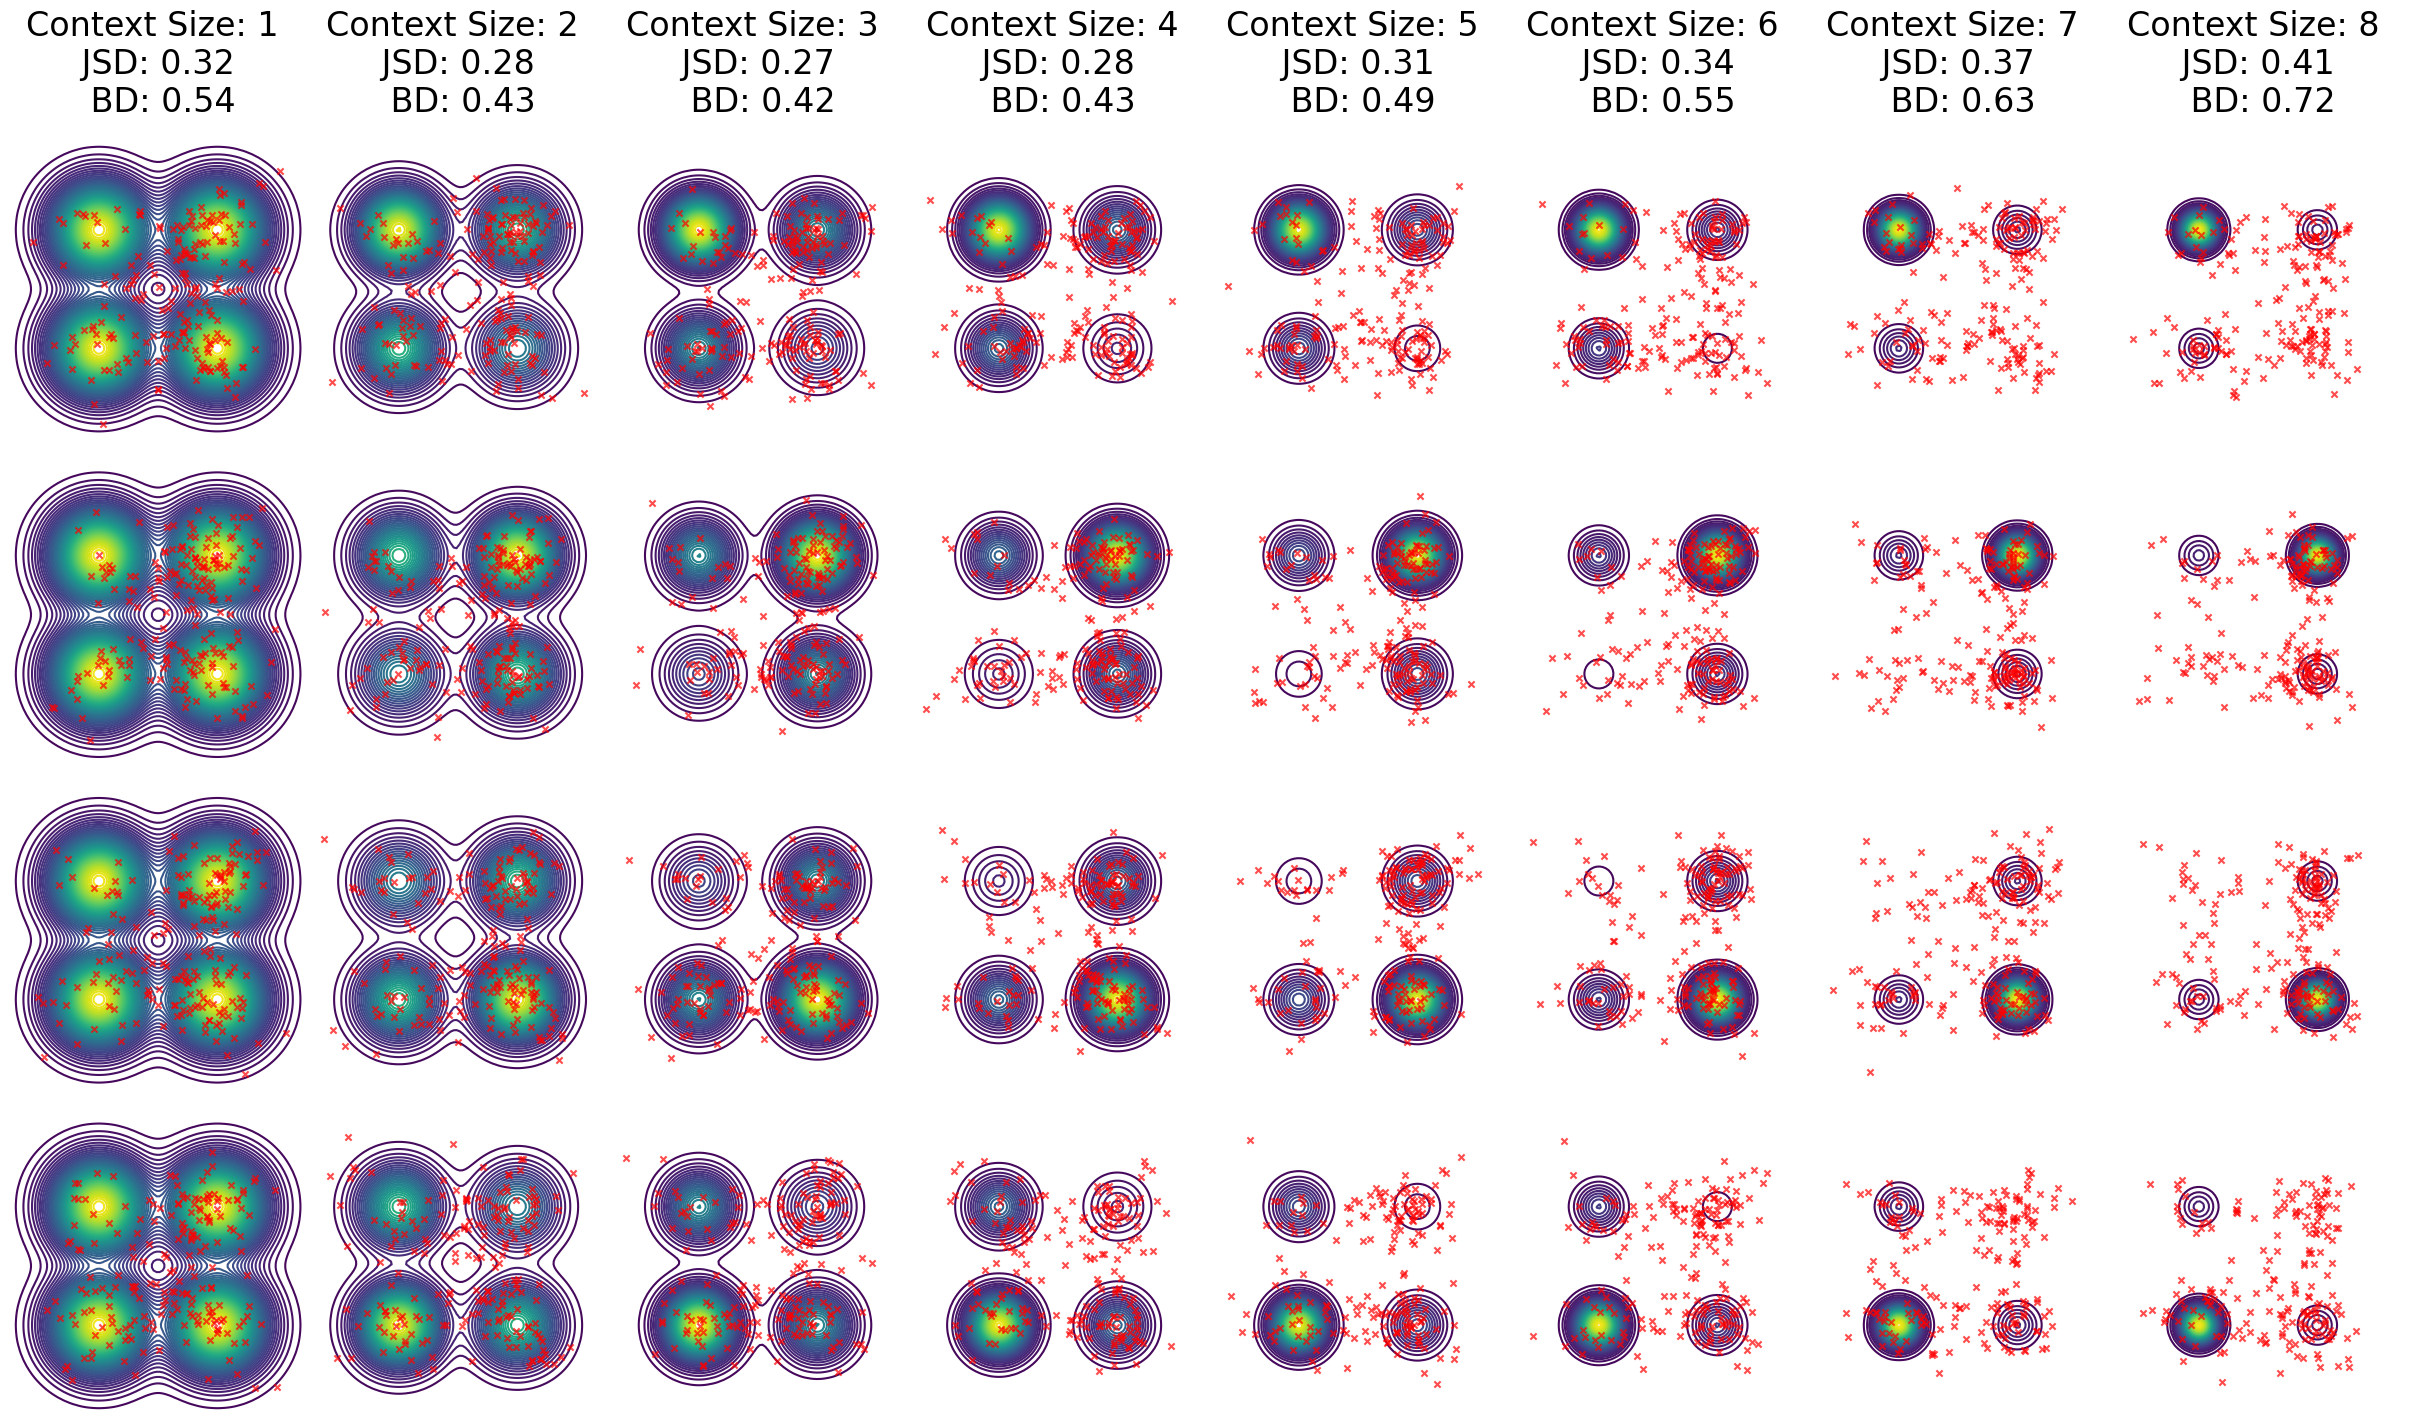

In [9]:
from dviforbml.evaluation.visualization.visualize_dvi_contour import (
    visualize_dvi_2d_contour_all,
)


# visualize_dvi_2d(device, model, dataset, multipliers=(1, 1))
visualize_dvi_2d_contour_all(device, model, dataset)